### Loading the data

In [1]:
# loading the dependencies

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pymc3 as pm
import warnings
warnings.filterwarnings('ignore')

WARN: Could not locate executable g77
WARN: Could not locate executable f77
WARN: Could not locate executable ifort
WARN: Could not locate executable ifl
WARN: Could not locate executable f90
WARN: Could not locate executable DF
WARN: Could not locate executable efl
WARN: Could not locate executable gfortran
WARN: Could not locate executable f95
WARN: Could not locate executable g95
WARN: Could not locate executable efort
WARN: Could not locate executable efc
WARN: Could not locate executable flang
WARN: don't know how to compile Fortran code on platform 'nt'


WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


##### Exercise caution while modifying the following cell

In [2]:
# enter the file path of the given dataset
promo_path = 'Data\Masked_Promo_Data.csv'
scan_path = 'Data\Masked_Scan_Data.csv'

# experiment name
experiment_folder = 'Final_Experiment'

# choice of target feature
target_feature = 'Vol.Sales'  # as it was recommended in the problem statement

# folder name where we wish to save the files
eda_plots = f'{experiment_folder}\EDA_Plots'  # To save the plots in the EDA process
ppg_retailer_raw_datasets = f'{experiment_folder}\Raw_Data' # To save the PPG X Retailer-wise raw datasets
ppg_retailer_within_cannibalization_datasets = f'{experiment_folder}\Within_Cannibalization_Data' # To save the PPG X Retailer-wise raw datasets
ppg_retailer_cross_box_cannibalization_datasets = f'{experiment_folder}\Cross_Box_Cannibalization_Data' # To save the PPG X Retailer-wise raw datasets
ppg_retailer_processed_datasets = f'{experiment_folder}\Processed_Data' # To save the PPG X Retailer-wise processed datasets ready for modelling
ppg_retailer_metrics_weights = f'{experiment_folder}\Metrics_Weights' # To save the performance and the coefficients of PPG X Retailer-wise model
ppg_retailer_contributions = f'{experiment_folder}\Contributions' # To save the contributions of all the features towards sales
ppg_retailer_contributions_percent = f'{experiment_folder}\Contributions_Percent'
final_report_folder = f'{experiment_folder}\Final_Report' # To save the final mertrics and relative contributions

# permission to overwrite the files in the above mentioned folder
overwrite_permission = True

# train test split ratio
test_size = 0.2

# top k important features
topK = 3

# parameter to impose positive constraints. Applicable only in the frequentist regressions
impose_positive_constraint = True

# applicable only in the Bayesian regression
draws, tune = 100, 100  # Ideal values for both of them must be in 100s

In [3]:
# creating the experiment folder if it did not exist already
if experiment_folder not in os.listdir():
    os.mkdir(experiment_folder)

In [4]:
# setting the style for all the plots
plt.style.use('seaborn-darkgrid')
plt.rcParams['figure.dpi'] = 300

sns.set(style='darkgrid')
sns.set_context("notebook", rc={"figure.dpi": 300})

In [5]:
# reading the datasets

df_promo = pd.read_csv(promo_path, parse_dates=['Date'])
df_scan = pd.read_csv(scan_path, parse_dates=['Date'])

Taking a peak into both the dataframes

In [6]:
df_promo.head(3).append(df_promo.tail(2))

Date             PPG  promo_catalogue  promo_ins  display_platinum  \
0    2018-01-07   Promo.Group 3                1          0                 0   
1    2018-01-07  Promo.Group 19                0          1                 0   
2    2018-01-07  Promo.Group 22                0          0                 0   
1882 2021-01-03   Promo.Group 6                0          0                 0   
1883 2021-01-03   Promo.Group 5                0          0                 0   

      display_gold  display_silver  display_bronze    Retailer  
0                0               0               0  Retailer 0  
1                0               0               0  Retailer 0  
2                0               0               0  Retailer 0  
1882             0               0               0  Retailer 1  
1883             0               0               0  Retailer 1

In [7]:
df_scan.head(3).append(df_scan.tail(2))

Retailer      Description       Category         Sub.Category  \
0       Retailer 0    Description 0  Confectionery  Candy Confectionery   
1       Retailer 0    Description 0  Confectionery  Candy Confectionery   
2       Retailer 0    Description 0  Confectionery  Candy Confectionery   
137398  Retailer 1  Description 608  Confectionery  Candy Confectionery   
137399  Retailer 1  Description 608  Confectionery  Candy Confectionery   

       Segment      Sub.Segment    Manufacturer    Brand     Sub.Brand  \
0         Bars  Bars - Bitesize  Manufacturer 0  Brand 0   Sub.Brand 0   
1         Bars  Bars - Bitesize  Manufacturer 0  Brand 0   Sub.Brand 0   
2         Bars  Bars - Bitesize  Manufacturer 0  Brand 0   Sub.Brand 0   
137398    Xmas              NaN  Manufacturer 2  Brand 7  Sub.Brand 63   
137399    Xmas              NaN  Manufacturer 2  Brand 7  Sub.Brand 63   

       Packsize    Product.Type     Promo.Group      APN       Date  \
0         38.6g  Product.Type 0   Promo.Group 0    APN 0 2018-10-07   
1         38.6g  Product.Type 0   Promo.Group 0    APN 0 2018-10-14   
2         38.6g  Product.Type 0   Promo.Group 0    APN 0 2018-10-21   
137398     120g  Product.Type 3  Promo.Group 10  APN 597 2018-09-23   
137399     120g  Product.Type 3  Promo.Group 10  APN 597 2018-09-30   

        Unit.Sales  Val.Sales  Vol.Sales  Wtd.Selling.Dist  ppg_to_model  
0              0.0        0.0        0.0               0.0             0  
1              0.0        0.0        0.0               0.0             0  
2              0.0        0.0        0.0               0.0             0  
137398         0.0        0.0        0.0               0.0             0  
137399         0.0        0.0        0.0               0.0             0

In [8]:
# checking the dimensions of both the dataframes
print(df_promo.shape, df_scan.shape)

(1884, 9) (137400, 19)


In [9]:
# checking for nulls

print(df_promo.isna().sum(),'\n')
print(df_scan.isna().sum())

Date                0
PPG                 0
promo_catalogue     0
promo_ins           0
display_platinum    0
display_gold        0
display_silver      0
display_bronze      0
Retailer            0
dtype: int64 

Retailer                0
Description             0
Category                0
Sub.Category            0
Segment                 0
Sub.Segment         10728
Manufacturer            0
Brand                   0
Sub.Brand               0
Packsize                0
Product.Type            0
Promo.Group             0
APN                     0
Date                    0
Unit.Sales              0
Val.Sales               0
Vol.Sales               0
Wtd.Selling.Dist        0
ppg_to_model            0
dtype: int64


On a given date, with a specific retailer, a specific PPG is being applied. These 3 columns are common between the above 2 dataframes and we are going to merge on the above 3 columns

In [10]:
df_scan.rename(columns={'Promo.Group':'PPG'}, inplace=True)

In [11]:
df_inscope = df_promo.merge(df_scan, on=['Date','PPG','Retailer'], how='inner')

In [12]:
df_inscope.shape

(24408, 25)

In [13]:
df_inscope.head(3).append(df_inscope.tail(2))

Date            PPG  promo_catalogue  promo_ins  display_platinum  \
0     2018-08-05  Promo.Group 3                0          0                 0   
1     2018-08-05  Promo.Group 3                0          0                 0   
2     2018-08-05  Promo.Group 3                0          0                 0   
24406 2020-09-27  Promo.Group 5                0          0                 0   
24407 2020-09-27  Promo.Group 5                0          0                 0   

       display_gold  display_silver  display_bronze    Retailer  \
0                 0               0               0  Retailer 0   
1                 0               0               0  Retailer 0   
2                 0               0               0  Retailer 0   
24406             0               0               0  Retailer 1   
24407             0               0               0  Retailer 1   

           Description  ...    Brand     Sub.Brand Packsize    Product.Type  \
0        Description 4  ...  Brand 4  Sub.Brand 63     200g  Product.Type 3   
1        Description 5  ...  Brand 4  Sub.Brand 63     190g  Product.Type 3   
2        Description 6  ...  Brand 4  Sub.Brand 63     220g  Product.Type 3   
24406  Description 231  ...  Brand 5   Sub.Brand 7     520g  Product.Type 1   
24407  Description 604  ...  Brand 5   Sub.Brand 7     480g  Product.Type 1   

           APN Unit.Sales  Val.Sales Vol.Sales Wtd.Selling.Dist ppg_to_model  
0        APN 4        0.0      0.000   0.00000              0.0            1  
1        APN 5        0.0      0.000   0.00000              0.0            1  
2        APN 7        0.0      0.000   0.00000              0.0            1  
24406  APN 230    14973.0  74408.862   7.78596             99.8            1  
24407  APN 593        0.0      0.000   0.00000              0.0            1  

[5 rows x 25 columns]

In the following cell, we're checking if the product group is not mixed up. In other words, no item is grouped under two different PPGs

In [14]:
mapping = dict()
flag = False
for i in range(df_inscope.shape[0]):
    apn = df_inscope.APN.iloc[i]
    ppg = df_inscope.PPG.iloc[i]
    if apn in mapping:
        if mapping[apn] != ppg:
            print('Bad Mapping')
            flag = True
            break
    else:
        mapping[apn] = ppg

if not flag: print('APN --> PPG mapping is done properly')

APN --> PPG mapping is done properly


In [15]:
# identifying the number of binary/categorical columns

value_counts_inscope = list()  # to check the number of unique values in each feature
drop_cols = list()      # to drop cols with no variance
binary_cols = list()    # to capture binary features which are already 0's and 1's. Won't capture any other binary features
promo_cols = list()     # to capture promo features
display_cols = list()   # to capture display features
sales_cols = list()     # to capture sales features

for col in df_inscope.columns:
    uniq_vals = df_inscope[col].unique()
    value_counts_inscope.append([col, uniq_vals.shape[0]])

    if 'promo_' in col:
        promo_cols.append(col)
    if 'display_' in col:
        display_cols.append(col)
    if '.Sales' in col:
        sales_cols.append(col)

    if uniq_vals.shape[0] == 1:
        drop_cols.append(col)
    if uniq_vals.shape[0] == 2 and set(uniq_vals) == {0,1}:
        binary_cols.append(col)

value_counts_inscope = pd.DataFrame(value_counts_inscope, columns=['Columns','Unique Values'])
value_counts_inscope

Columns  Unique Values
0               Date            113
1                PPG              6
2    promo_catalogue              2
3          promo_ins              2
4   display_platinum              2
5       display_gold              2
6     display_silver              2
7     display_bronze              2
8           Retailer              2
9        Description            153
10          Category              1
11      Sub.Category              1
12           Segment              3
13       Sub.Segment             10
14      Manufacturer              1
15             Brand              3
16         Sub.Brand             14
17          Packsize             30
18      Product.Type              2
19               APN            108
20        Unit.Sales           5480
21         Val.Sales           6738
22         Vol.Sales           6080
23  Wtd.Selling.Dist            600
24      ppg_to_model              1

In [16]:
binary_cols

['promo_catalogue',
 'promo_ins',
 'display_platinum',
 'display_gold',
 'display_silver',
 'display_bronze']

In [17]:
# dropping off 'Description' feature as it does not contain any meaningful data
drop_cols.append('Description')

In [18]:
df_inscope.drop(columns=drop_cols, inplace=True)

In [19]:
# Packsize feature can be converted into a number

def remove_unit(string):
    if string[-2:].lower() == 'kg':
        return float(string[:-2]) * 1000
    elif string[-1:].lower() == 'g':
        return float(string[:-1])
    return np.nan

df_inscope.Packsize = df_inscope.Packsize.apply(remove_unit)

In [20]:
df_inscope.Packsize.describe()

count    24408.000000
mean       306.916667
std        268.339456
min         99.000000
25%        200.000000
50%        220.000000
75%        260.000000
max       2000.000000
Name: Packsize, dtype: float64

In [21]:
# checking the info of the dataframe

df_inscope.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24408 entries, 0 to 24407
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Date              24408 non-null  datetime64[ns]
 1   PPG               24408 non-null  object        
 2   promo_catalogue   24408 non-null  int64         
 3   promo_ins         24408 non-null  int64         
 4   display_platinum  24408 non-null  int64         
 5   display_gold      24408 non-null  int64         
 6   display_silver    24408 non-null  int64         
 7   display_bronze    24408 non-null  int64         
 8   Retailer          24408 non-null  object        
 9   Segment           24408 non-null  object        
 10  Sub.Segment       22464 non-null  object        
 11  Brand             24408 non-null  object        
 12  Sub.Brand         24408 non-null  object        
 13  Packsize          24408 non-null  float64       
 14  Product.Type      2440

In [22]:
# checking the statistical summary

df_inscope.describe()

promo_catalogue     promo_ins  display_platinum  display_gold  \
count     24408.000000  24408.000000      24408.000000  24408.000000   
mean          0.287078      0.185062          0.094682      0.059284   
std           0.452408      0.388356          0.292781      0.236160   
min           0.000000      0.000000          0.000000      0.000000   
25%           0.000000      0.000000          0.000000      0.000000   
50%           0.000000      0.000000          0.000000      0.000000   
75%           1.000000      0.000000          0.000000      0.000000   
max           1.000000      1.000000          1.000000      1.000000   

       display_silver  display_bronze      Packsize     Unit.Sales  \
count    24408.000000    24408.000000  24408.000000   24408.000000   
mean         0.058014        0.137332    306.916667    3350.732517   
std          0.233774        0.344205    268.339456   10250.842996   
min          0.000000        0.000000     99.000000      -2.000000   
25%          0.000000        0.000000    200.000000       0.000000   
50%          0.000000        0.000000    220.000000       0.000000   
75%          0.000000        0.000000    260.000000      75.000000   
max          1.000000        1.000000   2000.000000  210075.000000   

           Val.Sales     Vol.Sales  Wtd.Selling.Dist  
count   24408.000000  24408.000000      24408.000000  
mean     9984.759230      0.959443         23.521518  
std     25712.333497      2.858964         41.246169  
min        -7.630000     -0.001200          0.000000  
25%         0.000000      0.000000          0.000000  
50%         0.000000      0.000000          0.000000  
75%       188.880000      0.018720         13.800000  
max    416176.727000     58.821000        100.000000

In [23]:
df_inscope.select_dtypes('object').head()

PPG    Retailer     Segment Sub.Segment    Brand     Sub.Brand  \
0  Promo.Group 3  Retailer 0  Candy Bags         NaN  Brand 4  Sub.Brand 63   
1  Promo.Group 3  Retailer 0  Candy Bags         NaN  Brand 4  Sub.Brand 63   
2  Promo.Group 3  Retailer 0  Candy Bags         NaN  Brand 4  Sub.Brand 63   
3  Promo.Group 3  Retailer 0  Candy Bags         NaN  Brand 4  Sub.Brand 63   
4  Promo.Group 3  Retailer 0  Candy Bags         NaN  Brand 4  Sub.Brand 63   

     Product.Type     APN  
0  Product.Type 3   APN 4  
1  Product.Type 3   APN 5  
2  Product.Type 3   APN 7  
3  Product.Type 3   APN 9  
4  Product.Type 3  APN 10

Clearly all the above features are categorical, if we choose to include some of them in the model, we'll encode them after performing EDA.

Since the problem statement requires us to find the coefficients at PPG x Retailer level. Lets create a new feature based of  PPG and Retailer as follows. Also we can produce seasonal features such as week of the day, week of the year, month etc from the Date feature

In [24]:
df_inscope['PPG_Retailer'] = df_inscope['PPG'] + '__' + df_inscope['Retailer']

In [25]:
df_inscope['PPG_Retailer'].unique()

array(['Promo.Group 3__Retailer 0', 'Promo.Group 19__Retailer 0',
       'Promo.Group 22__Retailer 0', 'Promo.Group 20__Retailer 0',
       'Promo.Group 6__Retailer 0', 'Promo.Group 5__Retailer 0',
       'Promo.Group 3__Retailer 1', 'Promo.Group 19__Retailer 1',
       'Promo.Group 20__Retailer 1', 'Promo.Group 22__Retailer 1',
       'Promo.Group 6__Retailer 1', 'Promo.Group 5__Retailer 1'],
      dtype=object)

In [26]:
# Checking if both the types of Promos are mutually exclusive
df_inscope[promo_cols].sum(axis=1).unique()

array([0, 1], dtype=int64)

In [27]:
# Checking if all the 4 types of Displays are mutually exclusive
df_inscope[display_cols].sum(axis=1).unique()

array([0, 1], dtype=int64)

Clearly both the Promo_ features are mutually exclusive or in other words, if one Promo_ feature is on, the other must be off. Because if both the Promo_ are running simultaneously. Then we would get the sum >= 2.

The above logic applies for 4 Display_ features as well.

In [28]:
# Checking if all the 6  Promo and Displays are mutually exclusive
df_inscope[promo_cols + display_cols].sum(axis=1).unique()

array([0, 1, 2], dtype=int64)

Since there is a 2, it means that Promo_ and Display_ can co-exist

Looking for obvious anomalies. This is not outlier removal, we will perform them later. Here we're going to remove obvious errors like having negative sales or having 0 unit sales but non-zero dollar sales etc

In [29]:
# There are 3 types of sales: Unit Sales, Value Sales, Volume Sales
def find_negatives_in_sales(df):

    negative_indices = set()
    for col in df.columns:
        if '.sales' in col.lower():
            negative_indices = negative_indices.union(set(df[df[col] < 0].index))

    if negative_indices:
        print(f"There are {len(negative_indices)} indices with negative sales value\n")
        return list(negative_indices)
    print('There are no negative sales value\n')

In [30]:
# Negative sales of any form is obvious anomaly. Lets drop those indices
negatives = find_negatives_in_sales(df_inscope)
df_inscope.drop(index=negatives, inplace=True)

There are 33 indices with negative sales value



In [31]:
# Checking again if the negative indices are successfully removed
negatives_check = find_negatives_in_sales(df_inscope)

There are no negative sales value



Now we're looking for the anomalies where one of the sales is zero, whereas the other type of sales is non-zero

In [32]:
def disparity_in_zero_sales(df):

    zero_indices = dict()
    sales_cols = list()
    for col in df.columns:
        if '.sales' in col.lower():
            sales_cols.append(col)
            zero_indices[col] = set(df[df[col] == 0].index)

    remove_indices = set()
    n = len(sales_cols)
    for i in range(n - 1):
        for j in range(i + 1, n):
            remove_indices = remove_indices.union(zero_indices[sales_cols[i]] - zero_indices[sales_cols[j]])
            remove_indices = remove_indices.union(zero_indices[sales_cols[j]] - zero_indices[sales_cols[i]])

    if remove_indices:
        print(f"There are {len(remove_indices)} indices with sales disparity\n")
        return list(remove_indices)
    print('There are no sales disparities\n')

Clearly zero_units and zero_volume are same. But zero_units and zero_value are not. Lets find the indices where they're different

In [33]:
# getting the list of zero sales disparities
disparity = disparity_in_zero_sales(df_inscope)
df_inscope.drop(index=disparity, inplace=True)

There are 4 indices with sales disparity



In [34]:
# checking again if the disparities are removed
disparity_check = disparity_in_zero_sales(df_inscope)

There are no sales disparities



In [35]:
df_inscope.reset_index(drop=True, inplace=True)

In [36]:
# function to check if the dates are weekly and contiguous

def checking_Data_continuity(df):

    datedf = df[['Date']].drop_duplicates().sort_values('Date')
    myset = set()
    for i in range(datedf.shape[0] - 1):
        myset.add((datedf.Date.iloc[i + 1] - datedf.Date.iloc[i]).days)

    return myset == {7}

In [37]:
checking_Data_continuity(df_inscope)

True

Since the difference between a date and its preceding date is exactly 7 days. It implies that the dates are in weekly and there are no missing dates

In [38]:
# Checking if Weighted Selling Distribution is negative

(df_inscope['Wtd.Selling.Dist'] < 0).sum()

0

In [39]:
# Checking if Vol.Sales is basically same as Unit.Sales times Packsize

np.all(df_inscope['Vol.Sales'] == df_inscope['Packsize'] * df_inscope['Unit.Sales'] / 1e6)

True

Note that volume is measured in metric tons

### Exploratory Data Analysis

Analyzing the sales features

In [40]:
# creating the folder for datasets if it did not exist already
if eda_plots not in os.listdir():
    os.mkdir(eda_plots)

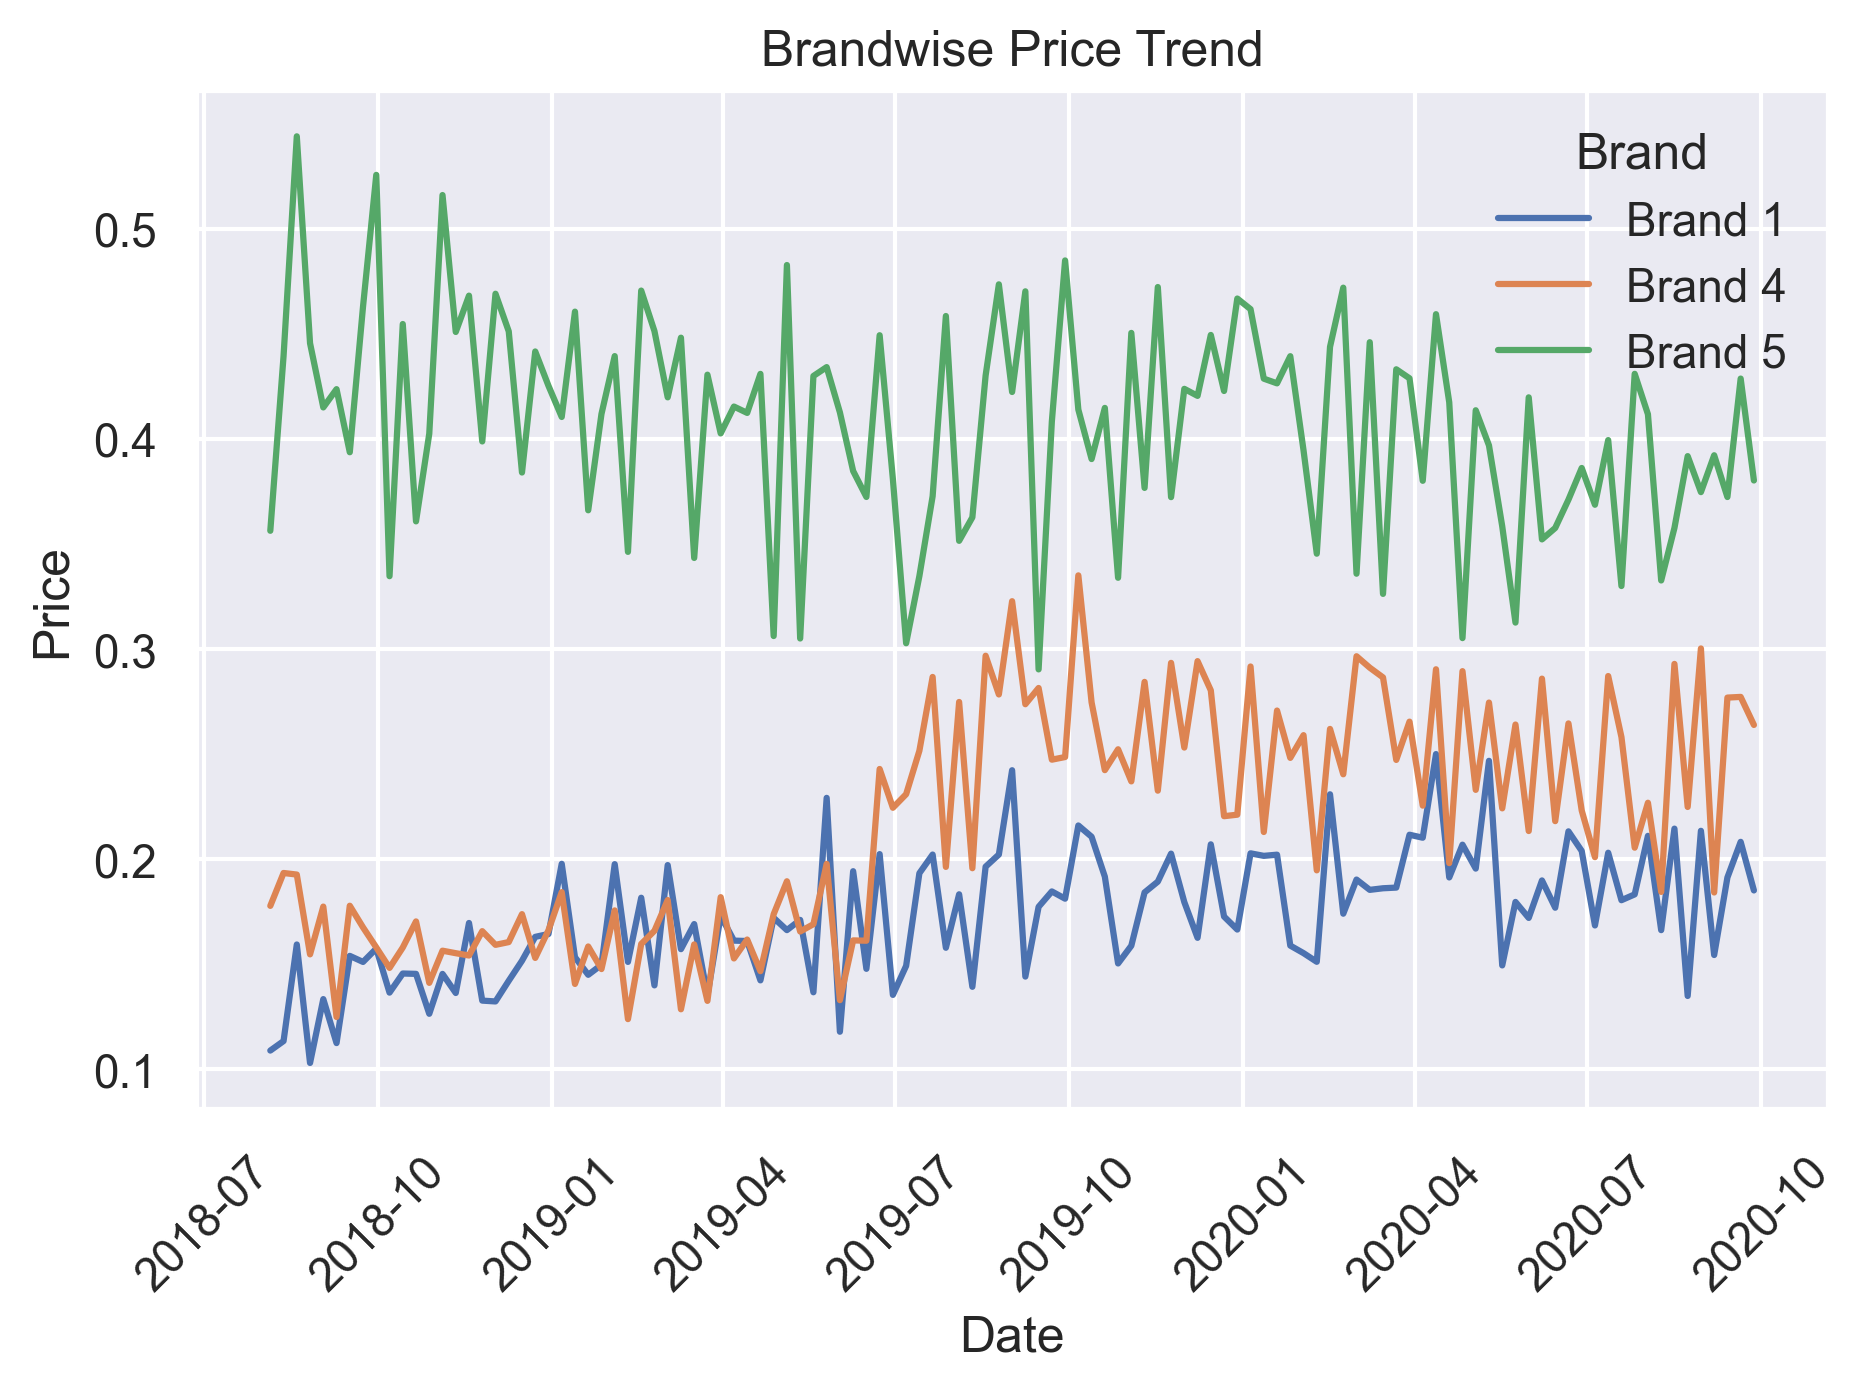

In [41]:
temp = df_inscope.copy()
temp['Price'] = temp['Val.Sales'] / (temp['Vol.Sales'] * 1e6)
temp = temp.groupby(['Date','Brand']).agg({'Price':'sum'}).reset_index()
temp.sort_values('Date', inplace=True)
sns.lineplot(x=temp['Date'],y=temp['Price'],hue=temp['Brand'])
plt.xticks(rotation=45)
plt.title('Brandwise Price Trend')
plt.tight_layout();

if overwrite_permission:
    plt.savefig(f"{eda_plots}\Brandwise_Price_Trend.png")

In [42]:
temp = df_inscope.copy()
temp = temp.groupby('Date').agg({'Vol.Sales':'sum', 'Unit.Sales':'sum', 'Val.Sales':'sum'}).reset_index()
temp.sort_values('Date', inplace=True)

In [43]:
temp

Date   Vol.Sales  Unit.Sales    Val.Sales
0   2018-08-05  213.164230    713352.0  2372864.787
1   2018-08-12  164.777280    515711.0  1872530.765
2   2018-08-19  135.000590    410644.0  1643815.265
3   2018-08-26  333.724775   1240732.0  3002664.498
4   2018-09-02  211.649060    728504.0  2323405.764
..         ...         ...         ...          ...
108 2020-08-30  158.566490    528713.0  1908779.294
109 2020-09-06  224.137010    818352.0  2242920.080
110 2020-09-13  210.235195    718652.0  2119723.961
111 2020-09-20  147.275870    478097.0  1837928.830
112 2020-09-27  157.617515    521238.0  1869979.480

[113 rows x 4 columns]

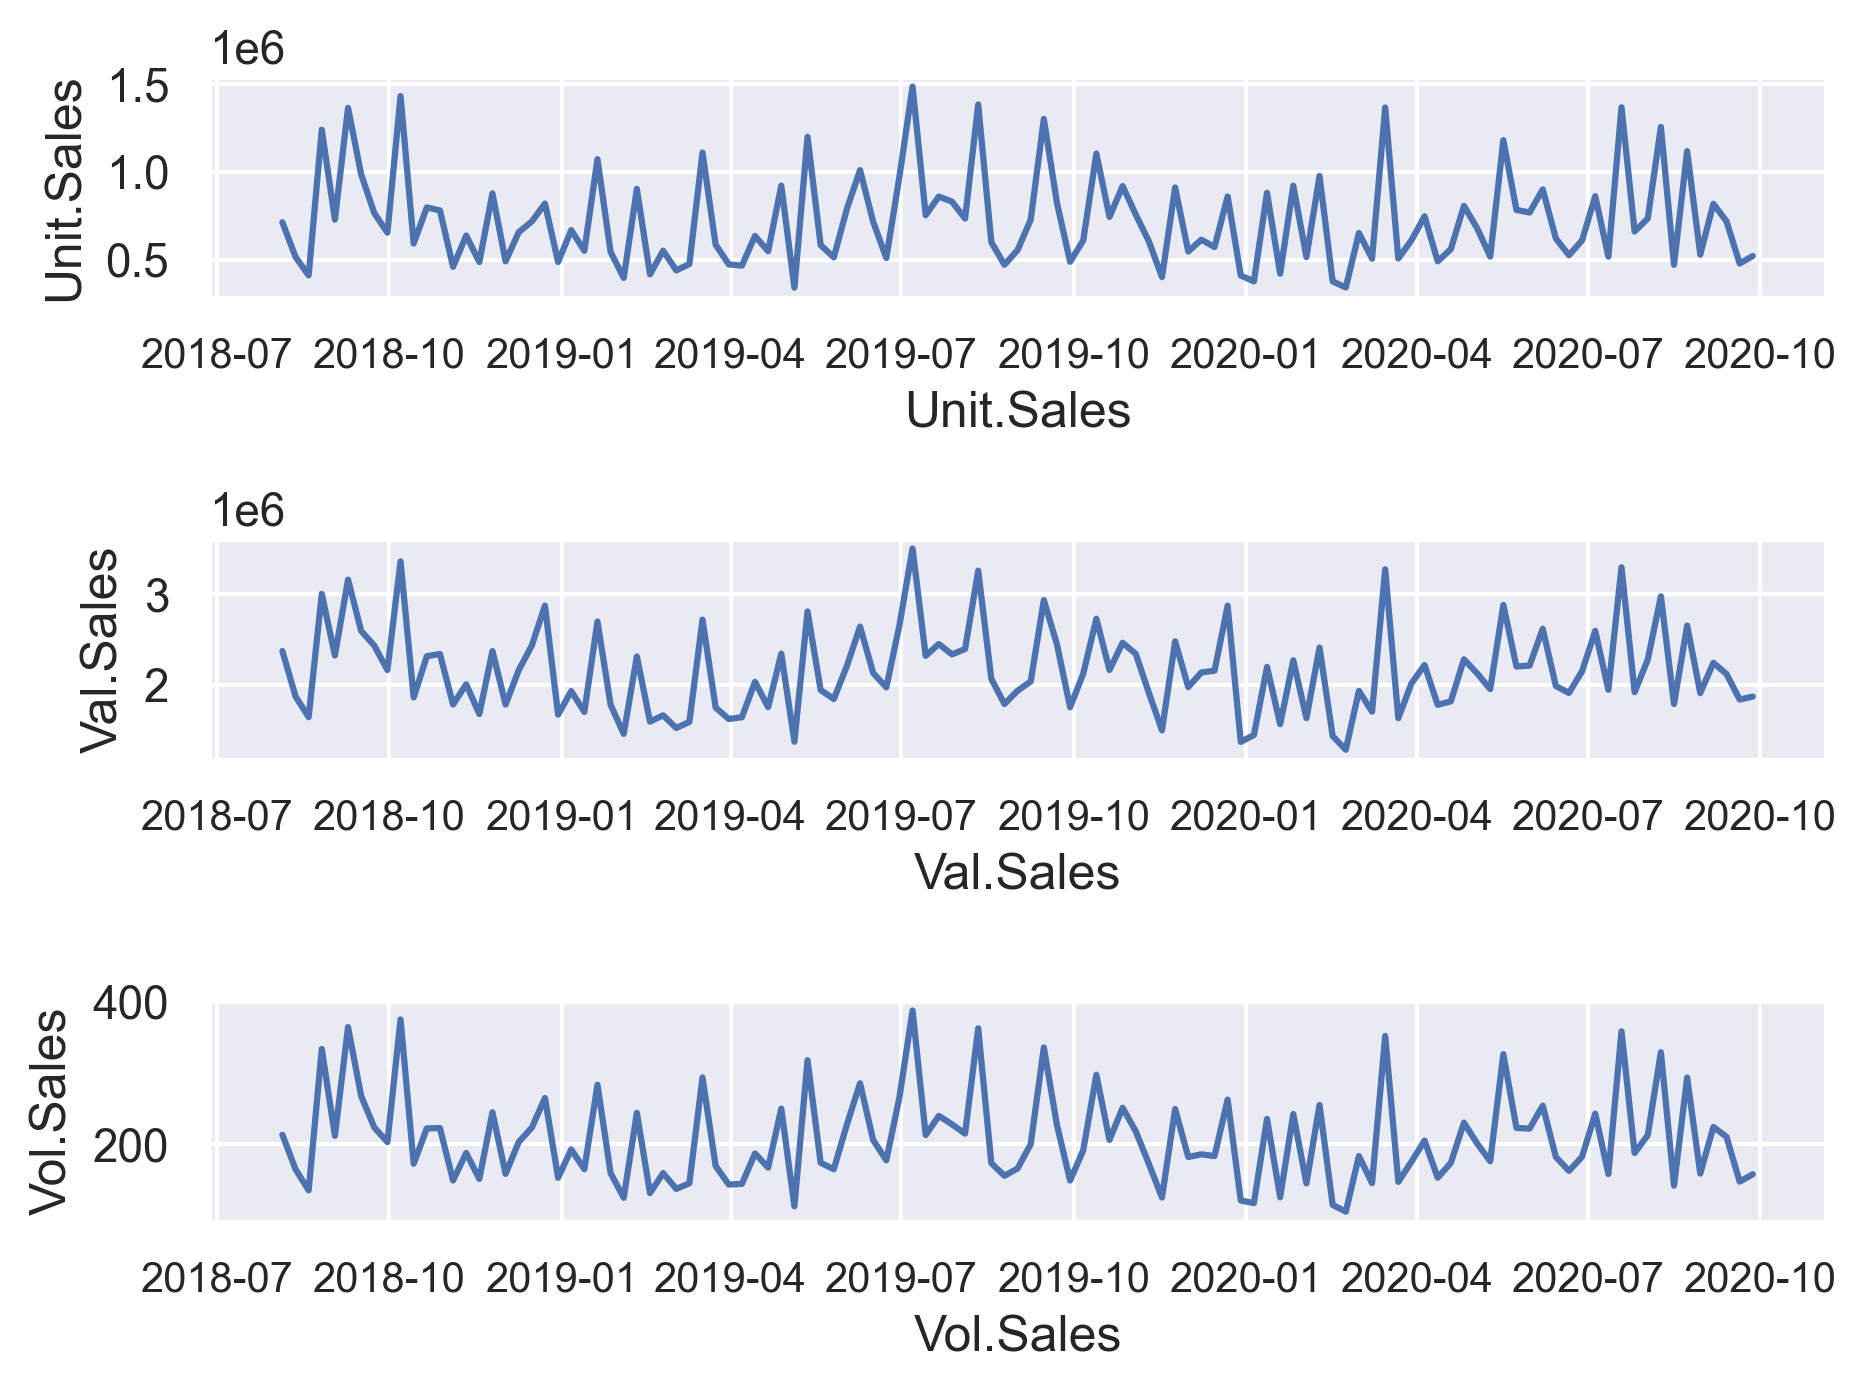

In [44]:
for i, col in enumerate(sales_cols):
    plt.subplot(3,1,i+1)
    sns.lineplot(x=temp['Date'], y=temp[col])
    plt.xlabel(col)
    plt.xticks(fontsize=10);

plt.tight_layout()

In [45]:
df_inscope[sales_cols].corr()

Unit.Sales  Val.Sales  Vol.Sales
Unit.Sales    1.000000   0.943846   0.961374
Val.Sales     0.943846   1.000000   0.978659
Vol.Sales     0.961374   0.978659   1.000000

Deriving the "Price" feature here

In [46]:
df_inscope['Price'] = df_inscope['Val.Sales'] / (df_inscope['Vol.Sales'] * 1e6)

In [47]:
df_inscope['Price'].isna().sum()

17235

There are many NaNs in Price which is due to the fact that Sales is 0 in many datapoints, inspite of that we cannot remove those datapoints because there are promotional activities even in those datapoints. So to retain Price, we need to impute them with reasonable values which requires further analysis of price

In [48]:
def price_analysis(df):
    price_variation = list()
    total_nonnulls = 0
    for ppg in df.PPG.unique():
        for ptype in df['Product.Type'].unique():
            mask = (df.PPG == ppg) & (df['Product.Type'] == ptype) & (~df.Price.isna())
            num_rows = mask.sum()
            total_nonnulls += num_rows
            mu = np.round(df[mask].Price.mean(), 6)
            std = np.round(df[mask].Price.std(), 6)
            coeff_var = np.round(std / mu * 100, 2) 
            price_variation.append([ppg, ptype, num_rows, mu, std, coeff_var])    
    
    price_variation = pd.DataFrame(price_variation, columns=['PPG', 'Product.Type', 'NumRows', 'Mu', 'Std', 'Coeff_Var'])
    print(f"There are {total_nonnulls} non-Null datapoints out of {df.shape[0]} datapoints in total\n")
    return price_variation

In [49]:
price_analysis(df_inscope)

There are 7136 non-Null datapoints out of 24371 datapoints in total



PPG    Product.Type  NumRows        Mu       Std  Coeff_Var
0    Promo.Group 3  Product.Type 3      103  0.013135  0.005245      39.93
1    Promo.Group 3  Product.Type 1     1402  0.014945  0.005589      37.40
2   Promo.Group 19  Product.Type 3       18  0.009554  0.000042       0.44
3   Promo.Group 19  Product.Type 1      212  0.009407  0.000750       7.97
4   Promo.Group 22  Product.Type 3       11  0.009564  0.000032       0.33
5   Promo.Group 22  Product.Type 1      196  0.009310  0.000916       9.84
6   Promo.Group 20  Product.Type 3       78  0.013957  0.003550      25.44
7   Promo.Group 20  Product.Type 1     1278  0.012943  0.004134      31.94
8    Promo.Group 6  Product.Type 3      238  0.013495  0.003608      26.74
9    Promo.Group 6  Product.Type 1     2682  0.012770  0.003590      28.11
10   Promo.Group 5  Product.Type 3       82  0.009689  0.001468      15.15
11   Promo.Group 5  Product.Type 1      836  0.009310  0.002252      24.19

Based on the above analysis, we are imputing the NaN price of every combination of PPG and Product.Type with the mean of the non-NaN prices within the same subset

In [50]:
for ppg in df_inscope.PPG.unique():
    for ptype in df_inscope['Product.Type'].unique():
        nonNANmask = (df_inscope.PPG == ppg) & (df_inscope['Product.Type'] == ptype) & (~df_inscope.Price.isna())
        NANmask = (df_inscope.PPG == ppg) & (df_inscope['Product.Type'] == ptype) & (df_inscope.Price.isna())
        NANmask_indexes = df_inscope[NANmask].index
        mu = df_inscope[nonNANmask]['Price'].mean()
        df_inscope.loc[NANmask_indexes, 'Price'] = mu

In [51]:
price_analysis(df_inscope)

There are 24371 non-Null datapoints out of 24371 datapoints in total



PPG    Product.Type  NumRows        Mu       Std  Coeff_Var
0    Promo.Group 3  Product.Type 3      808  0.013135  0.001865      14.20
1    Promo.Group 3  Product.Type 1     9350  0.014945  0.002164      14.48
2   Promo.Group 19  Product.Type 3       90  0.009554  0.000019       0.20
3   Promo.Group 19  Product.Type 1     1040  0.009407  0.000338       3.59
4   Promo.Group 22  Product.Type 3       18  0.009564  0.000024       0.25
5   Promo.Group 22  Product.Type 1      208  0.009310  0.000889       9.55
6   Promo.Group 20  Product.Type 3      270  0.013957  0.001899      13.61
7   Promo.Group 20  Product.Type 1     3107  0.012943  0.002651      20.48
8    Promo.Group 6  Product.Type 3      558  0.013495  0.002354      17.44
9    Promo.Group 6  Product.Type 1     6440  0.012770  0.002316      18.14
10   Promo.Group 5  Product.Type 3      198  0.009689  0.000942       9.72
11   Promo.Group 5  Product.Type 1     2284  0.009310  0.001362      14.63

Since the problem statement says that we need to build a model on Volume Sales and also since graphically and analytically we see that these 3 sales cols are highly correlated. We'll drop off Value Sales and Unit Sales.

In [52]:
df_inscope.drop(columns=['Unit.Sales', 'Val.Sales'], inplace=True)

In [53]:
# import pymc3 as pm
# import numpy as np
# import matplotlib.pyplot as plt

# # Generate synthetic data with two independent features
# np.random.seed(42)
# X1 = np.random.rand(100, 1) * 10
# X2 = np.random.rand(100, 1) * 5  # Second independent feature
# true_intercept = 1.0
# true_slope1 = 2.5
# true_slope2 = -1.0
# noise = np.random.normal(0, 1, (100, 1))
# y = true_intercept + true_slope1 * X1.flatten() + true_slope2 * X2.flatten() + noise.flatten()

# # Bayesian linear regression model with two independent features
# with pm.Model() as linear_model:
#     # Priors for the model parameters
#     intercept = pm.Normal('intercept', mu=0, sd=10)
#     slope1 = pm.Normal('slope1', mu=0, sd=10)
#     slope2 = pm.Normal('slope2', mu=0, sd=10)

#     # Likelihood of the observations
#     likelihood = pm.Normal('y', mu=intercept + slope1 * X1.flatten() + slope2 * X2.flatten(), sd=1, observed=y)

#     # Sample from the posterior distribution using NUTS
#     trace = pm.sample(100, tune=100, cores=-1)  # Adjust the number of samples and tuning steps as needed

#     map_estimate = pm.find_MAP()

# # Display the MAP estimate
# print("MAP estimate:")
# print("Intercept:", map_estimate['intercept'])
# print("Slope1:", map_estimate['slope1'])
# print("Slope2:", map_estimate['slope2'])

# # Plot the posterior distribution and credible intervals
# pm.plot_posterior(trace, var_names=['intercept', 'slope1', 'slope2'])
# plt.show()


In [54]:
# Checking for different combinations of features to obtain primary key

df_inscope.duplicated(subset=['Date', 'PPG_Retailer', 'APN']).sum()

0

Since the triplet of 'Date', 'PPG_Retailer', 'APN' has no duplicated triplet. Note each of the feature within itself may have duplicates. In business terms we can look at it like, each entry (row) corresponds to a specific combination of a given day, a given PPG_Retailer, and a specific item within the package.

Introducing derived seasonality features such as week of the year, month of the year, quarter of the year etc

In [55]:
df_inscope['WeekNum'] = df_inscope.Date.dt.weekofyear
df_inscope['Month'] = df_inscope.Date.dt.month
df_inscope['Quarter'] = df_inscope.Date.dt.quarter
df_inscope['Year'] = df_inscope.Date.dt.year
df_inscope['Month_Year'] = df_inscope['Month'].astype('str') + '__' + df_inscope['Year'].astype('str')

In [56]:
df_inscope.head(3).append(df_inscope.tail(2))

Date            PPG  promo_catalogue  promo_ins  display_platinum  \
0     2018-08-05  Promo.Group 3                0          0                 0   
1     2018-08-05  Promo.Group 3                0          0                 0   
2     2018-08-05  Promo.Group 3                0          0                 0   
24369 2020-09-27  Promo.Group 5                0          0                 0   
24370 2020-09-27  Promo.Group 5                0          0                 0   

       display_gold  display_silver  display_bronze    Retailer     Segment  \
0                 0               0               0  Retailer 0  Candy Bags   
1                 0               0               0  Retailer 0  Candy Bags   
2                 0               0               0  Retailer 0  Candy Bags   
24369             0               0               0  Retailer 1  Candy Bags   
24370             0               0               0  Retailer 1        Xmas   

       ...      APN Vol.Sales Wtd.Selling.Dist               PPG_Retailer  \
0      ...    APN 4   0.00000              0.0  Promo.Group 3__Retailer 0   
1      ...    APN 5   0.00000              0.0  Promo.Group 3__Retailer 0   
2      ...    APN 7   0.00000              0.0  Promo.Group 3__Retailer 0   
24369  ...  APN 230   7.78596             99.8  Promo.Group 5__Retailer 1   
24370  ...  APN 593   0.00000              0.0  Promo.Group 5__Retailer 1   

          Price WeekNum  Month  Quarter  Year  Month_Year  
0      0.013135      31      8        3  2018     8__2018  
1      0.013135      31      8        3  2018     8__2018  
2      0.013135      31      8        3  2018     8__2018  
24369  0.009557      39      9        3  2020     9__2020  
24370  0.009310      39      9        3  2020     9__2020  

[5 rows x 25 columns]

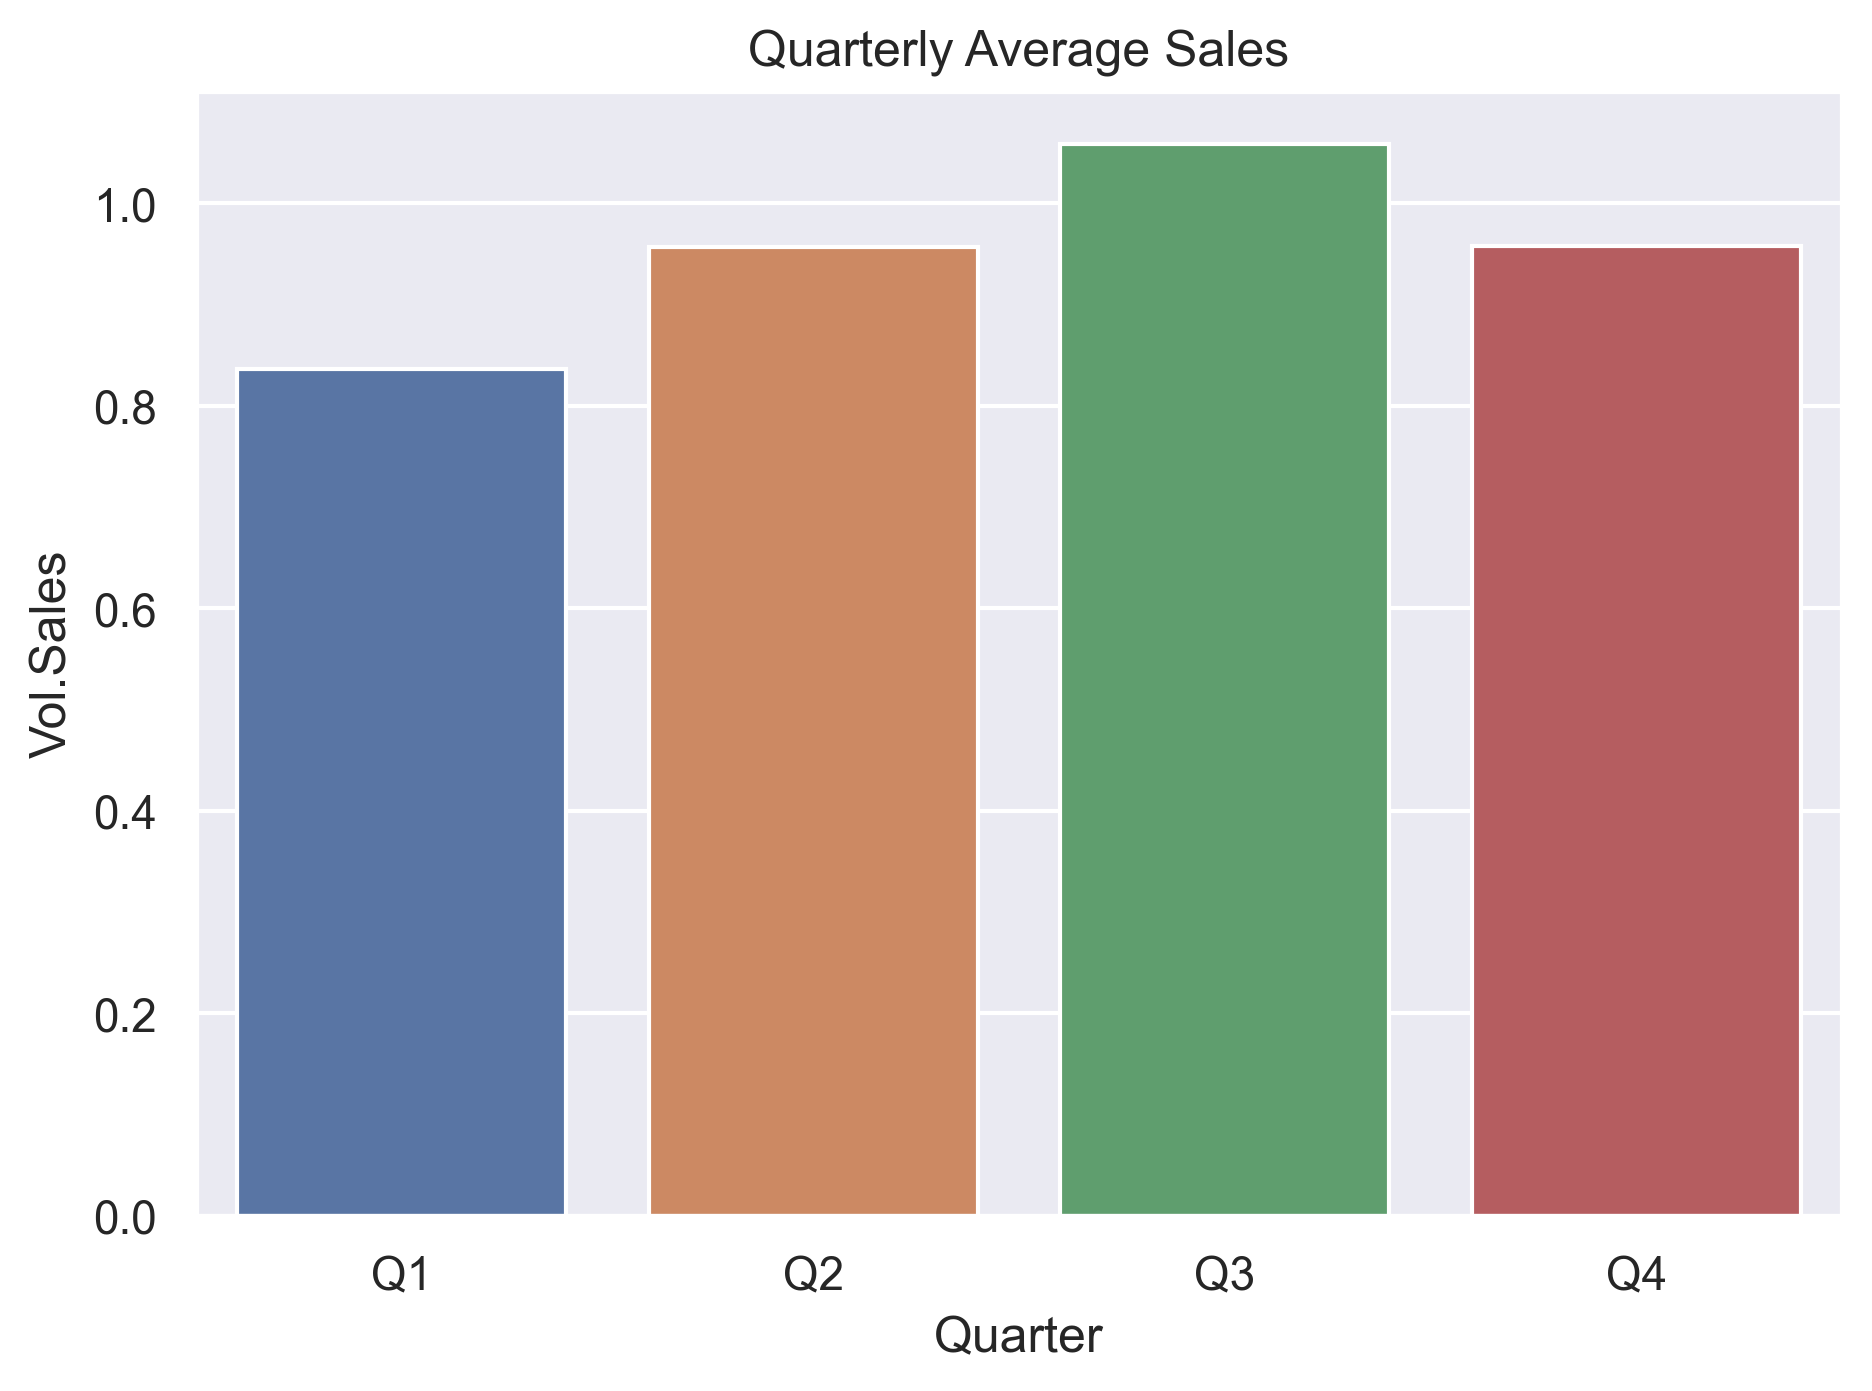

In [57]:
temp = df_inscope.copy()
temp['Quarter'] = temp['Quarter'].map({1:'Q1', 2:'Q2', 3:'Q3', 4:'Q4'})
temp = temp.groupby(['Quarter']).agg({'Vol.Sales':'mean'}).reset_index()
sns.barplot(temp['Quarter'],temp['Vol.Sales'])
plt.title('Quarterly Average Sales')
plt.tight_layout();

if overwrite_permission:
    plt.savefig(f"{eda_plots}\Quarterly_Average_Sales.png")

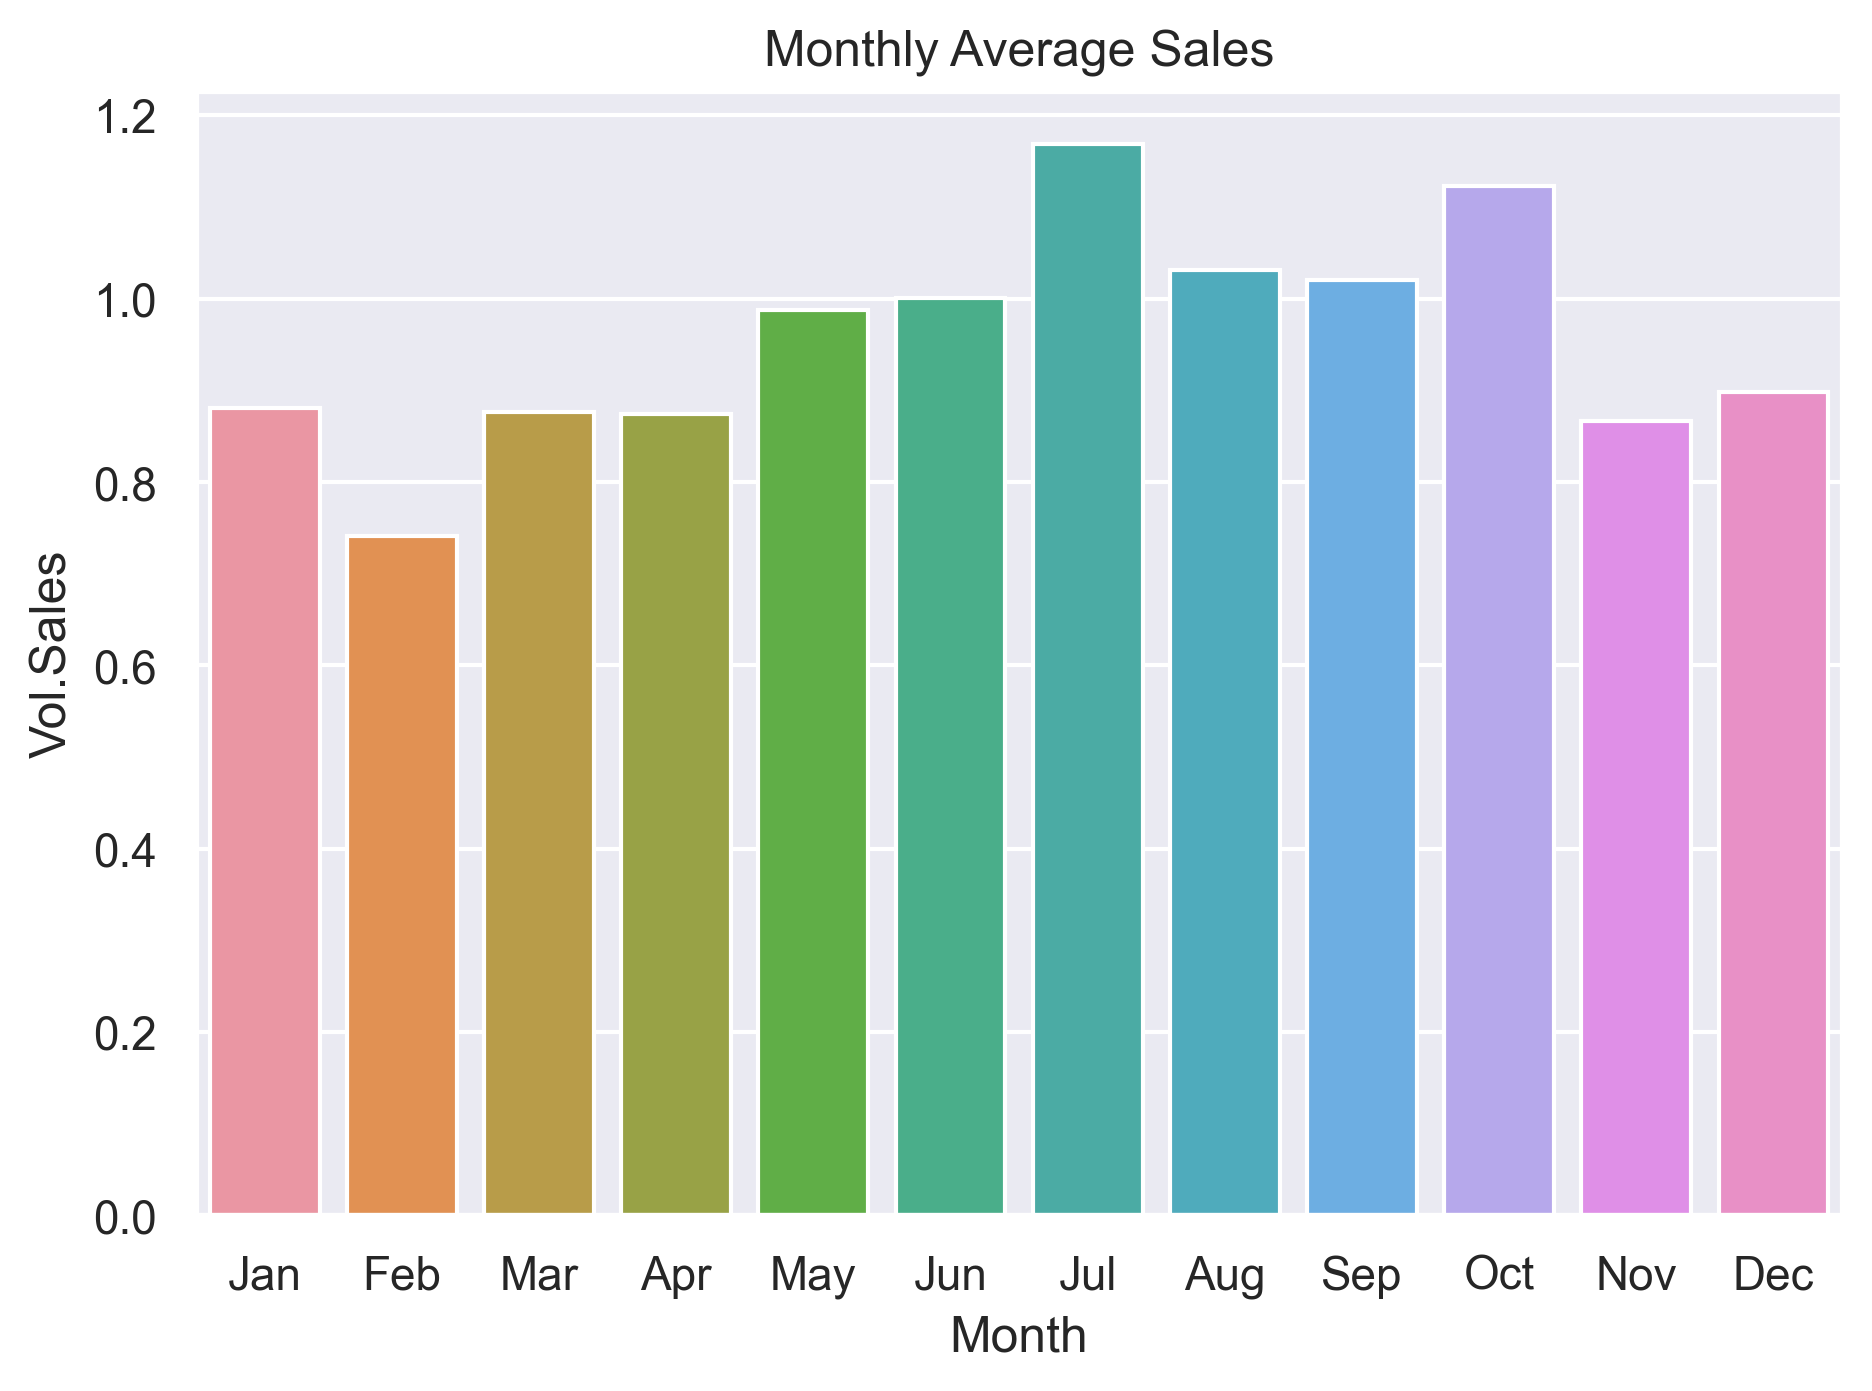

In [58]:
temp = df_inscope.copy()
temp = temp.groupby(['Month']).agg({'Vol.Sales':'mean'}).reset_index()
temp['Month'] = temp['Month'].map({1:'Jan',2:'Feb',3:'Mar',4:'Apr',5:'May',6:'Jun',7:'Jul',8:'Aug',9:'Sep',
                                 10:'Oct',11:'Nov',12:'Dec'})
sns.barplot(temp['Month'],temp['Vol.Sales'])
plt.xticks(rotation=0)
plt.title('Monthly Average Sales')
plt.tight_layout();

if overwrite_permission:
    plt.savefig(f"{eda_plots}\Monthly_Average_Sales.png")

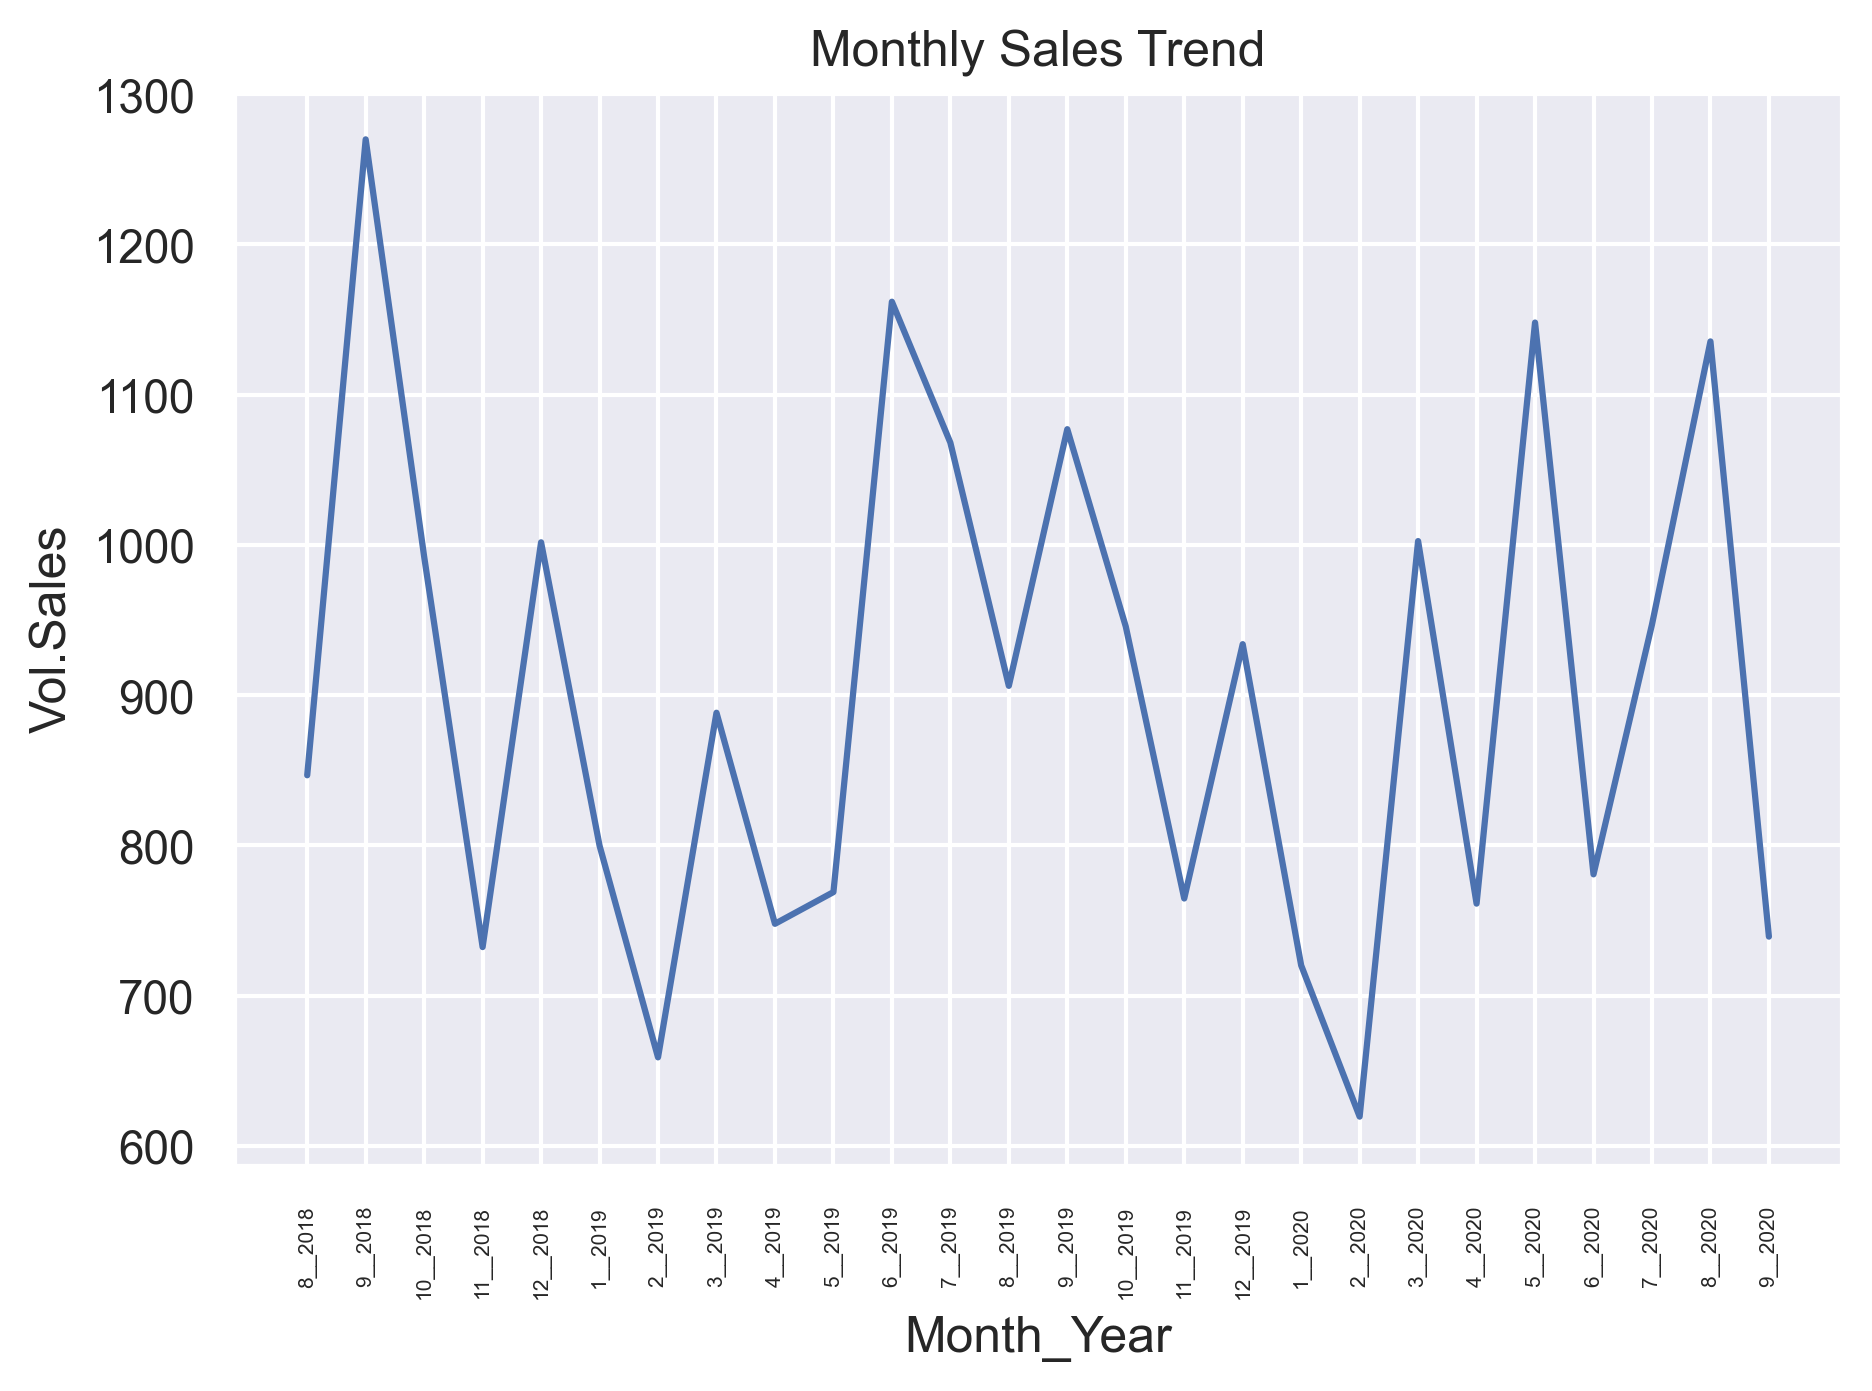

In [59]:
temp = df_inscope.copy()
temp['sorting_helper'] = list(zip(df_inscope['Year'], df_inscope['Month']))
temp = temp.groupby(['Month_Year']).agg({'Vol.Sales':'sum', 'sorting_helper':'first'}).reset_index()
temp.sort_values('sorting_helper', inplace=True)
sns.lineplot(temp['Month_Year'],temp['Vol.Sales'])
plt.xticks(rotation=90, fontsize=5)
plt.title('Monthly Sales Trend')
plt.tight_layout();

if overwrite_permission:
    plt.savefig(f"{eda_plots}\Monthly_Sales_Trend.png")

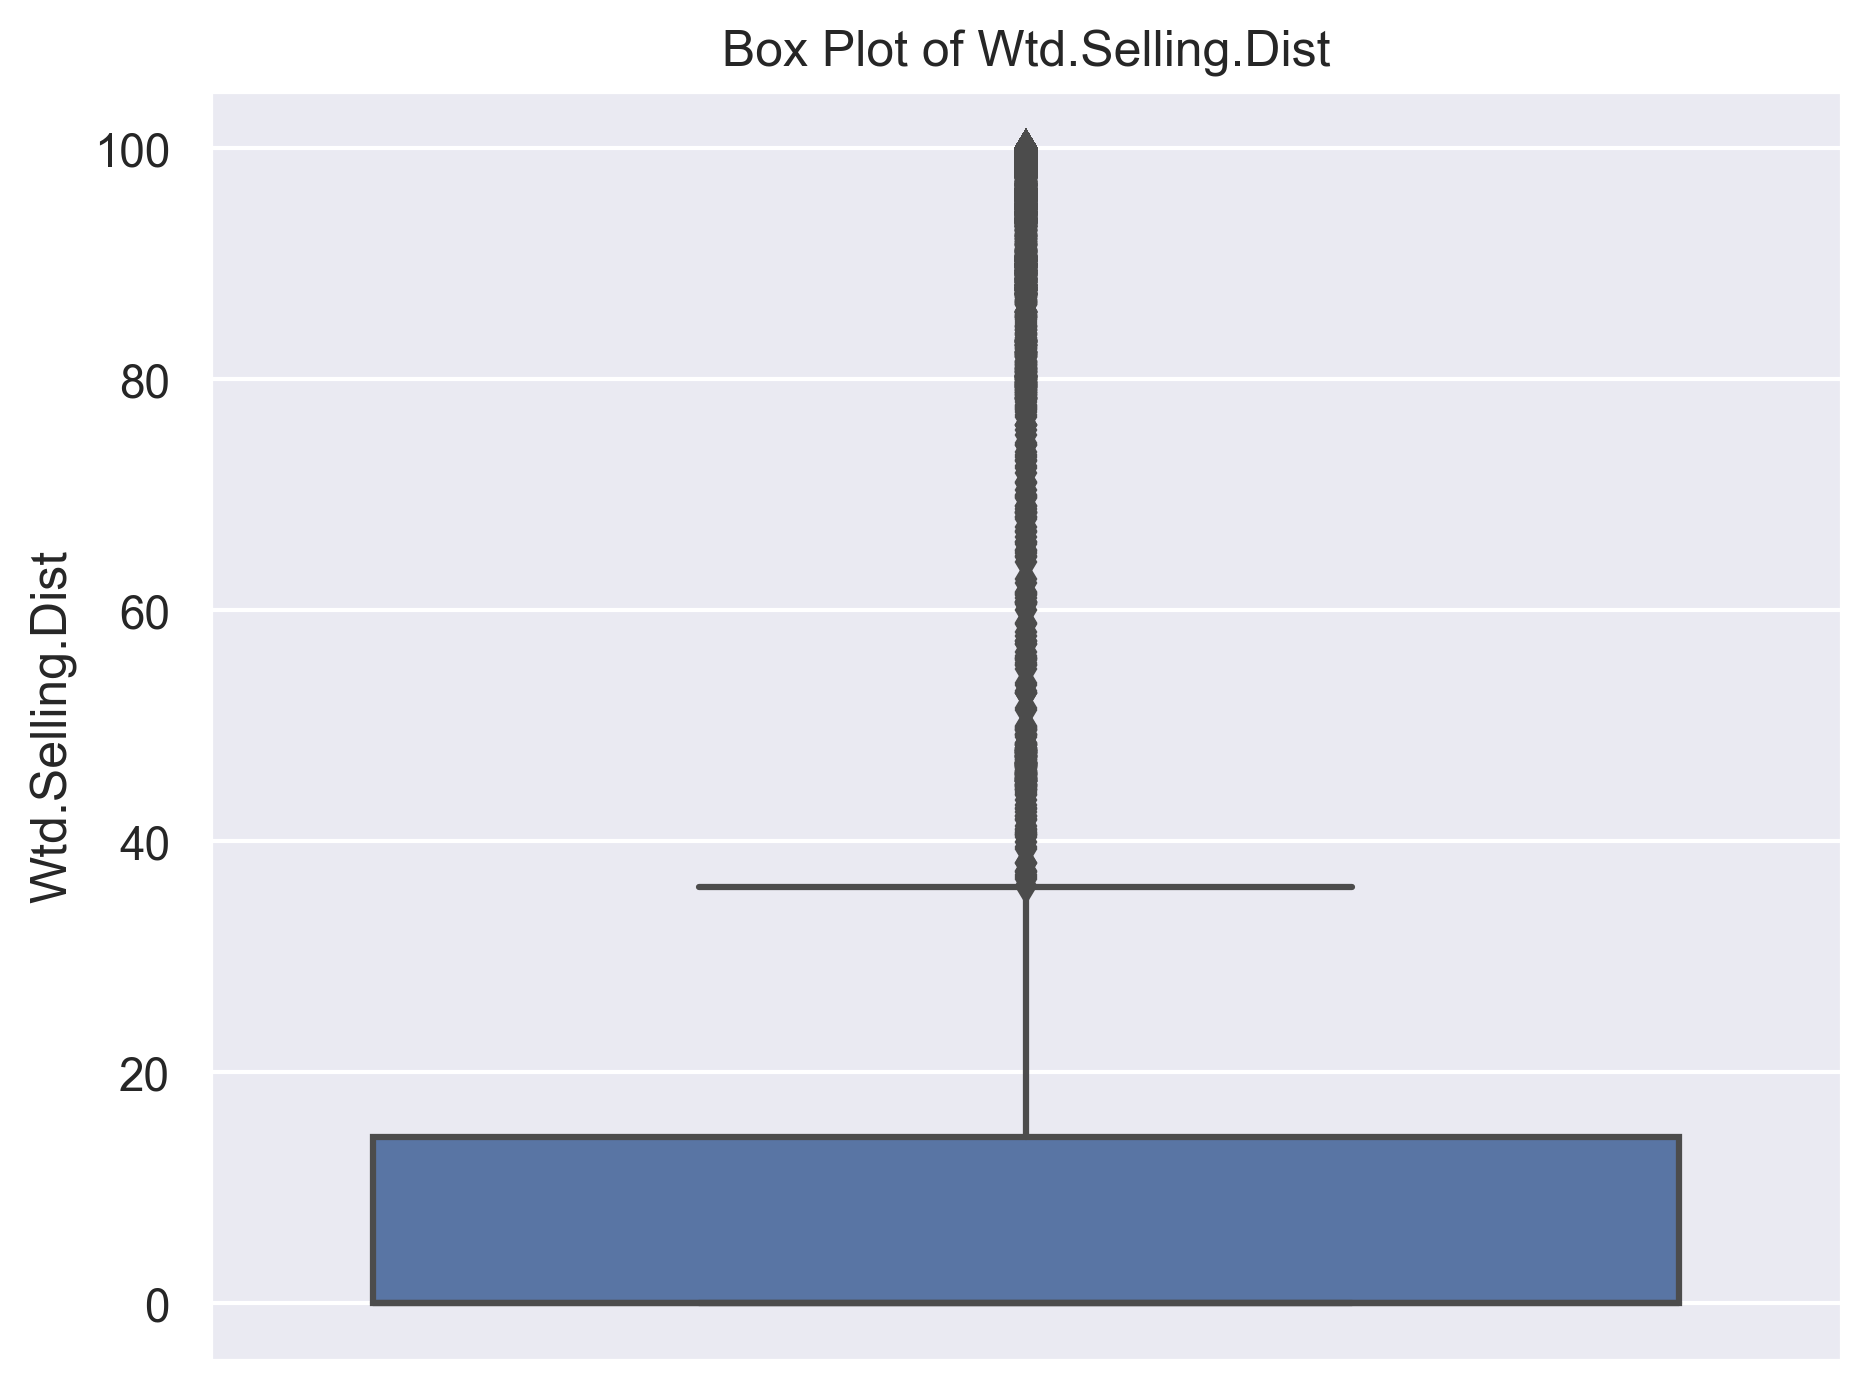

In [60]:
sns.boxplot(y=df_inscope['Wtd.Selling.Dist'])
plt.title('Box Plot of Wtd.Selling.Dist')
plt.tight_layout();

if overwrite_permission:
    plt.savefig(f"{eda_plots}\Wtd_Selling_Dist.png")

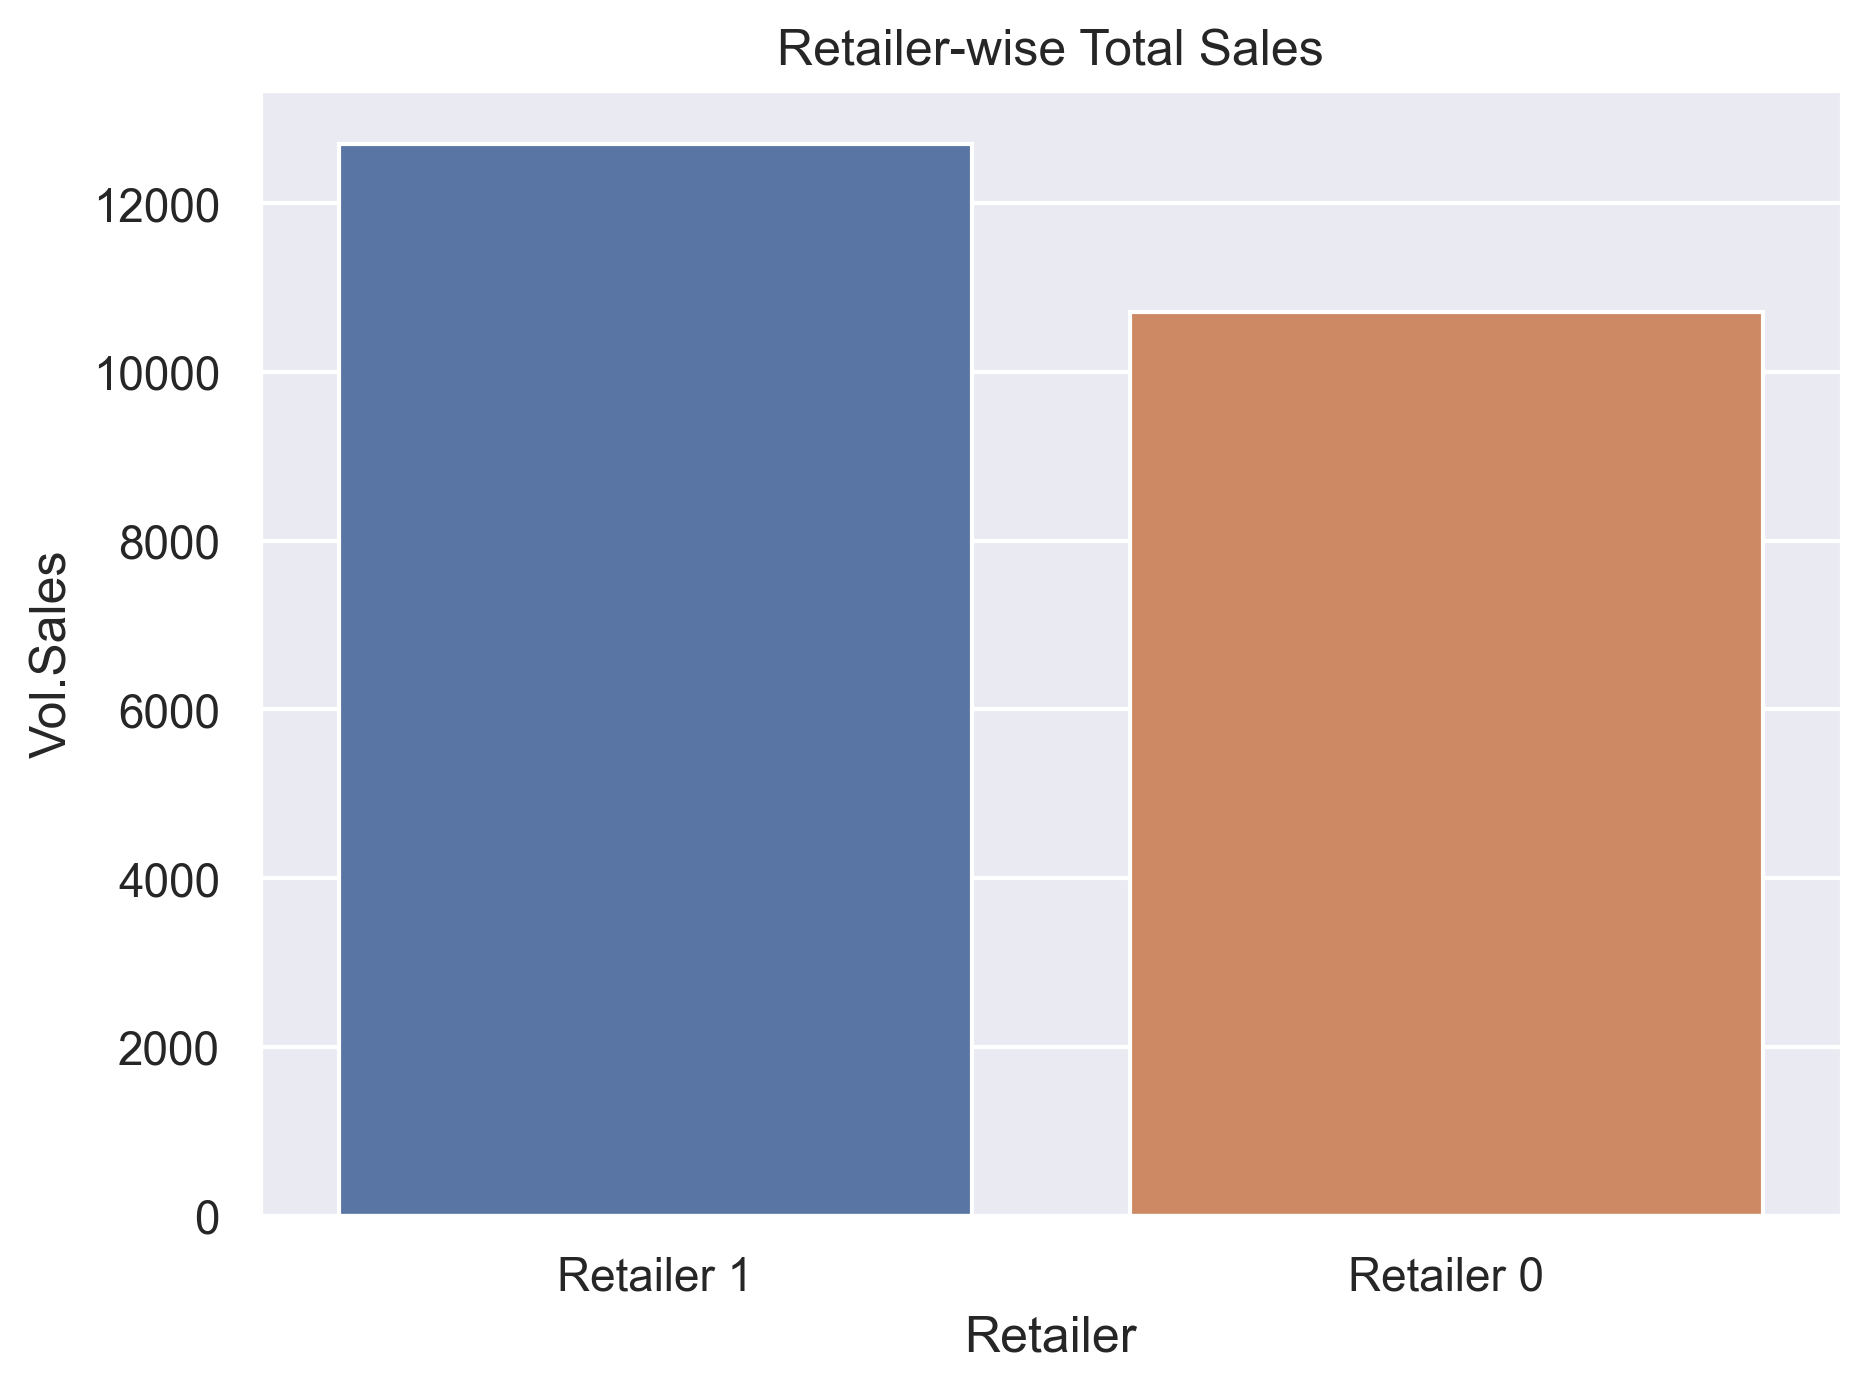

In [61]:
temp = df_inscope.copy()
temp = temp.groupby(['Retailer']).agg({'Vol.Sales':'sum'}).reset_index()
temp.sort_values('Vol.Sales', inplace=True, ascending=False)
sns.barplot(temp['Retailer'],temp['Vol.Sales'])
plt.title('Retailer-wise Total Sales')
plt.tight_layout();

if overwrite_permission:
    plt.savefig(f"{eda_plots}\Retailerwise_Total_Sales.png")

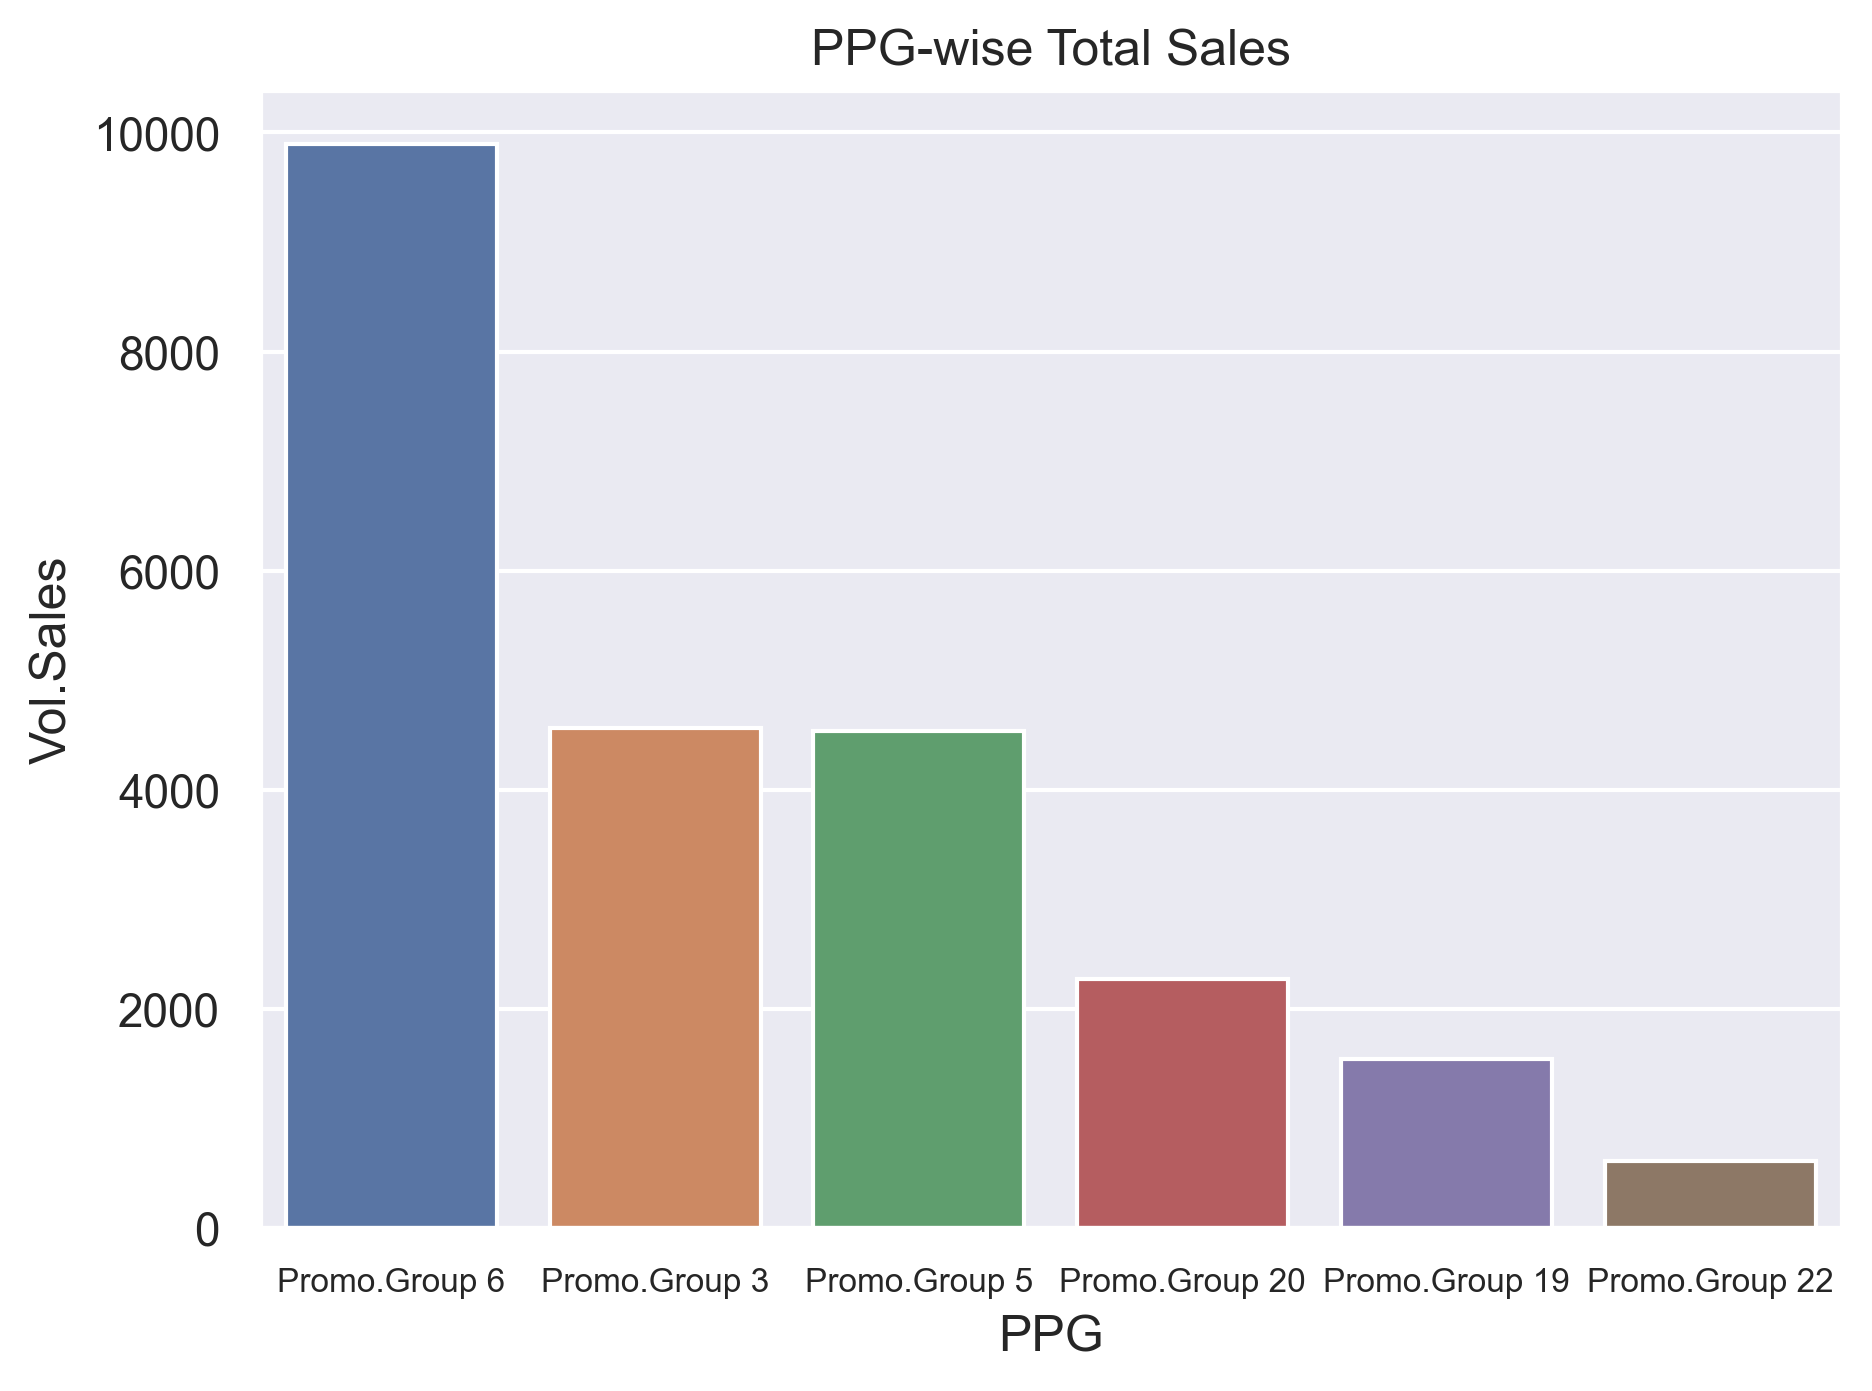

In [62]:
temp = df_inscope.copy()
temp = temp.groupby(['PPG']).agg({'Vol.Sales':'sum'}).reset_index()
temp.sort_values('Vol.Sales', inplace=True, ascending=False)
sns.barplot(temp['PPG'],temp['Vol.Sales'])
plt.xticks(rotation=0, fontsize=8)
plt.title('PPG-wise Total Sales')
plt.tight_layout();

if overwrite_permission:
    plt.savefig(f"{eda_plots}\PPGwise_Total_Sales.png")

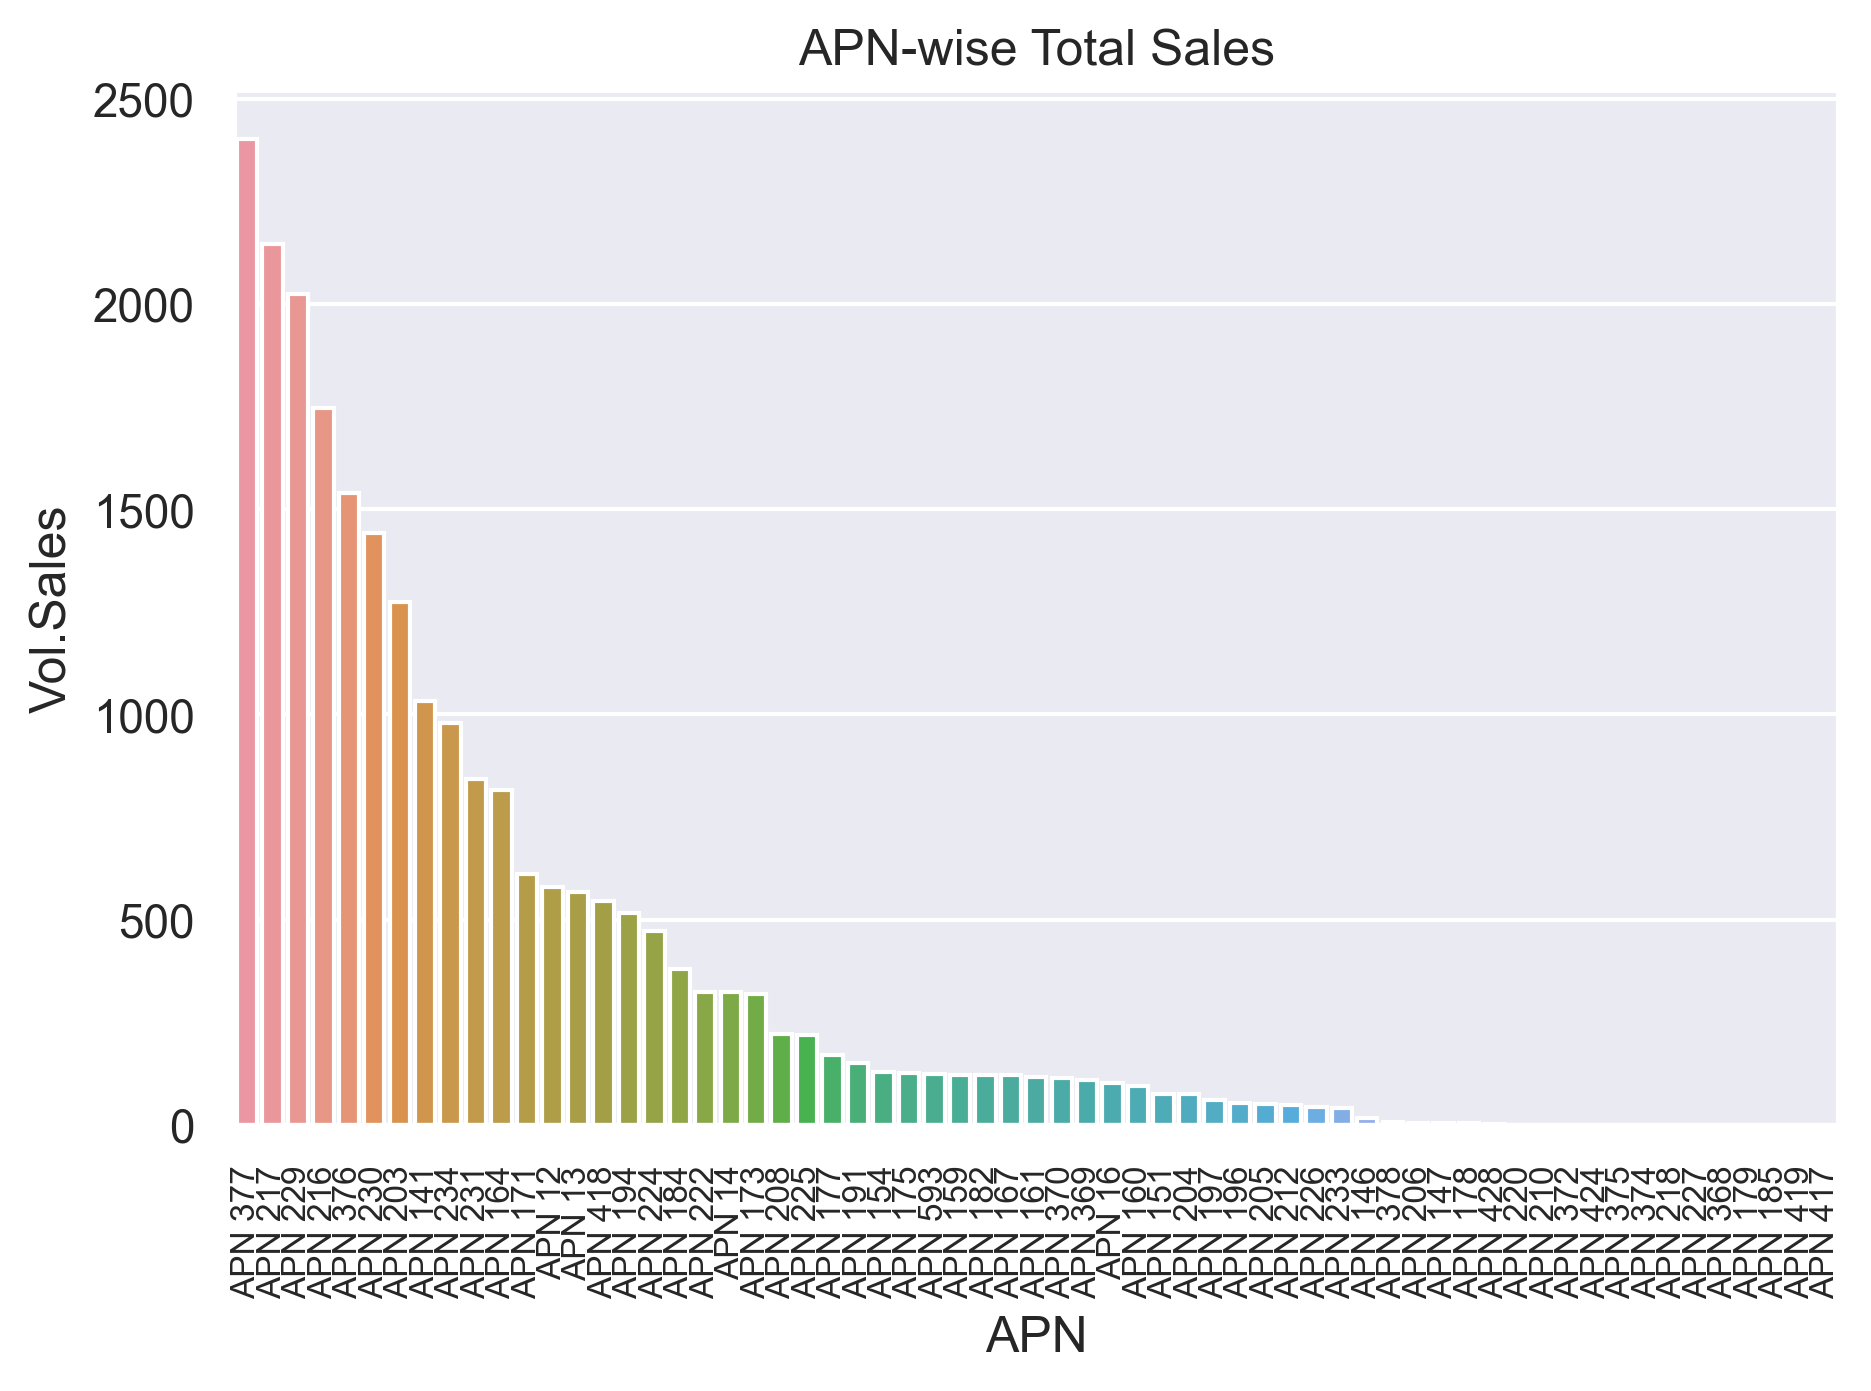

In [63]:
temp = df_inscope.copy()
temp = temp.groupby(['APN']).agg({'Vol.Sales':'sum'}).reset_index()
temp.sort_values('Vol.Sales', inplace=True, ascending=False)
temp = temp[temp['Vol.Sales'] > 0]
sns.barplot(temp['APN'],temp['Vol.Sales'])
plt.xticks(rotation=90, fontsize=8)
plt.title('APN-wise Total Sales')
plt.tight_layout();

if overwrite_permission:
    plt.savefig(f"{eda_plots}\APNwise_Total_Sales.png")

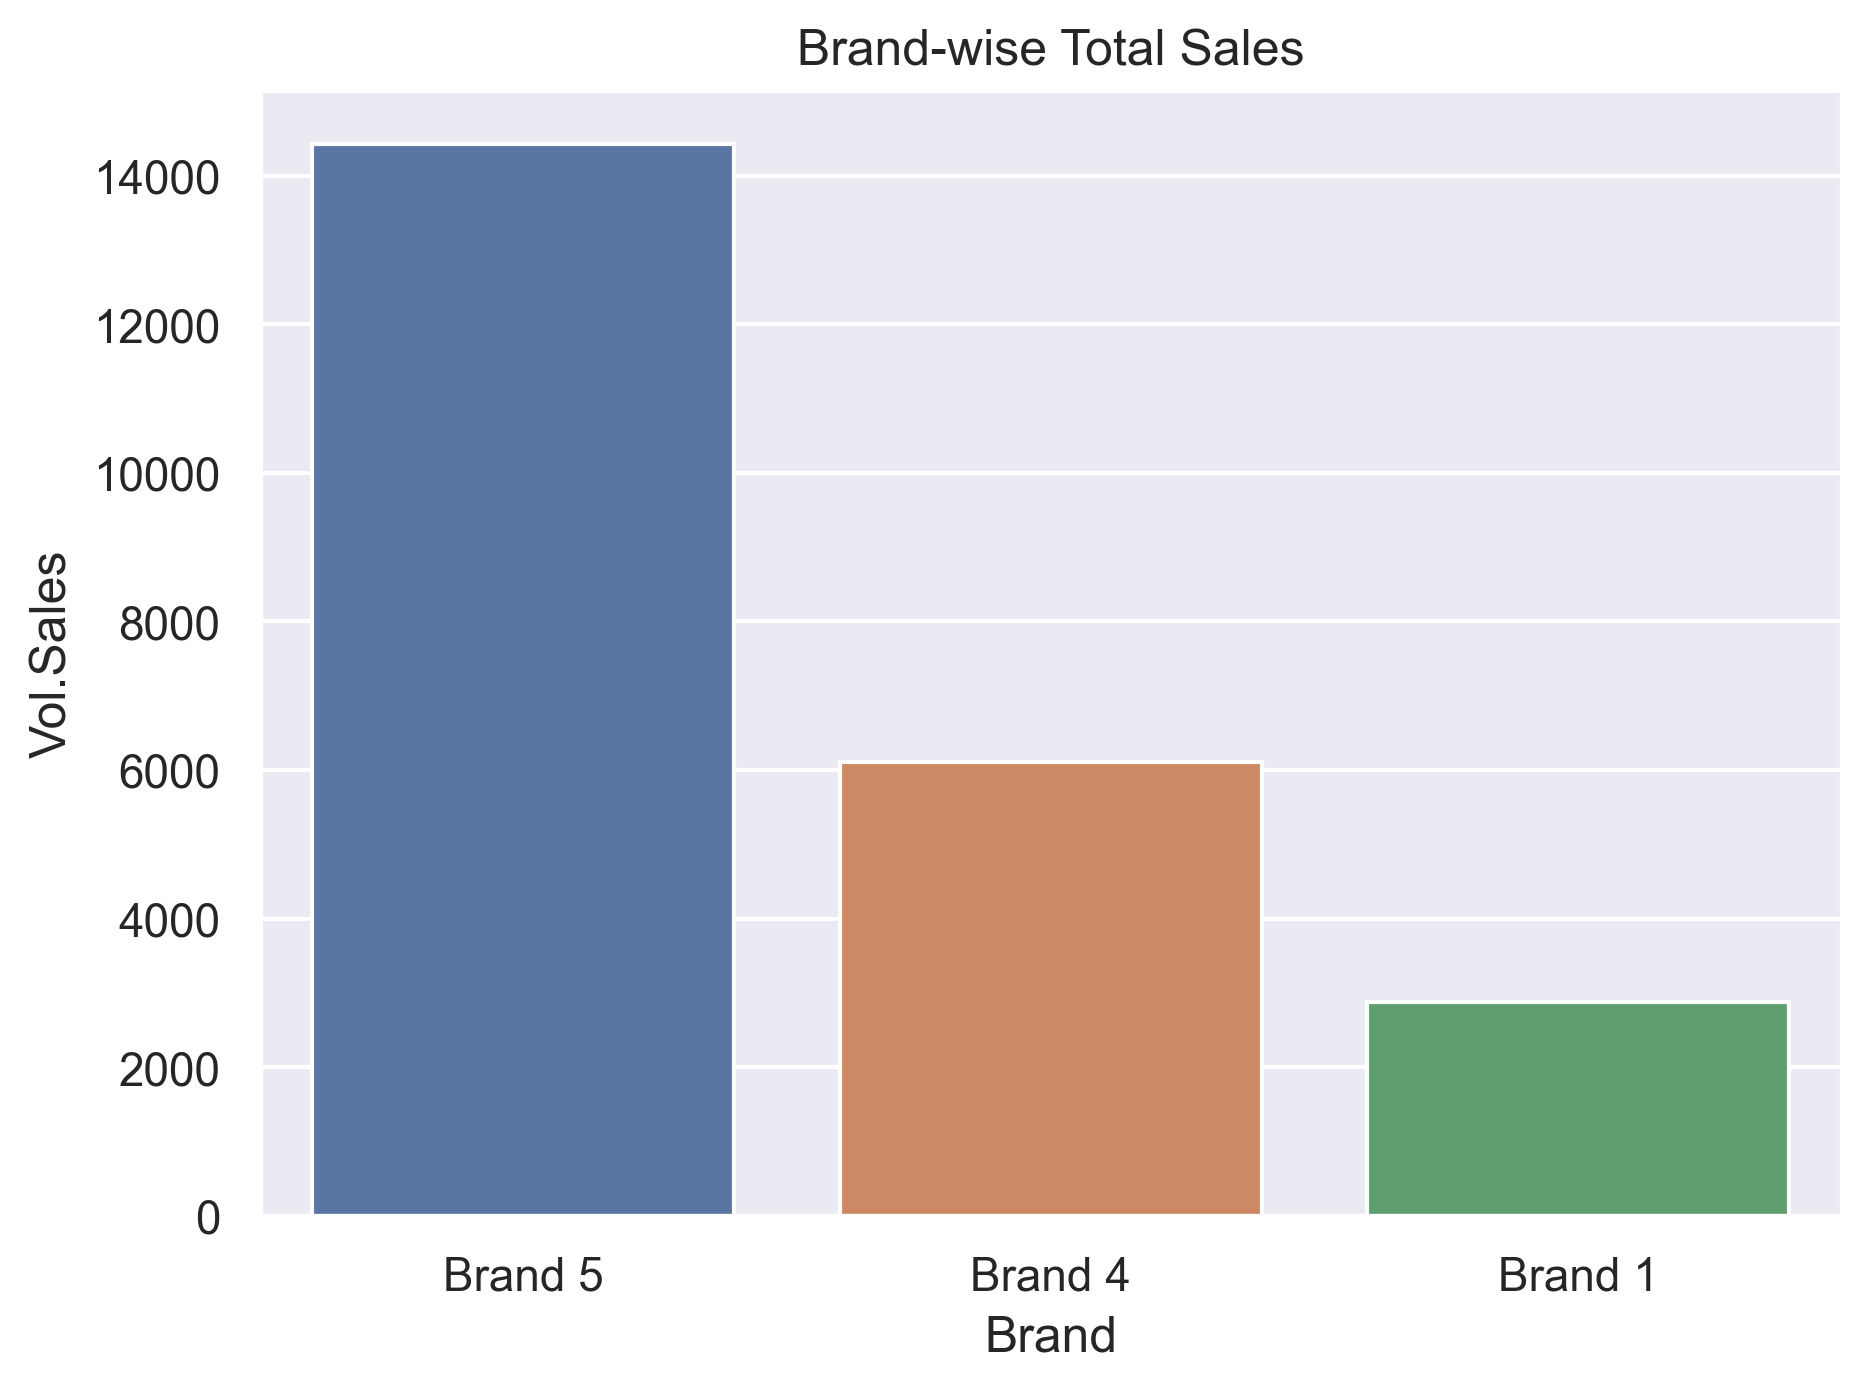

In [64]:
temp = df_inscope.copy()
temp = temp.groupby(['Brand']).agg({'Vol.Sales':'sum'}).reset_index()
temp.sort_values('Vol.Sales', inplace=True, ascending=False)
sns.barplot(temp['Brand'],temp['Vol.Sales'])
plt.title('Brand-wise Total Sales')
plt.tight_layout();

if overwrite_permission:
    plt.savefig(f"{eda_plots}\Brandwise_Total_Sales.png")

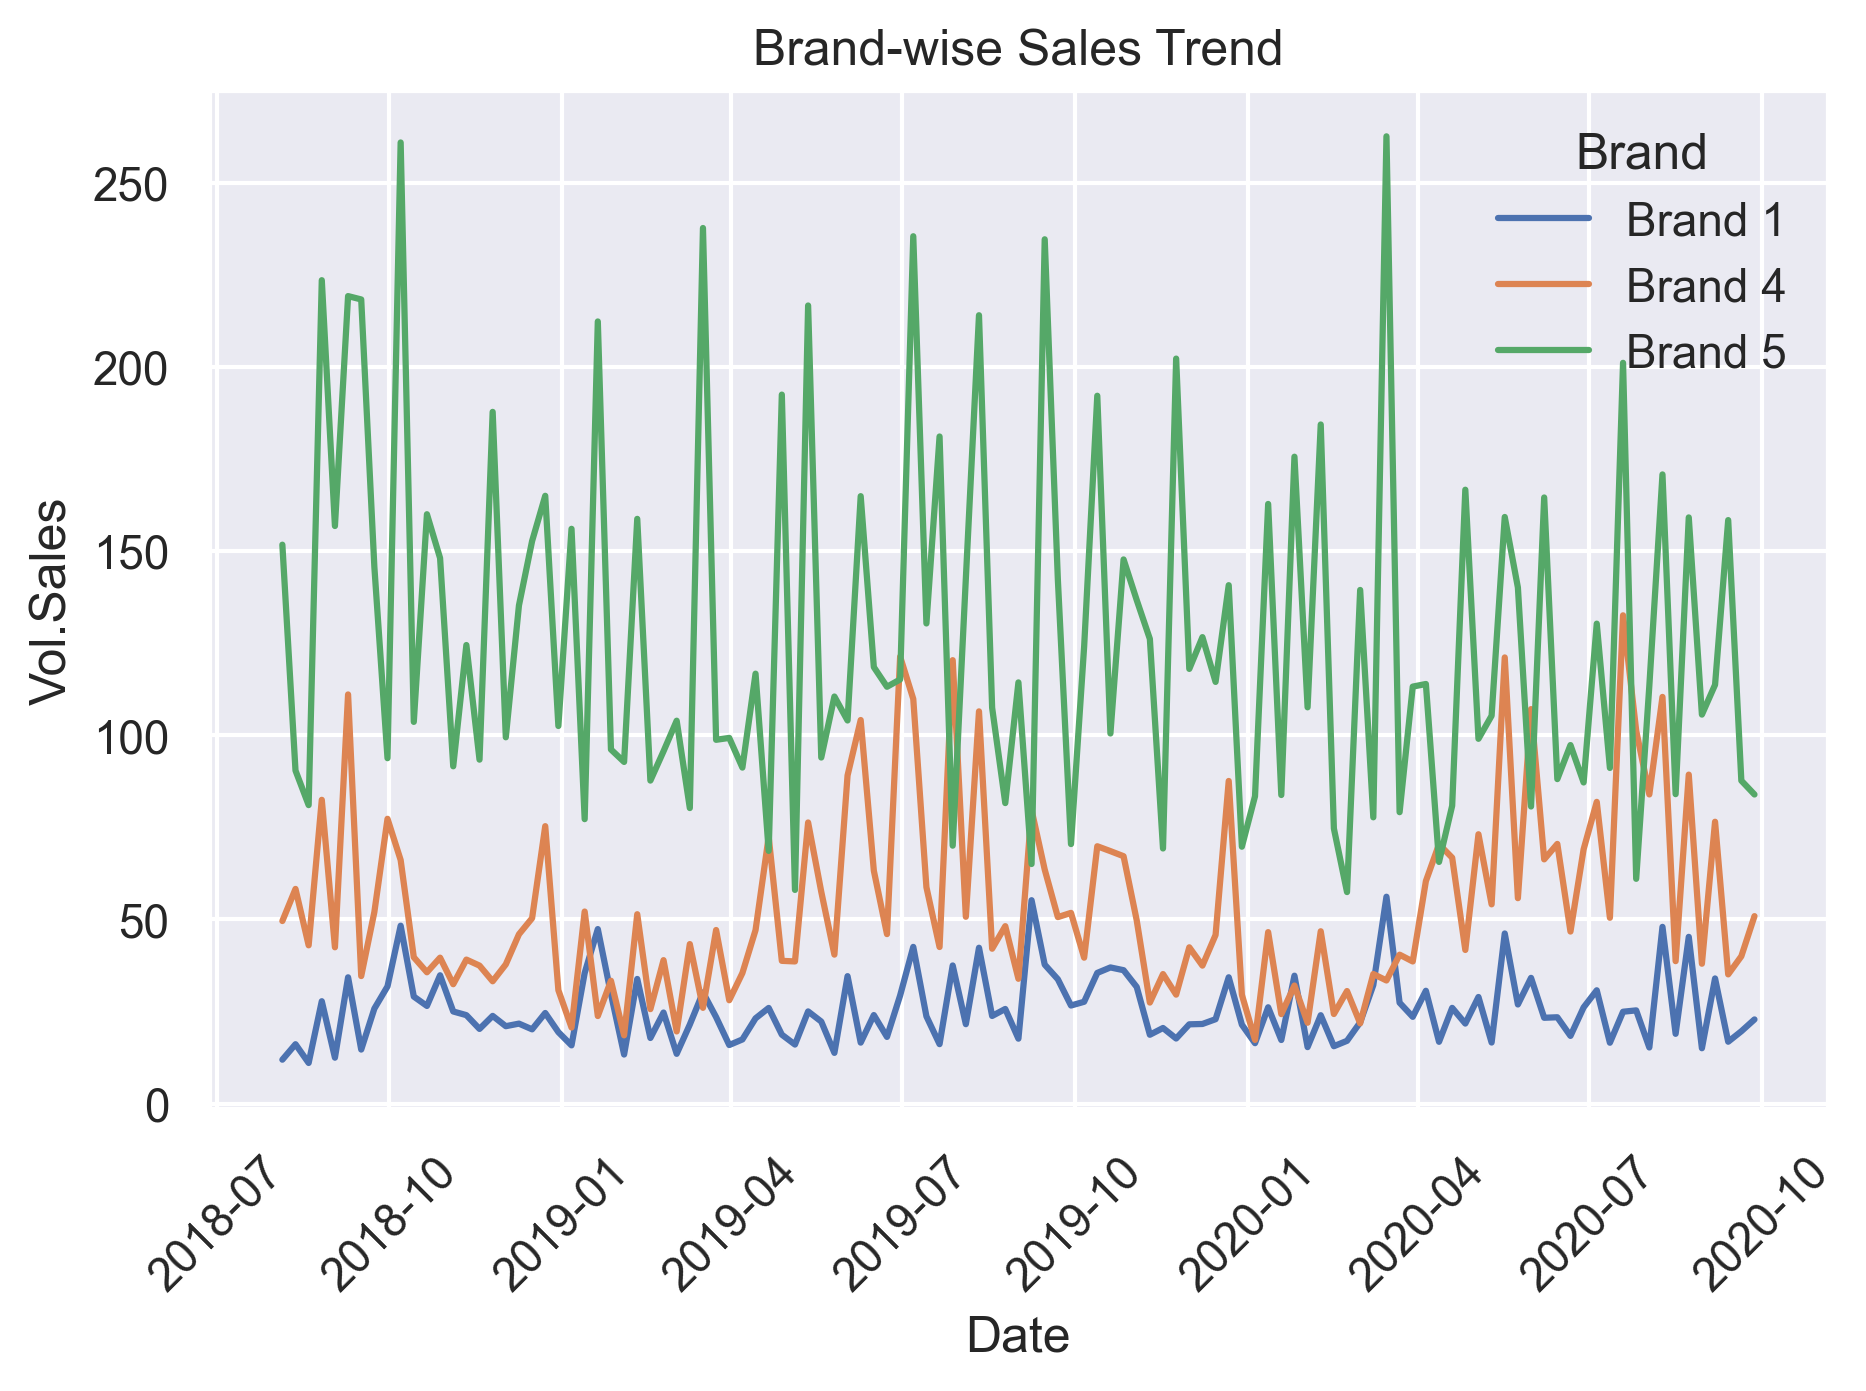

In [65]:
temp = df_inscope.groupby(['Date','Brand']).agg({'Vol.Sales':'sum'}).reset_index()
temp.sort_values('Date', inplace=True)
sns.lineplot(x=temp['Date'],y=temp['Vol.Sales'],hue=temp['Brand'])
plt.xticks(rotation=45)
plt.title('Brand-wise Sales Trend')
plt.tight_layout();

if overwrite_permission:
    plt.savefig(f"{eda_plots}\Brandwise_Sales_Trend.png")

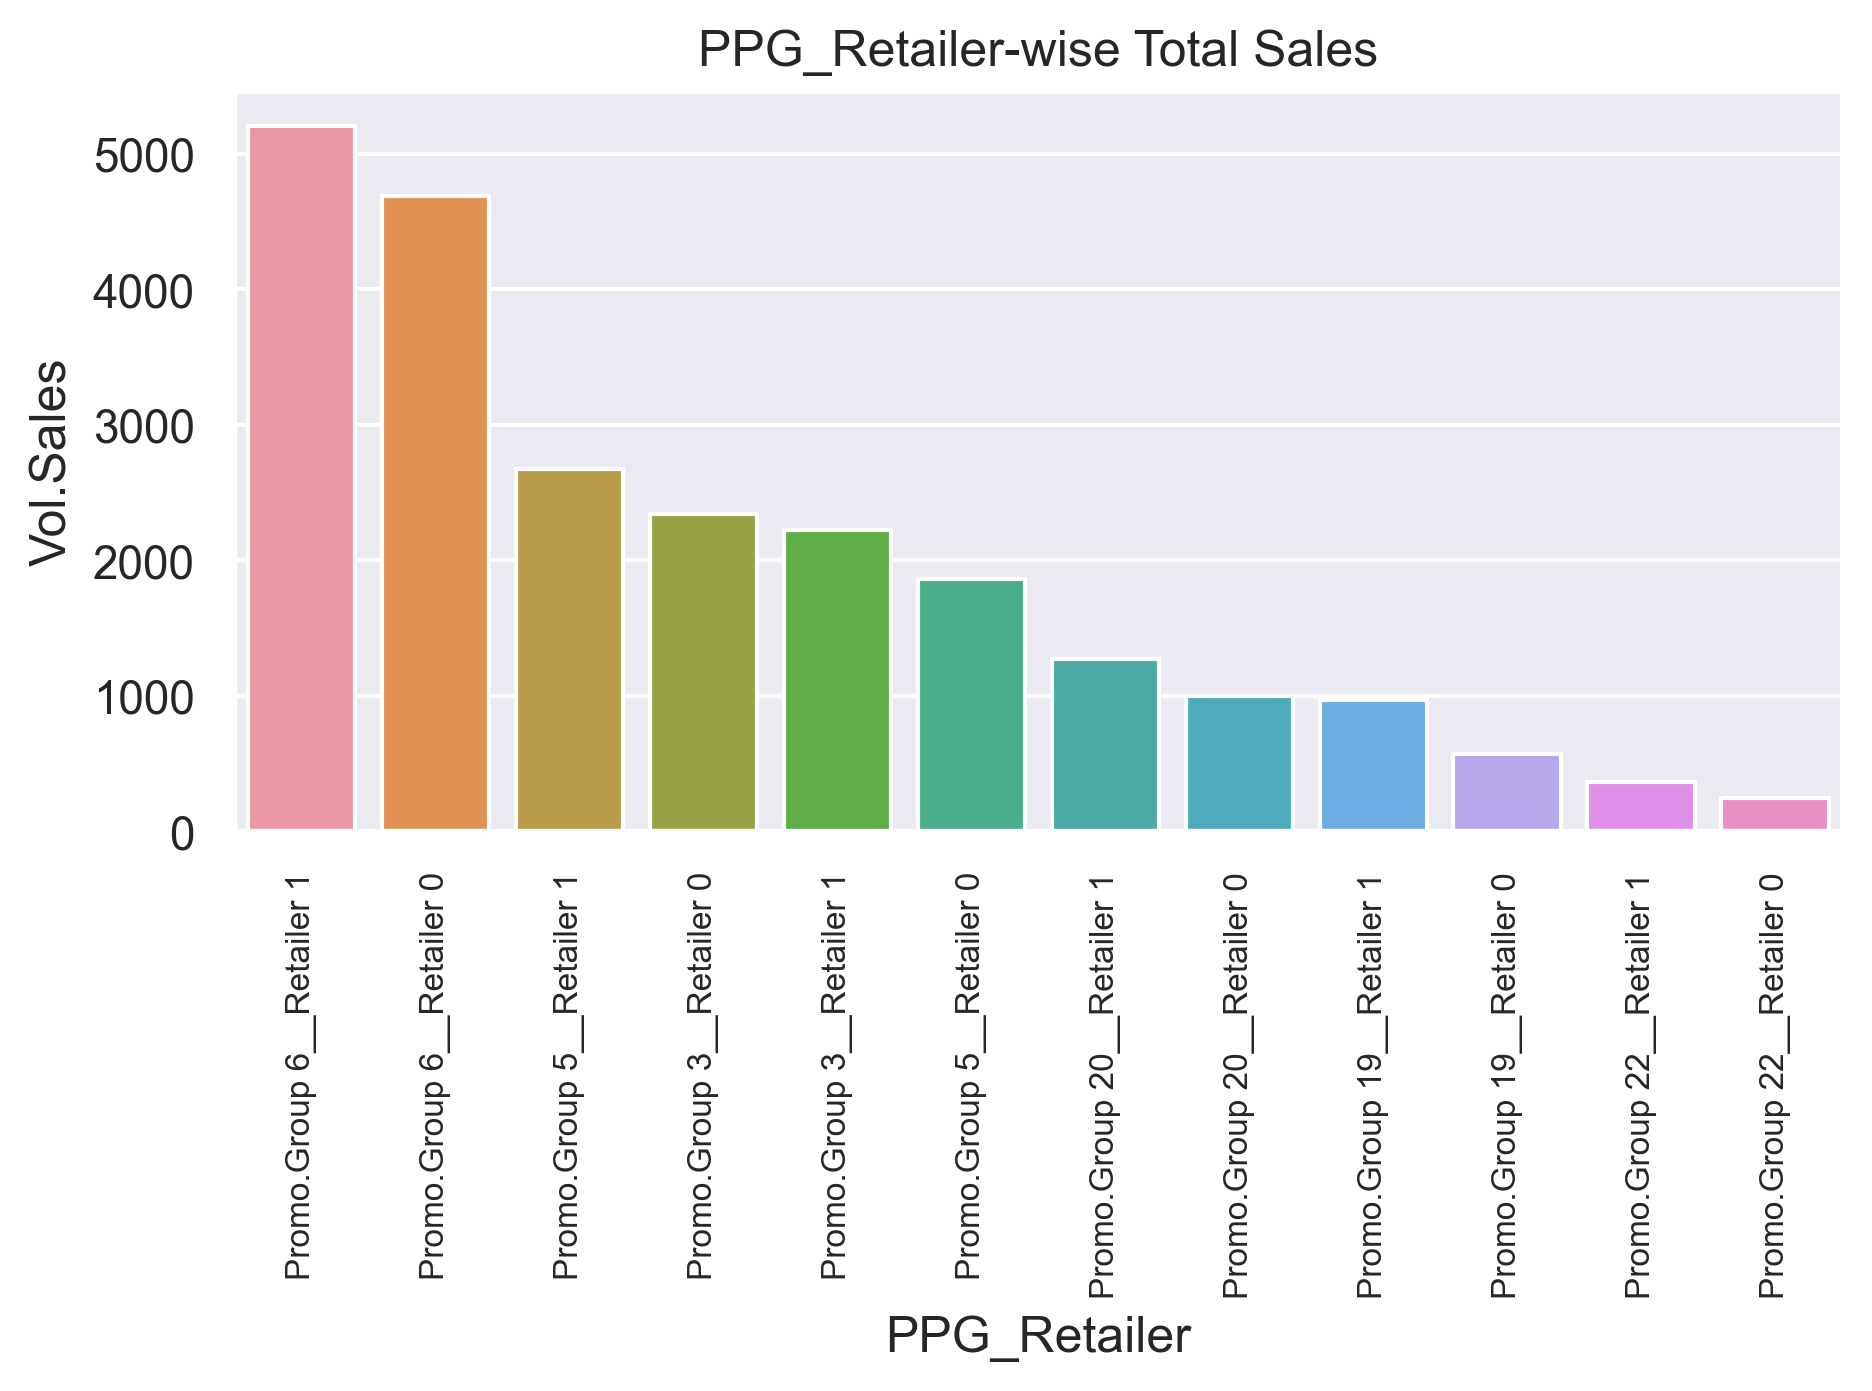

In [66]:
temp = df_inscope.copy()
temp = temp.groupby(['PPG_Retailer']).agg({'Vol.Sales':'sum'}).reset_index()
temp.sort_values('Vol.Sales', inplace=True, ascending=False)
sns.barplot(temp['PPG_Retailer'],temp['Vol.Sales'])
plt.xticks(rotation=90, fontsize=8)
plt.title('PPG_Retailer-wise Total Sales')
plt.tight_layout();

if overwrite_permission:
    plt.savefig(f"{eda_plots}\PPG_Retailerwise_Total_Sales.png")

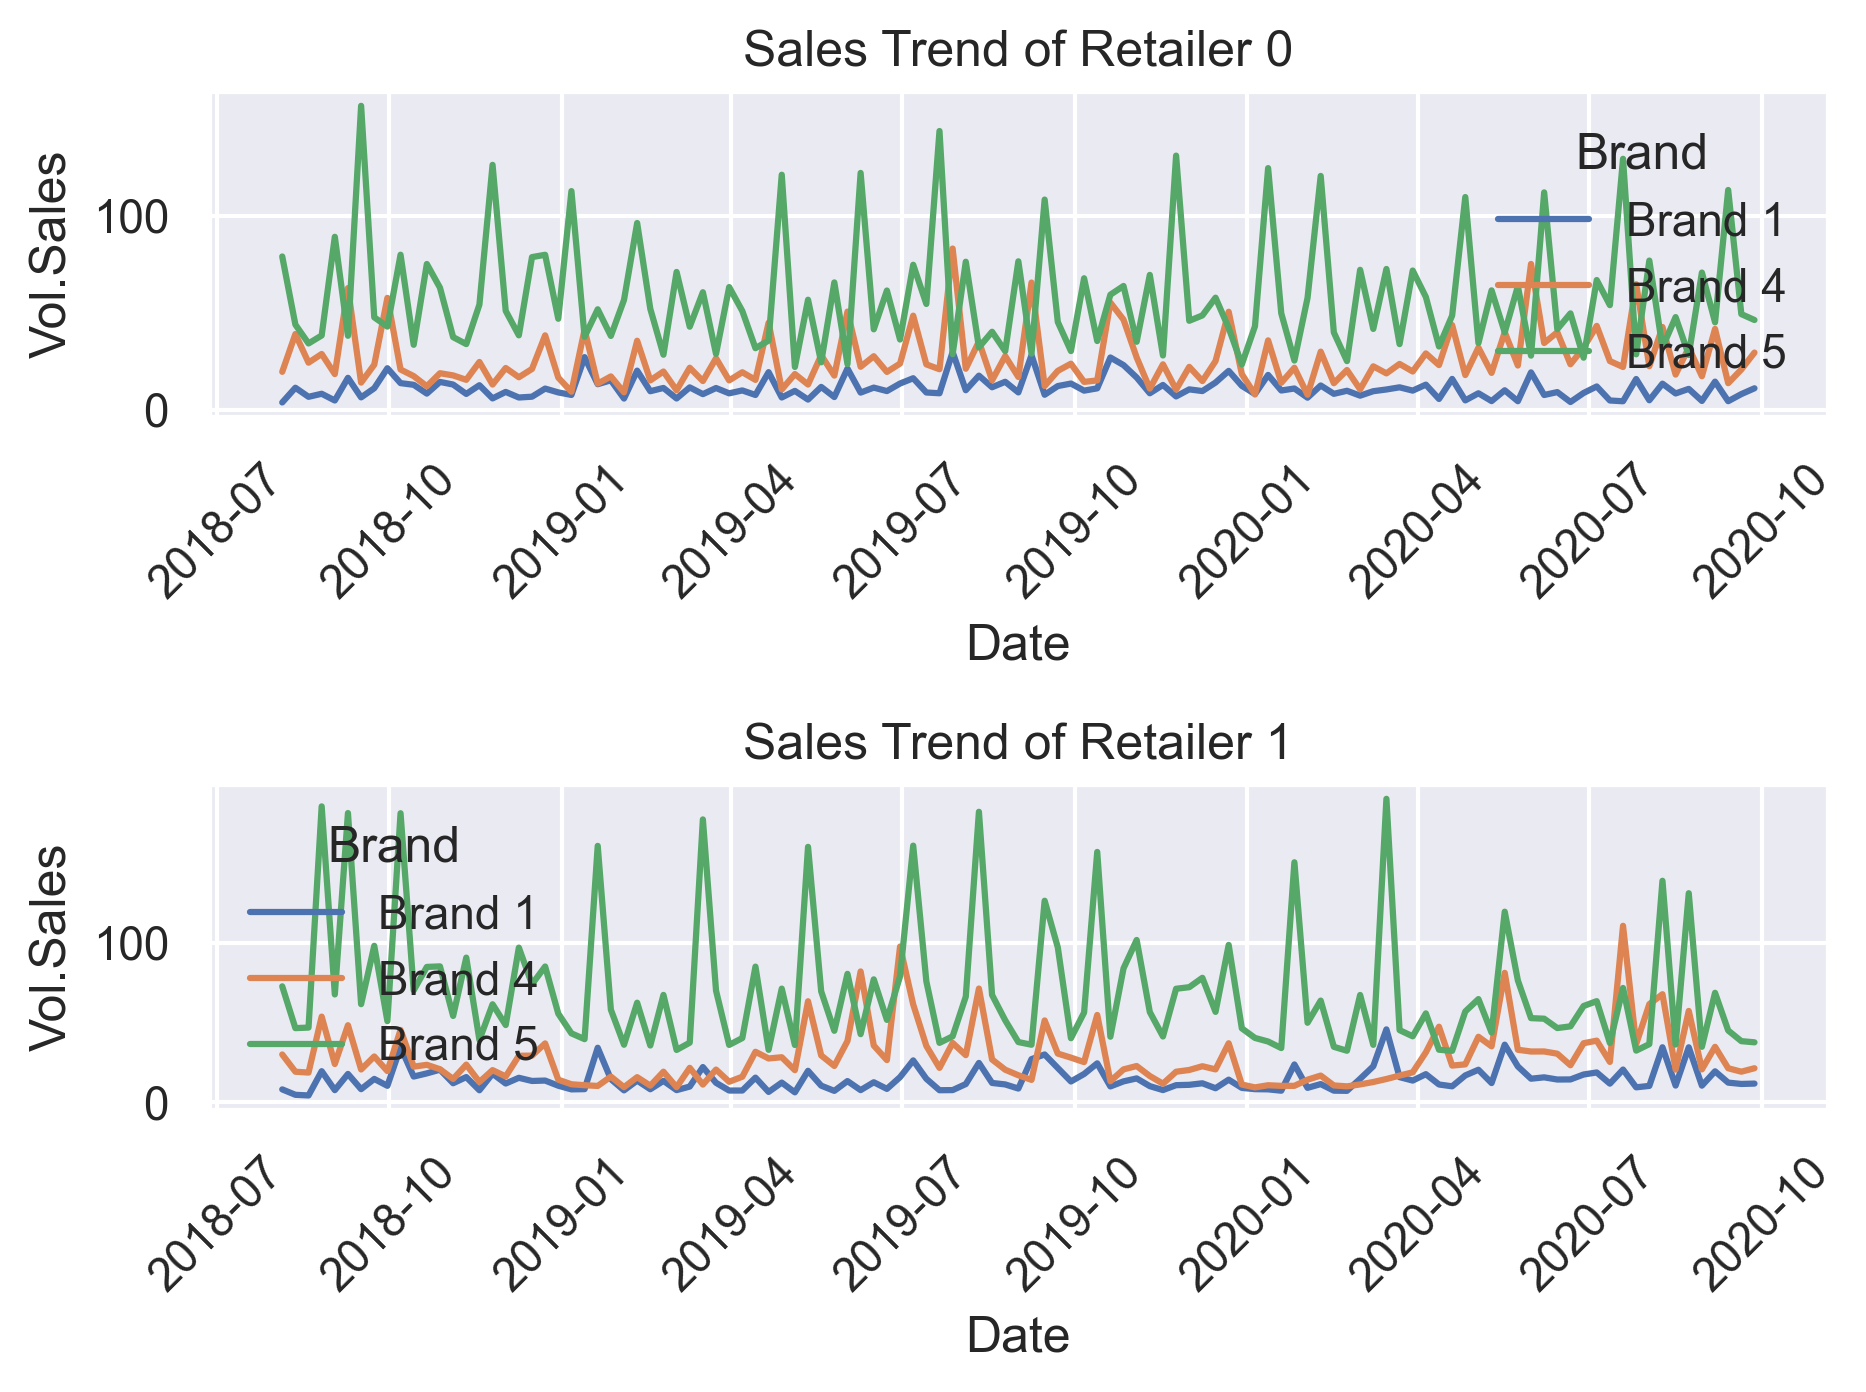

In [67]:
temp = df_inscope.groupby(['Date','Retailer','Brand']).agg({'Vol.Sales':'sum'}).reset_index()

#Retailer 0:
plt.subplot(2, 1, 1)
temp1 = temp[temp.Retailer=='Retailer 0']
temp1.sort_values('Date', inplace=True)
sns.lineplot(x=temp1['Date'],y=temp1['Vol.Sales'],hue=temp1['Brand'])
plt.xticks(rotation=45)
plt.title('Sales Trend of Retailer 0');

#Retailer 1:
plt.subplot(2, 1, 2)
temp2 = temp[temp.Retailer=='Retailer 1']
temp2.sort_values('Date', inplace=True)
sns.lineplot(x=temp2['Date'],y=temp2['Vol.Sales'],hue=temp2['Brand'])
plt.xticks(rotation=45)
plt.title('Sales Trend of Retailer 1');

plt.tight_layout();

if overwrite_permission:
    plt.savefig(f"{eda_plots}\Retailerwise_Brandwise_Sales_Trend.png")

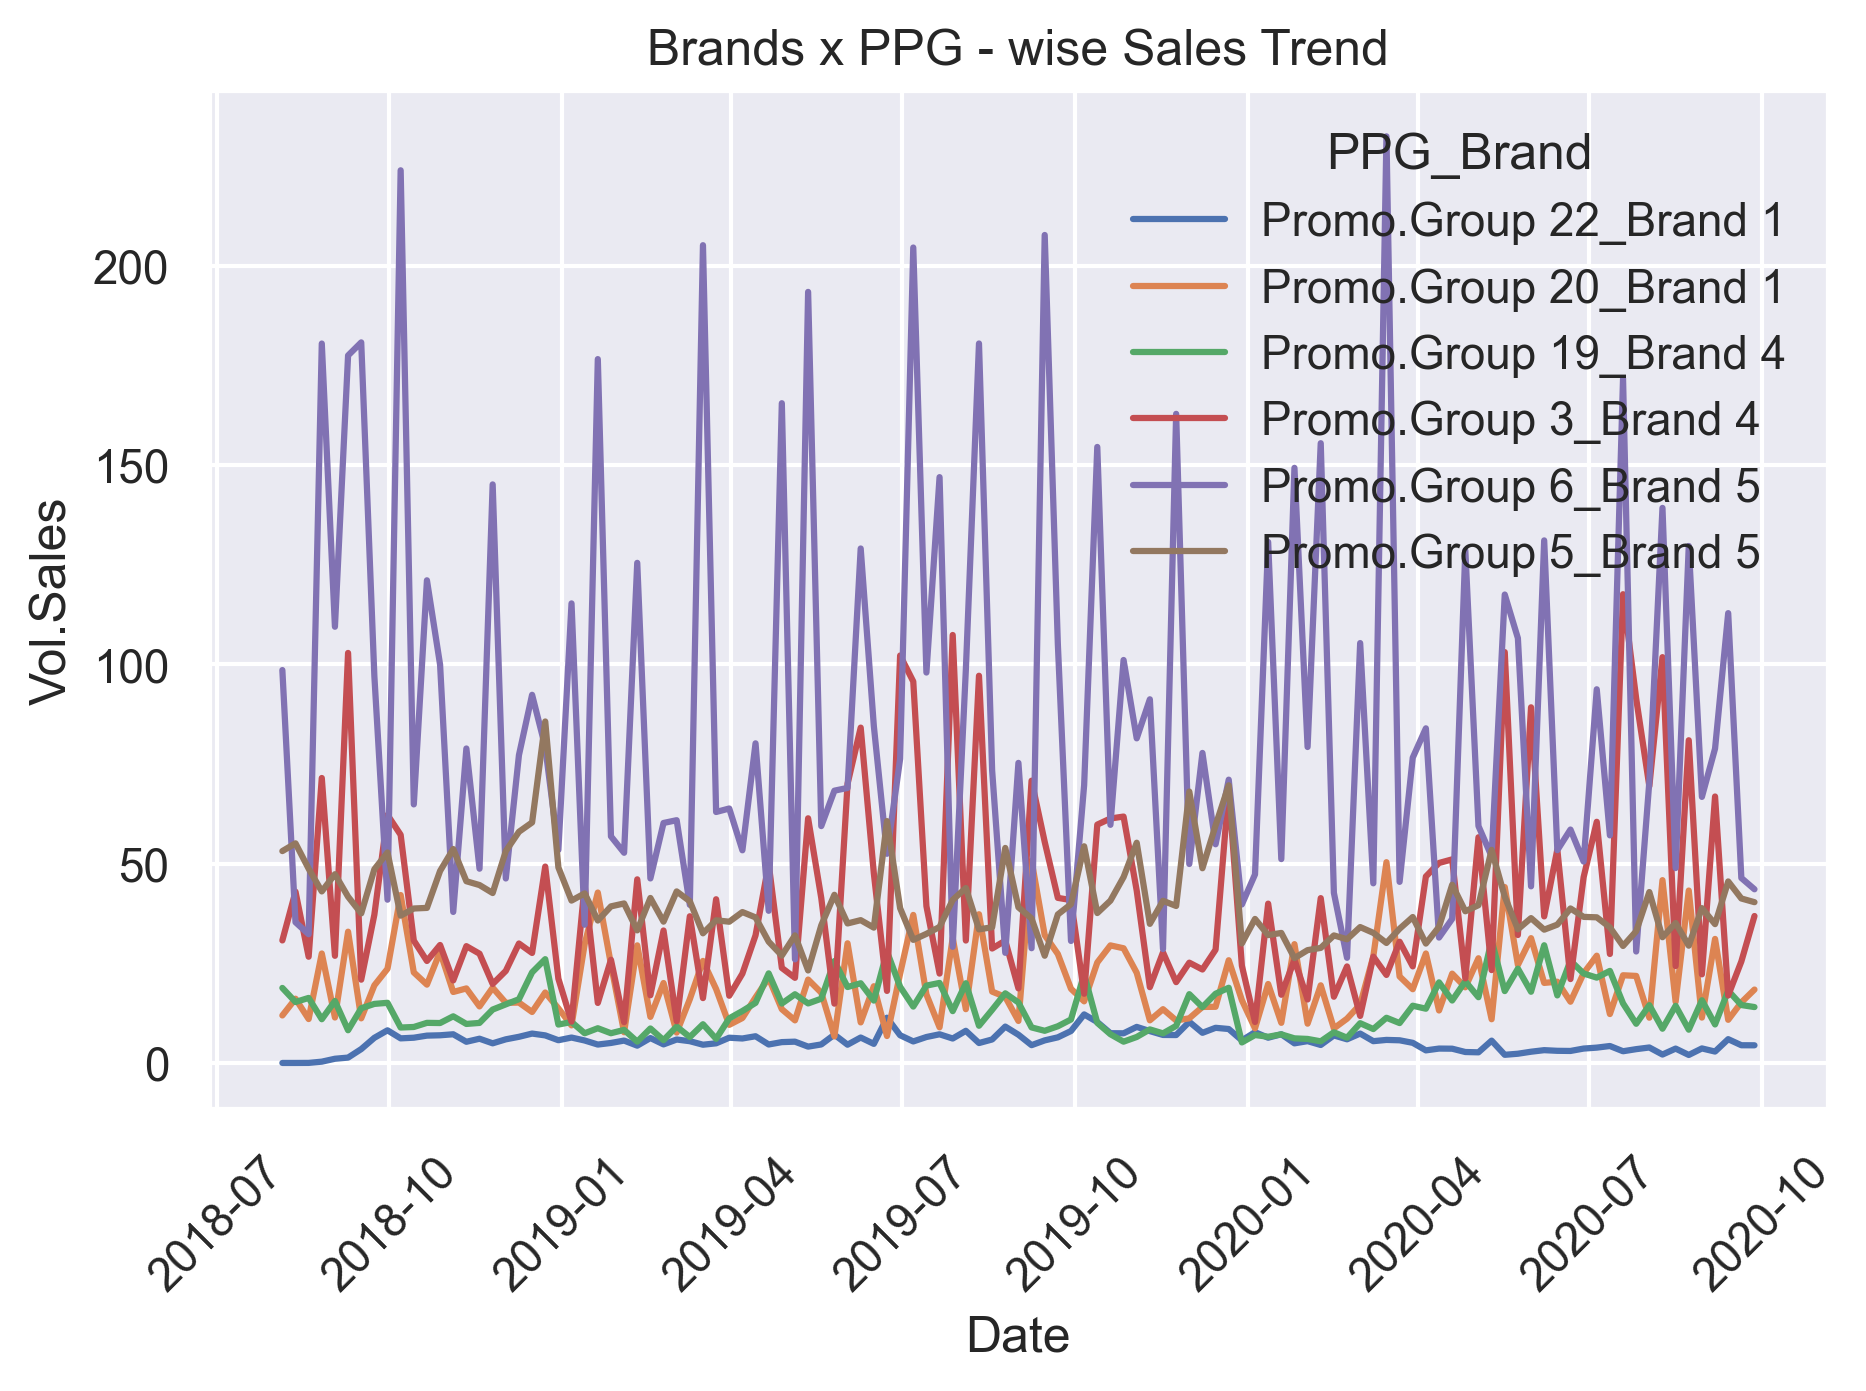

In [68]:
temp = df_inscope.groupby(['Date','PPG','Brand']).agg({'Vol.Sales':'sum'}).reset_index().sort_values(by=['Vol.Sales'],ascending=[False])
temp['PPG_Brand'] = temp['PPG'] + '_' + temp['Brand']
temp.sort_values('Date', inplace=True)
sns.lineplot(x=temp['Date'],y=temp['Vol.Sales'],hue=temp['PPG_Brand'])
plt.xticks(rotation=45)
plt.title('Brands x PPG - wise Sales Trend')
plt.tight_layout();

if overwrite_permission:
    plt.savefig(f"{eda_plots}\BrandsxPPG_wise_Sales_Trend.png")

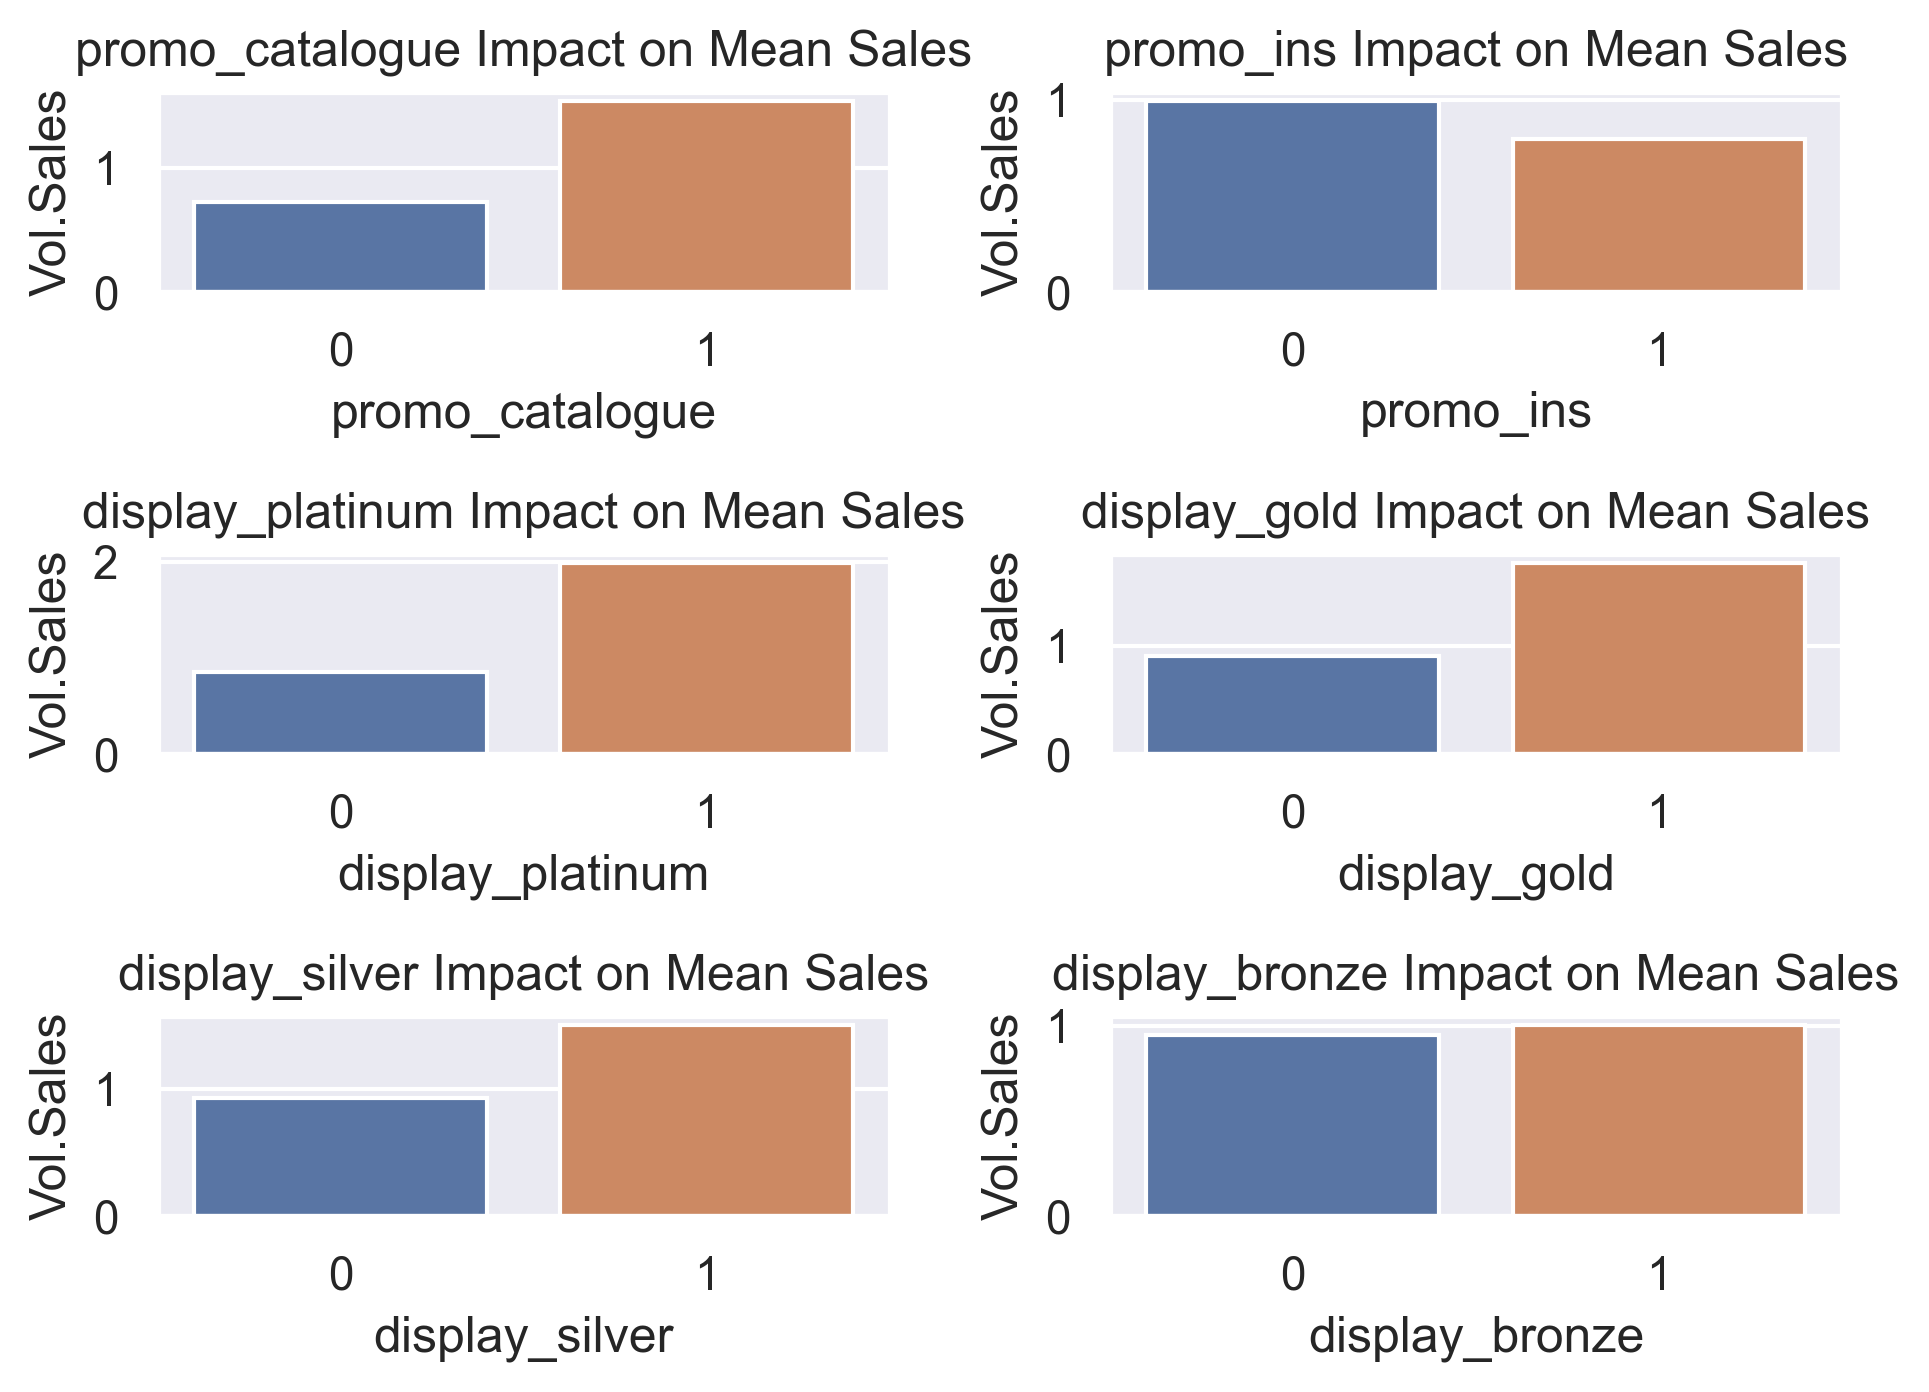

In [69]:
for i in range(1, 7):
    plt.subplot(3,2,i)
    temp = df_inscope.copy()
    temp = temp.groupby(binary_cols[i-1]).agg({'Vol.Sales':'mean'}).reset_index()
    # temp.sort_values('Vol.Sales', inplace=True, ascending=False)
    sns.barplot(temp[binary_cols[i-1]],temp['Vol.Sales'])
    plt.title(f'{binary_cols[i-1]} Impact on Mean Sales');

plt.tight_layout();
if overwrite_permission:
    plt.savefig(f"{eda_plots}\Promotional_Activities_Impact_on_Mean_Sales.png")

### Sparsity

In [70]:
# function to check 4 different types of sparsities (% of zeros) in the given dataset
def checking_sparsity_levels(df):

    n = df.shape[0]
    promo_sparsity = np.round(100 * (df[promo_cols].sum(axis=1) == 0).sum() / n, 2)
    display_sparsity = np.round(100 * (df[display_cols].sum(axis=1) == 0).sum() / n, 2)
    promotional_activity_sparsity = np.round(100 * (df[binary_cols].sum(axis=1) == 0).sum() / n, 2)
    sales_sparsity = np.round(100 * (df[target_feature] == 0).sum() / n, 2)

    return promo_sparsity, display_sparsity, promotional_activity_sparsity, sales_sparsity

In [71]:
print("The promo_sparsity, display_sparsity, promotional_activity_sparsity, sales_sparsity are respectively")
checking_sparsity_levels(df_inscope)

The promo_sparsity, display_sparsity, promotional_activity_sparsity, sales_sparsity are respectively


(52.79, 65.07, 50.75, 70.72)

### Creating PPG x Retailer - wise datasets

In [72]:
ppg_retailer = df_inscope['PPG_Retailer'].unique()

# creating the folder for datasets if it did not exist already
if ppg_retailer_raw_datasets not in os.listdir():
    os.mkdir(ppg_retailer_raw_datasets)

if overwrite_permission:
    for ppg_ret in ppg_retailer:
        temp = df_inscope[df_inscope['PPG_Retailer'] == ppg_ret]
        filepath = f"{ppg_retailer_raw_datasets}\{ppg_ret}.csv"
        temp.to_csv(filepath, index=False)

### Cannibalization Data

In [73]:
ppg_retailer = df_inscope['PPG_Retailer'].unique()

# creating the folder for datasets if it did not exist already
if ppg_retailer_within_cannibalization_datasets not in os.listdir():
    os.mkdir(ppg_retailer_within_cannibalization_datasets)

# creating the folder for datasets if it did not exist already
if ppg_retailer_cross_box_cannibalization_datasets not in os.listdir():
    os.mkdir(ppg_retailer_cross_box_cannibalization_datasets)

if overwrite_permission:
    for ppg_ret in ppg_retailer:
        #Identifying within box cannibalization data for each PPG x Retailer
        retailer_name=ppg_ret[-10:]
        temp = df_inscope[(df_inscope['PPG_Retailer'].str.endswith(retailer_name))&(df_inscope['PPG_Retailer']!=ppg_ret)]
        temp=temp[['Date','promo_catalogue', 'promo_ins', 'display_platinum',
                        'display_gold', 'display_silver', 'display_bronze', 'Price','Wtd.Selling.Dist']]
        within=temp.groupby('Date').mean().reset_index()
        updated_columns = [col if col == 'Date' else f"{'within'}_{col}" for col in within.columns]
        within.columns = updated_columns
        filepath = f"{ppg_retailer_within_cannibalization_datasets}\{ppg_ret}_within.csv"
        within.to_csv(filepath, index=False)

        #Identifying cross box cannibalization data for each PPG x Retailer
        temp = df_inscope[~df_inscope['PPG_Retailer'].str.endswith(retailer_name)]
        temp=temp[['Date','promo_catalogue', 'promo_ins', 'display_platinum',
                'display_gold', 'display_silver', 'display_bronze', 'Price','Wtd.Selling.Dist']]
        cross_box=temp.groupby('Date').mean().reset_index()
        updated_columns = [col if col == 'Date' else f"{'cross_box'}_{col}" for col in cross_box.columns]
        cross_box.columns = updated_columns
        filepath = f"{ppg_retailer_cross_box_cannibalization_datasets}\{ppg_ret}_cross_box.csv"
        cross_box.to_csv(filepath, index=False)

### Data Preprocessing and Feature Engineering

In [74]:
# Loading the dependencies for data preprocessing and encoding

from category_encoders import TargetEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

##### Exercise caution while modifying the following 2 cells

In [75]:
# gathering features that needs to be dropped
remove_cols = ['PPG', 'Retailer', 'Sub.Segment', 'Sub.Brand', 'APN','WeekNum', 'Year', 'Month_Year', 'PPG_Retailer', 'Vol.Sales',]

# independent features to be used in the modelling
unprocessed_independent_features = [col for col in df_inscope.columns if col not in remove_cols]

print(f"The following independent features will be used --> {', '.join(unprocessed_independent_features)}")

The following independent features will be used --> Date, promo_catalogue, promo_ins, display_platinum, display_gold, display_silver, display_bronze, Segment, Brand, Packsize, Product.Type, Wtd.Selling.Dist, Price, Month, Quarter


In [76]:
# column segregation for encoding

one_hot_encoding_cols = ['Segment', 'Brand', 'Product.Type','Quarter','Month']
# target_encoding_cols = [ 'Month']

In [77]:
# y.head()

In [78]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

def calculate_vif(data, threshold=10.0):
    """
    Calculate VIF for features in a dataset and filter features based on the threshold.

    Parameters:
    - data: DataFrame, input dataset with numerical features
    - threshold: float, the threshold for filtering features based on VIF (default is 5.0)

    Returns:
    - selected_columns: list, column names selected based on VIF threshold
    """
    # Extract numerical features
    numerical_features = data.drop(columns=['Vol.Sales'])

    # Calculate VIF for each feature
    vif_data = pd.DataFrame()
    vif_data["Feature"] = numerical_features.columns
    vif_data["VIF"] = [variance_inflation_factor(numerical_features.values, i) for i in range(numerical_features.shape[1])]

    # Filter features based on the threshold
    selected_columns = vif_data[vif_data["VIF"] <= threshold]["Feature"].tolist()

    return selected_columns

In [79]:
# Function for data preprocessing

def data_preprocessing(df, normalize=True):

    df = df[unprocessed_independent_features + [target_feature]]
    print('Duplicates before groupby Date : ', df.duplicated(subset=unprocessed_independent_features).sum())
    
    # performing one-hot encoding
    df = pd.get_dummies(data=df, columns=one_hot_encoding_cols, drop_first=True)

    #Grouping data by Date column
    mean_values=df.drop([target_feature],axis=1).groupby(by='Date').mean().reset_index()
    total_sales = df[['Date',target_feature]].groupby(by='Date').mean().reset_index()
    df=mean_values.merge(total_sales)

    #Adding within cannibalization data
    within_cannibalization=pd.read_csv(f"{ppg_retailer_within_cannibalization_datasets}\{dataset[:-4]}_within.csv", parse_dates=['Date'])
    df=df.merge(within_cannibalization,on='Date')

    #Adding cross-box cannibalization data
    cross_cannibalization=pd.read_csv(f"{ppg_retailer_cross_box_cannibalization_datasets}\{dataset[:-4]}_cross_box.csv", parse_dates=['Date'])
    df=df.merge(cross_cannibalization,on='Date')
    df=df.drop('Date',axis=1)
    
    selected_columns = calculate_vif(df)
    required_columns=list(set(selected_columns)|set(['Wtd.Selling.Dist','Price'])|set(binary_cols))
    print('The required columns are:',required_columns)
    # X = df.drop(target_feature,axis=1)
    X = df[required_columns]
    y = df[target_feature]
    # df.drop(columns='Date', inplace=True)
    print('Duplicates after groupby Date : ', X.duplicated().sum())

    # performing the train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, shuffle=True)

    # create a TargetEncoder instance
    # encoder = TargetEncoder(cols=target_encoding_cols, return_df=True)

    # # fit and transform the training data
    # X_train = encoder.fit_transform(X_train, y_train)

    # # transforming the testing data
    # X_test = encoder.transform(X_test)

    processed_independent_features = X_train.columns # capturing the column names before we lose them in the following transformation

    
    if normalize:
        # creating a normalizer
        norm = MinMaxScaler()

        # fitting and transforming on the training data
        X_train = norm.fit_transform(X_train)

        # transforming on the testing data
        X_test = norm.transform(X_test)


    X_processed = np.vstack([X_train, X_test])
    y_processed = y_train.append(y_test, ignore_index=True)
    df_processed = pd.DataFrame(X_processed, columns=processed_independent_features)
    df_processed[target_feature] = y_processed

    return X_train, X_test, y_train, y_test, processed_independent_features, df_processed

In [80]:
# Loading the dependencies

from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, ElasticNetCV, SGDRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_absolute_percentage_error

In [81]:
def sMAPE(actual,prediction):
    return 100/len(actual) * np.sum(2 * np.abs(prediction - actual) / (np.abs(actual) + np.abs(prediction)))

In [82]:
def training_evaluation_and_weights(X_train, X_test, y_train, y_test, model, feature_list):

    if not isinstance(model, str): 
        # learning from the training dataset
        model.fit(X_train, y_train)
    
        # predicting the test data
        y_test_pred = model.predict(X_test)
    
        # performance on the training set
        train_metric = model.score(X_train, y_train)
    
        # performance on the test set
        test_metric = r2_score(y_test, y_test_pred)
        
        # sMAPE calculated on the test set
        test_smape = sMAPE(y_test, y_test_pred)
    
        # the coefficients and the constant term are
        weights, bias = model.coef_, model.intercept_
    
        if isinstance(bias, np.ndarray):
            bias = bias[0]
    
    else:
        yt = y_train
        
        # Bayesian linear regression model 
        with pm.Model() as linear_model:
            # Priors for the model parameters
            intercept = pm.Normal('intercept', mu=0, sd=10)
            mu = intercept
            for i, feat in enumerate(feature_list):
                # CROSS CHECK THIS
                if 'within_price' in feat.lower() or 'cross_box_price' in feat.lower(): 
                    slope = pm.Normal(feat, mu=40, sd=10)
                elif 'within_' in feat.lower() or 'cross_box' in feat.lower() or 'price' in feat.lower(): 
                    slope = pm.Normal(feat, mu=-40, sd=10)
                elif 'display_' in feat.lower() or 'promo_' in feat.lower():
                    slope = pm.Normal(feat, mu=40, sd=10)
                else:
                    slope = pm.Normal(feat, mu=0, sd=10)
                mu += slope * X_train[:,i]   
                
            # Likelihood of the observations
            likelihood = pm.Normal('yt', mu=mu, sd=1, observed=yt)
        
            # Sample from the posterior distribution using NUTS
            trace = pm.sample(draws=draws, tune=tune, cores=-1)  # Adjust the number of samples and tuning steps as needed
        
            map_estimate = pm.find_MAP()

            # the coefficients and the constant term are
            weights, bias = np.array([map_estimate[feat].reshape(1,)[0] for feat in feature_list]), map_estimate['intercept'].reshape(1,)[0]

            # predicting the train data
            y_train_pred = np.dot(X_train, weights) + bias
            
            # predicting the test data
            y_test_pred = np.dot(X_test, weights) + bias
            
            # performance on the training set
            train_metric = r2_score(y_train, y_train_pred)
        
            # performance on the test set
            test_metric = r2_score(y_test, y_test_pred)
            
            # sMAPE calculated on the test set
            test_smape = sMAPE(y_test, y_test_pred)

    current_row = [dataset[:-4], modelname, train_metric, test_metric, test_smape, *weights, bias]

    model_coeffs = pd.DataFrame()
    model_coeffs['features'] = feature_list
    model_coeffs['coeffs'] = weights
    model_coeffs['|coeffs|'] = np.abs(model_coeffs['coeffs'])
    model_coeffs.sort_values('|coeffs|', ascending=False, inplace=True)
    topfeat = list(model_coeffs['features'].values[:topK])

    current_row.append(', '.join(topfeat))

    return current_row, weights, bias

In [83]:
# Can extend the list to accomadate other parametric models

models = {'LinearRegression' : LinearRegression(n_jobs=-1),
          'SGDRegression' : SGDRegressor(),
          'LassoRegression' : LassoCV(alphas=np.logspace(-4,2,100), cv=5, n_jobs=-1),
          'RidgeRegression' : RidgeCV(alphas=np.logspace(-4,2,100), cv=5),
          'BayesianRegression' : 'BayesianRegression'}

if impose_positive_constraint:
    positive_models = {'LinearRegression_Positive' : LinearRegression(positive=impose_positive_constraint, n_jobs=-1),
                       'LassoRegression_Positive' : LassoCV(alphas=np.logspace(-4,2,100), cv=5, positive=impose_positive_constraint, n_jobs=-1),
                       'ElasticNetRegression_Positive' : ElasticNetCV(l1_ratio=np.logspace(-10,0,21), alphas=np.logspace(-4,2,100), cv=5,
                                                             positive=impose_positive_constraint, n_jobs=-1)}

    models.update(positive_models)

The feature list of all the different datasets need not be same. For instance, they can vary particularly w.r.t to 'Segment' and 'Product.Type'

In [84]:
# creating the necessary folders if it did not exist already
if ppg_retailer_processed_datasets not in os.listdir():
    os.mkdir(ppg_retailer_processed_datasets)
if ppg_retailer_metrics_weights not in os.listdir():
    os.mkdir(ppg_retailer_metrics_weights)
if ppg_retailer_contributions not in os.listdir():
    os.mkdir(ppg_retailer_contributions)
if ppg_retailer_contributions_percent not in os.listdir():
    os.mkdir(ppg_retailer_contributions_percent)
if final_report_folder not in os.listdir():
    os.mkdir(final_report_folder)

##### Exercise caution if you are modifying the following cell

In [85]:
all_models_performance = list()  # to save the performance and details of the dataset on which the model is trained
all_models_relative_contribution_of_promotional_activity = list() # to save the relative percent contribution of 6 promotional activities

# iterating over all the dataset variants
for dataset in os.listdir(ppg_retailer_raw_datasets):

    df = pd.read_csv(f"{ppg_retailer_raw_datasets}\{dataset}", parse_dates=['Date'])
    
    X_train, X_test, y_train, y_test, feature_list, df_processed = data_preprocessing(df) # processing the data ready for modelling
    print(f'In the dataset {dataset[:-4]}, Dates are continuous : ', checking_Data_continuity(df), '\n')
    sparsities = checking_sparsity_levels(df)
    if overwrite_permission:
        df_processed.to_csv(f"{ppg_retailer_processed_datasets}\{dataset[:-4]}_Processed.csv", index=False) # saving the processed datasets

    current_model_details = list()
    current_model_columns = ['PPG_Retailer_Variant', 'Model', 'Train_r2', 'Test_r2', 'Test_sMAPE',*feature_list, 'Constant', f'Top{topK}_most_important_features']
    current_model_contribution_percent = list()

    # iterating over all the model variants
    for modelname in models.keys():
        model = models[modelname]
        current_row, weights, bias = training_evaluation_and_weights(X_train, X_test, y_train, y_test, model, feature_list) # model training
        current_model_details.append(current_row)
        all_models_performance.append(current_row[:5] + [*df_processed.shape, *sparsities])

        # calculating the contributions
        df_contribute = pd.DataFrame(df_processed.drop(columns=target_feature) * weights, columns=feature_list)
        df_contribute['Constant'] = bias
        df_contribute['y_pred'] = df_contribute.sum(axis=1)
        df_contribute['y_true'] = df_processed[target_feature]
        df_contribute.insert(loc=0, column='Model', value=modelname)

        contribution_percent = np.round(100 * df_contribute.drop(columns=['Model', 'y_pred', 'y_true']).sum() / df_contribute['y_pred'].sum(), 2)
        current_model_contribution_percent.append([modelname, *contribution_percent])

        relative_contribution = np.round(100 * df_contribute[binary_cols].sum() / df_contribute[binary_cols].sum().sum(), 2)
        relative_contribution = [dataset[:-4], modelname, *relative_contribution]
        all_models_relative_contribution_of_promotional_activity.append(relative_contribution)

        if overwrite_permission:
            df_contribute.to_csv(f"{ppg_retailer_contributions}\{dataset[:-4]}__{modelname}.csv" , index=False)

    # creating a csv for each variant of PPGxRetailer which has the report of all the models
    current_model_details = pd.DataFrame(current_model_details, columns=current_model_columns)
    current_model_contribution_percent = pd.DataFrame(current_model_contribution_percent, columns=['Model', *feature_list, 'Constant'])

    if overwrite_permission:
        current_model_details.to_csv(f"{ppg_retailer_metrics_weights}\{dataset[:-4]}__Metrics&Weights.csv", index=False)
        current_model_contribution_percent.to_csv(f"{ppg_retailer_contributions_percent}\{dataset[:-4]}__contribution_percent.csv", index=False)

# consolidation of all the models across different variants of PPGxRetailer
all_models_performance = pd.DataFrame(all_models_performance, columns=current_model_columns[:5] + ['NumRows', 'NumCols'] + \
                                     ['Promo_sparsity', 'Display_sparsity', 'Promotional_activity_sparsity', 'Sales_sparsity'])
all_models_relative_contribution_of_promotional_activity = pd.DataFrame(all_models_relative_contribution_of_promotional_activity,\
                                                                       columns=['PPG_Retailer_Variant', 'Model'] + binary_cols)

if overwrite_permission:
    all_models_performance.to_csv(f"{final_report_folder}\All_Models_Performance.csv", index=False)
    all_models_relative_contribution_of_promotional_activity.to_csv(f"{final_report_folder}\All_Models_Relative_Contribution.csv", index=False)

Duplicates before groupby Date :  113
The required columns are: ['display_bronze', 'display_platinum', 'within_promo_ins', 'within_display_gold', 'cross_box_Price', 'within_display_bronze', 'cross_box_Wtd.Selling.Dist', 'cross_box_promo_catalogue', 'cross_box_display_gold', 'cross_box_display_platinum', 'cross_box_display_silver', 'Month_2', 'Wtd.Selling.Dist', 'within_Wtd.Selling.Dist', 'Product.Type_Product.Type 3', 'Price', 'Month_3', 'within_display_platinum', 'within_display_silver', 'within_Price', 'promo_catalogue', 'display_silver', 'display_gold', 'within_promo_catalogue', 'cross_box_display_bronze', 'cross_box_promo_ins', 'promo_ins']
Duplicates after groupby Date :  0
In the dataset Promo.Group 19__Retailer 0, Dates are continuous :  True 



Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [promo_ins, cross_box_promo_ins, cross_box_display_bronze, within_promo_catalogue, display_gold, display_silver, promo_catalogue, within_Price, within_display_silver, within_display_platinum, Month_3, Price, Product.Type_Product.Type 3, within_Wtd.Selling.Dist, Wtd.Selling.Dist, Month_2, cross_box_display_silver, cross_box_display_platinum, cross_box_display_gold, cross_box_promo_catalogue, cross_box_Wtd.Selling.Dist, within_display_bronze, cross_box_Price, within_display_gold, within_promo_ins, display_platinum, display_bronze, intercept]


Sampling 2 chains for 100 tune and 100 draw iterations (200 + 200 draws total) took 19820 seconds.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The acceptance probability does not match the target. It is 0.9202612678551019, but should be close to 0.8. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The number of effective samples is smaller than 10% for some parameters.



Duplicates before groupby Date :  113
The required columns are: ['display_bronze', 'within_promo_ins', 'within_display_gold', 'cross_box_Price', 'within_display_bronze', 'cross_box_Wtd.Selling.Dist', 'cross_box_promo_catalogue', 'promo_ins', 'cross_box_display_gold', 'cross_box_display_platinum', 'cross_box_display_silver', 'Month_2', 'Wtd.Selling.Dist', 'within_Wtd.Selling.Dist', 'Product.Type_Product.Type 3', 'Price', 'Month_3', 'within_display_platinum', 'within_display_silver', 'promo_catalogue', 'within_Price', 'display_silver', 'display_gold', 'within_promo_catalogue', 'cross_box_display_bronze', 'cross_box_promo_ins', 'display_platinum']
Duplicates after groupby Date :  0
In the dataset Promo.Group 19__Retailer 1, Dates are continuous :  True 



Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [display_platinum, cross_box_promo_ins, cross_box_display_bronze, within_promo_catalogue, display_gold, display_silver, within_Price, promo_catalogue, within_display_silver, within_display_platinum, Month_3, Price, Product.Type_Product.Type 3, within_Wtd.Selling.Dist, Wtd.Selling.Dist, Month_2, cross_box_display_silver, cross_box_display_platinum, cross_box_display_gold, promo_ins, cross_box_promo_catalogue, cross_box_Wtd.Selling.Dist, within_display_bronze, cross_box_Price, within_display_gold, within_promo_ins, display_bronze, intercept]


Sampling 2 chains for 100 tune and 100 draw iterations (200 + 200 draws total) took 5026 seconds.
The acceptance probability does not match the target. It is 0.8994054651019942, but should be close to 0.8. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The acceptance probability does not match the target. It is 0.9369637221116807, but should be close to 0.8. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The number of effective samples is smaller than 10% for some parameters.



Duplicates before groupby Date :  536
The required columns are: ['display_bronze', 'display_platinum', 'within_display_gold', 'cross_box_display_gold', 'cross_box_display_platinum', 'cross_box_display_silver', 'Month_2', 'Wtd.Selling.Dist', 'Product.Type_Product.Type 3', 'Price', 'Month_3', 'within_display_platinum', 'within_display_silver', 'promo_catalogue', 'display_silver', 'display_gold', 'cross_box_display_bronze', 'cross_box_promo_ins', 'promo_ins']
Duplicates after groupby Date :  0
In the dataset Promo.Group 20__Retailer 0, Dates are continuous :  True 



Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [promo_ins, cross_box_promo_ins, cross_box_display_bronze, display_gold, display_silver, promo_catalogue, within_display_silver, within_display_platinum, Month_3, Price, Product.Type_Product.Type 3, Wtd.Selling.Dist, Month_2, cross_box_display_silver, cross_box_display_platinum, cross_box_display_gold, within_display_gold, display_platinum, display_bronze, intercept]


Sampling 2 chains for 100 tune and 100 draw iterations (200 + 200 draws total) took 6349 seconds.
The acceptance probability does not match the target. It is 0.9069473182115426, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8840584647118894, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The number of effective samples is smaller than 10% for some parameters.



Duplicates before groupby Date :  546
The required columns are: ['display_bronze', 'within_display_gold', 'cross_box_Price', 'within_display_bronze', 'cross_box_Wtd.Selling.Dist', 'cross_box_promo_catalogue', 'promo_ins', 'cross_box_display_gold', 'cross_box_display_platinum', 'cross_box_display_silver', 'Month_2', 'Wtd.Selling.Dist', 'within_Wtd.Selling.Dist', 'Product.Type_Product.Type 3', 'Price', 'Month_3', 'within_display_platinum', 'within_display_silver', 'promo_catalogue', 'display_silver', 'display_gold', 'cross_box_display_bronze', 'cross_box_promo_ins', 'display_platinum']
Duplicates after groupby Date :  0
In the dataset Promo.Group 20__Retailer 1, Dates are continuous :  True 



Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [display_platinum, cross_box_promo_ins, cross_box_display_bronze, display_gold, display_silver, promo_catalogue, within_display_silver, within_display_platinum, Month_3, Price, Product.Type_Product.Type 3, within_Wtd.Selling.Dist, Wtd.Selling.Dist, Month_2, cross_box_display_silver, cross_box_display_platinum, cross_box_display_gold, promo_ins, cross_box_promo_catalogue, cross_box_Wtd.Selling.Dist, within_display_bronze, cross_box_Price, within_display_gold, display_bronze, intercept]


Sampling 2 chains for 100 tune and 100 draw iterations (200 + 200 draws total) took 9362 seconds.
The acceptance probability does not match the target. It is 0.907190525989876, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9452930935364665, but should be close to 0.8. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The number of effective samples is smaller than 10% for some parameters.



Duplicates before groupby Date :  0
The required columns are: ['display_bronze', 'display_platinum', 'within_promo_ins', 'within_display_gold', 'cross_box_Price', 'within_display_bronze', 'cross_box_Wtd.Selling.Dist', 'cross_box_promo_catalogue', 'cross_box_display_gold', 'cross_box_display_platinum', 'cross_box_display_silver', 'Month_2', 'Wtd.Selling.Dist', 'within_Wtd.Selling.Dist', 'Product.Type_Product.Type 3', 'Price', 'Month_3', 'within_display_platinum', 'within_display_silver', 'within_Price', 'promo_catalogue', 'display_silver', 'display_gold', 'within_promo_catalogue', 'cross_box_display_bronze', 'cross_box_promo_ins', 'promo_ins']
Duplicates after groupby Date :  0
In the dataset Promo.Group 22__Retailer 0, Dates are continuous :  True 



Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [promo_ins, cross_box_promo_ins, cross_box_display_bronze, within_promo_catalogue, display_gold, display_silver, promo_catalogue, within_Price, within_display_silver, within_display_platinum, Month_3, Price, Product.Type_Product.Type 3, within_Wtd.Selling.Dist, Wtd.Selling.Dist, Month_2, cross_box_display_silver, cross_box_display_platinum, cross_box_display_gold, cross_box_promo_catalogue, cross_box_Wtd.Selling.Dist, within_display_bronze, cross_box_Price, within_display_gold, within_promo_ins, display_platinum, display_bronze, intercept]


Sampling 2 chains for 100 tune and 100 draw iterations (200 + 200 draws total) took 18399 seconds.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The number of effective samples is smaller than 10% for some parameters.



Duplicates before groupby Date :  0
The required columns are: ['display_bronze', 'within_promo_ins', 'within_display_gold', 'cross_box_Price', 'within_display_bronze', 'cross_box_Wtd.Selling.Dist', 'cross_box_promo_catalogue', 'promo_ins', 'cross_box_display_gold', 'cross_box_display_platinum', 'cross_box_display_silver', 'Month_2', 'Wtd.Selling.Dist', 'within_Wtd.Selling.Dist', 'Product.Type_Product.Type 3', 'Price', 'Month_3', 'within_display_platinum', 'within_display_silver', 'within_Price', 'promo_catalogue', 'display_silver', 'display_gold', 'within_promo_catalogue', 'cross_box_display_bronze', 'cross_box_promo_ins', 'display_platinum']
Duplicates after groupby Date :  0
In the dataset Promo.Group 22__Retailer 1, Dates are continuous :  True 



Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [display_platinum, cross_box_promo_ins, cross_box_display_bronze, within_promo_catalogue, display_gold, display_silver, promo_catalogue, within_Price, within_display_silver, within_display_platinum, Month_3, Price, Product.Type_Product.Type 3, within_Wtd.Selling.Dist, Wtd.Selling.Dist, Month_2, cross_box_display_silver, cross_box_display_platinum, cross_box_display_gold, promo_ins, cross_box_promo_catalogue, cross_box_Wtd.Selling.Dist, within_display_bronze, cross_box_Price, within_display_gold, within_promo_ins, display_bronze, intercept]


Sampling 2 chains for 100 tune and 100 draw iterations (200 + 200 draws total) took 4742 seconds.
The acceptance probability does not match the target. It is 0.9187610704131605, but should be close to 0.8. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The number of effective samples is smaller than 10% for some parameters.



Duplicates before groupby Date :  2060
The required columns are: ['display_bronze', 'display_platinum', 'within_promo_ins', 'within_display_gold', 'within_display_bronze', 'cross_box_display_gold', 'cross_box_display_platinum', 'cross_box_display_silver', 'Month_2', 'Wtd.Selling.Dist', 'Product.Type_Product.Type 3', 'Price', 'Month_3', 'within_display_platinum', 'within_display_silver', 'promo_catalogue', 'display_silver', 'display_gold', 'cross_box_display_bronze', 'cross_box_promo_ins', 'promo_ins']
Duplicates after groupby Date :  0
In the dataset Promo.Group 3__Retailer 0, Dates are continuous :  True 



Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [promo_ins, cross_box_promo_ins, cross_box_display_bronze, display_gold, display_silver, promo_catalogue, within_display_silver, within_display_platinum, Month_3, Price, Product.Type_Product.Type 3, Wtd.Selling.Dist, Month_2, cross_box_display_silver, cross_box_display_platinum, cross_box_display_gold, within_display_bronze, within_display_gold, within_promo_ins, display_platinum, display_bronze, intercept]


Sampling 2 chains for 100 tune and 100 draw iterations (200 + 200 draws total) took 8813 seconds.
The acceptance probability does not match the target. It is 0.922229830430525, but should be close to 0.8. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The acceptance probability does not match the target. It is 0.9237749375402298, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The number of effective samples is smaller than 10% for some parameters.



Duplicates before groupby Date :  2433
The required columns are: ['display_bronze', 'within_display_bronze', 'promo_ins', 'cross_box_display_gold', 'cross_box_display_platinum', 'cross_box_display_silver', 'Month_2', 'Wtd.Selling.Dist', 'Price', 'Month_3', 'within_display_platinum', 'within_display_silver', 'promo_catalogue', 'display_silver', 'display_gold', 'cross_box_display_bronze', 'cross_box_promo_ins', 'display_platinum']
Duplicates after groupby Date :  0
In the dataset Promo.Group 3__Retailer 1, Dates are continuous :  True 



Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [display_platinum, cross_box_promo_ins, cross_box_display_bronze, display_gold, display_silver, promo_catalogue, within_display_silver, within_display_platinum, Month_3, Price, Wtd.Selling.Dist, Month_2, cross_box_display_silver, cross_box_display_platinum, cross_box_display_gold, promo_ins, within_display_bronze, display_bronze, intercept]


Sampling 2 chains for 100 tune and 100 draw iterations (200 + 200 draws total) took 9002 seconds.
The acceptance probability does not match the target. It is 0.9254357837313363, but should be close to 0.8. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The acceptance probability does not match the target. It is 0.896463823014651, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The number of effective samples is smaller than 10% for some parameters.



Duplicates before groupby Date :  88
The required columns are: ['display_bronze', 'display_platinum', 'within_promo_ins', 'within_display_gold', 'within_display_bronze', 'cross_box_display_gold', 'cross_box_display_platinum', 'cross_box_display_silver', 'Month_2', 'Wtd.Selling.Dist', 'Product.Type_Product.Type 3', 'Price', 'Month_3', 'within_display_platinum', 'within_display_silver', 'promo_catalogue', 'display_silver', 'display_gold', 'cross_box_display_bronze', 'cross_box_promo_ins', 'promo_ins']
Duplicates after groupby Date :  0
In the dataset Promo.Group 5__Retailer 0, Dates are continuous :  True 



Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [promo_ins, cross_box_promo_ins, cross_box_display_bronze, display_gold, display_silver, promo_catalogue, within_display_silver, within_display_platinum, Month_3, Price, Product.Type_Product.Type 3, Wtd.Selling.Dist, Month_2, cross_box_display_silver, cross_box_display_platinum, cross_box_display_gold, within_display_bronze, within_display_gold, within_promo_ins, display_platinum, display_bronze, intercept]


Sampling 2 chains for 100 tune and 100 draw iterations (200 + 200 draws total) took 22323 seconds.
The acceptance probability does not match the target. It is 0.9333081119155922, but should be close to 0.8. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The acceptance probability does not match the target. It is 0.9090052214037161, but should be close to 0.8. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The number of effective samples is smaller than 10% for some parameters.



Duplicates before groupby Date :  113
The required columns are: ['display_bronze', 'within_promo_ins', 'within_display_gold', 'cross_box_Price', 'within_display_bronze', 'cross_box_Wtd.Selling.Dist', 'cross_box_promo_catalogue', 'promo_ins', 'cross_box_display_gold', 'cross_box_display_platinum', 'cross_box_display_silver', 'Month_2', 'Wtd.Selling.Dist', 'within_Wtd.Selling.Dist', 'Product.Type_Product.Type 3', 'Price', 'Month_3', 'within_display_platinum', 'within_display_silver', 'promo_catalogue', 'within_Price', 'display_silver', 'display_gold', 'within_promo_catalogue', 'cross_box_display_bronze', 'cross_box_promo_ins', 'display_platinum']
Duplicates after groupby Date :  0
In the dataset Promo.Group 5__Retailer 1, Dates are continuous :  True 



Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [display_platinum, cross_box_promo_ins, cross_box_display_bronze, within_promo_catalogue, display_gold, display_silver, within_Price, promo_catalogue, within_display_silver, within_display_platinum, Month_3, Price, Product.Type_Product.Type 3, within_Wtd.Selling.Dist, Wtd.Selling.Dist, Month_2, cross_box_display_silver, cross_box_display_platinum, cross_box_display_gold, promo_ins, cross_box_promo_catalogue, cross_box_Wtd.Selling.Dist, within_display_bronze, cross_box_Price, within_display_gold, within_promo_ins, display_bronze, intercept]


Sampling 2 chains for 100 tune and 100 draw iterations (200 + 200 draws total) took 5585 seconds.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The acceptance probability does not match the target. It is 0.8894480592882812, but should be close to 0.8. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The number of effective samples is smaller than 10% for some parameters.



Duplicates before groupby Date :  1123
The required columns are: ['display_bronze', 'display_platinum', 'within_promo_ins', 'within_display_gold', 'within_display_bronze', 'cross_box_display_gold', 'cross_box_display_platinum', 'cross_box_display_silver', 'Month_2', 'Wtd.Selling.Dist', 'Product.Type_Product.Type 3', 'Price', 'Month_3', 'within_display_platinum', 'within_display_silver', 'promo_catalogue', 'display_silver', 'display_gold', 'cross_box_display_bronze', 'cross_box_promo_ins', 'promo_ins']
Duplicates after groupby Date :  0
In the dataset Promo.Group 6__Retailer 0, Dates are continuous :  True 



Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [promo_ins, cross_box_promo_ins, cross_box_display_bronze, display_gold, display_silver, promo_catalogue, within_display_silver, within_display_platinum, Month_3, Price, Product.Type_Product.Type 3, Wtd.Selling.Dist, Month_2, cross_box_display_silver, cross_box_display_platinum, cross_box_display_gold, within_display_bronze, within_display_gold, within_promo_ins, display_platinum, display_bronze, intercept]


Sampling 2 chains for 100 tune and 100 draw iterations (200 + 200 draws total) took 7444 seconds.
The acceptance probability does not match the target. It is 0.901621233483387, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9112487883536029, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The number of effective samples is smaller than 10% for some parameters.



Duplicates before groupby Date :  1289
The required columns are: ['display_bronze', 'display_platinum', 'within_display_bronze', 'cross_box_display_gold', 'cross_box_display_platinum', 'cross_box_display_silver', 'Month_2', 'Wtd.Selling.Dist', 'Product.Type_Product.Type 3', 'Price', 'Month_3', 'within_display_silver', 'promo_catalogue', 'display_silver', 'display_gold', 'cross_box_display_bronze', 'cross_box_promo_ins', 'promo_ins']
Duplicates after groupby Date :  0
In the dataset Promo.Group 6__Retailer 1, Dates are continuous :  True 



Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [promo_ins, cross_box_promo_ins, cross_box_display_bronze, display_gold, display_silver, promo_catalogue, within_display_silver, Month_3, Price, Product.Type_Product.Type 3, Wtd.Selling.Dist, Month_2, cross_box_display_silver, cross_box_display_platinum, cross_box_display_gold, within_display_bronze, display_platinum, display_bronze, intercept]


Sampling 2 chains for 100 tune and 100 draw iterations (200 + 200 draws total) took 11294 seconds.
The acceptance probability does not match the target. It is 0.9127099111326796, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.923705620220224, but should be close to 0.8. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The number of effective samples is smaller than 10% for some parameters.


In [86]:
all_models_performance

PPG_Retailer_Variant                          Model  Train_r2  \
0   Promo.Group 19__Retailer 0               LinearRegression  0.571731   
1   Promo.Group 19__Retailer 0                  SGDRegression  0.154343   
2   Promo.Group 19__Retailer 0                LassoRegression  0.562559   
3   Promo.Group 19__Retailer 0                RidgeRegression  0.366030   
4   Promo.Group 19__Retailer 0             BayesianRegression  0.516985   
..                         ...                            ...       ...   
91   Promo.Group 6__Retailer 1                RidgeRegression  0.869144   
92   Promo.Group 6__Retailer 1             BayesianRegression  0.862811   
93   Promo.Group 6__Retailer 1      LinearRegression_Positive  0.838020   
94   Promo.Group 6__Retailer 1       LassoRegression_Positive  0.831557   
95   Promo.Group 6__Retailer 1  ElasticNetRegression_Positive  0.819214   

     Test_r2  Test_sMAPE  NumRows  NumCols  Promo_sparsity  Display_sparsity  \
0   0.211107   31.780917      113       28           79.65             99.12   
1   0.062910   39.454264      113       28           79.65             99.12   
2   0.308664   30.162137      113       28           79.65             99.12   
3   0.244146   34.824638      113       28           79.65             99.12   
4   0.347169   33.688879      113       28           79.65             99.12   
..       ...         ...      ...      ...             ...               ...   
91  0.480421   35.211049      113       19           40.71             61.06   
92 -1.055521   47.568898      113       19           40.71             61.06   
93 -0.012573   45.794670      113       19           40.71             61.06   
94  0.074212   40.132822      113       19           40.71             61.06   
95  0.298816   40.033890      113       19           40.71             61.06   

    Promotional_activity_sparsity  Sales_sparsity  
0                           79.65           80.00  
1                           79.65           80.00  
2                           79.65           80.00  
3                           79.65           80.00  
4                           79.65           80.00  
..                            ...             ...  
91                          40.71           61.06  
92                          40.71           61.06  
93                          40.71           61.06  
94                          40.71           61.06  
95                          40.71           61.06  

[96 rows x 11 columns]

In [87]:
all_models_relative_contribution_of_promotional_activity

PPG_Retailer_Variant                          Model  \
0   Promo.Group 19__Retailer 0               LinearRegression   
1   Promo.Group 19__Retailer 0                  SGDRegression   
2   Promo.Group 19__Retailer 0                LassoRegression   
3   Promo.Group 19__Retailer 0                RidgeRegression   
4   Promo.Group 19__Retailer 0             BayesianRegression   
..                         ...                            ...   
91   Promo.Group 6__Retailer 1                RidgeRegression   
92   Promo.Group 6__Retailer 1             BayesianRegression   
93   Promo.Group 6__Retailer 1      LinearRegression_Positive   
94   Promo.Group 6__Retailer 1       LassoRegression_Positive   
95   Promo.Group 6__Retailer 1  ElasticNetRegression_Positive   

    promo_catalogue  promo_ins  display_platinum  display_gold  \
0              0.48      99.05              0.00          0.00   
1              0.83      98.35              0.00          0.00   
2              0.00      99.32              0.00          0.00   
3              1.42      97.16              0.00          0.00   
4              1.86      96.27              0.00          0.00   
..              ...        ...               ...           ...   
91            42.30      -0.11             45.82         11.02   
92           -11.13     -11.83             54.31         16.28   
93            31.49      11.81             34.83         10.99   
94            36.93      12.68             32.01          9.36   
95            46.40      13.45             28.59          7.52   

    display_silver  display_bronze  
0             0.00            0.48  
1             0.00            0.83  
2             0.00            0.68  
3             0.00            1.42  
4             0.00            1.86  
..             ...             ...  
91            3.74           -2.76  
92           42.52            9.85  
93            6.15            4.73  
94            5.51            3.51  
95            2.43            1.60  

[96 rows x 8 columns]

In [88]:
#Picking the best performing non-Bayesian model for each PPG X Retailer
best_r2_index = all_models_performance[~all_models_performance.Model.str.startswith('Bayesian')].groupby(['PPG_Retailer_Variant'])['Test_r2'].idxmax()
best_non_bayesian_models = all_models_performance.loc[best_r2_index]
best_non_bayesian_models.reset_index(drop=True, inplace=True)
best_non_bayesian_models

PPG_Retailer_Variant                     Model  Train_r2   Test_r2  \
0   Promo.Group 19__Retailer 0           LassoRegression  0.562559  0.308664   
1   Promo.Group 19__Retailer 1          LinearRegression  0.547247  0.530892   
2   Promo.Group 20__Retailer 0           RidgeRegression  0.805659  0.789450   
3   Promo.Group 20__Retailer 1           LassoRegression  0.794612  0.849643   
4   Promo.Group 22__Retailer 0           LassoRegression  0.721344  0.626698   
5   Promo.Group 22__Retailer 1  LassoRegression_Positive  0.814918  0.710962   
6    Promo.Group 3__Retailer 0           RidgeRegression  0.792810  0.545360   
7    Promo.Group 3__Retailer 1           RidgeRegression  0.678890  0.604142   
8    Promo.Group 5__Retailer 0          LinearRegression  0.566403  0.372838   
9    Promo.Group 5__Retailer 1           LassoRegression  0.729860  0.353950   
10   Promo.Group 6__Retailer 0           LassoRegression  0.908141  0.945285   
11   Promo.Group 6__Retailer 1             SGDRegression  0.803943  0.520391   

    Test_sMAPE  NumRows  NumCols  Promo_sparsity  Display_sparsity  \
0    30.162137      113       28           79.65             99.12   
1    32.447748      113       28           92.92             73.45   
2    32.405066      113       20           60.13             72.57   
3    31.638343      113       25           38.01             61.10   
4    49.620690      113       28           82.30             99.12   
5    25.009461      113       28           94.69             74.34   
6    33.077961      113       22           53.07             61.93   
7    35.663897      113       19           40.75             63.74   
8    20.175357      113       22           77.02             96.45   
9    13.853787      113       28           92.91             69.00   
10   21.321621      113       22           49.57             53.12   
11   32.319056      113       19           40.71             61.06   

    Promotional_activity_sparsity  Sales_sparsity  
0                           79.65           80.00  
1                           71.68           79.29  
2                           60.13           60.55  
3                           38.01           59.15  
4                           82.30           12.39  
5                           74.34            4.42  
6                           53.07           80.37  
7                           39.86           90.00  
8                           77.02           65.00  
9                           68.12           61.03  
10                          49.57           55.49  
11                          40.71           61.06

In [89]:
#Picking the best performing Bayesian model for each PPG X Retailer
best_r2_index = all_models_performance[all_models_performance.Model.str.startswith('Bayesian')].groupby(['PPG_Retailer_Variant'])['Test_r2'].idxmax()
best_bayesian_models = all_models_performance.loc[best_r2_index]
best_bayesian_models.reset_index(drop=True, inplace=True)
best_bayesian_models

PPG_Retailer_Variant               Model  Train_r2     Test_r2  \
0   Promo.Group 19__Retailer 0  BayesianRegression  0.516985    0.347169   
1   Promo.Group 19__Retailer 1  BayesianRegression  0.509242 -160.458515   
2   Promo.Group 20__Retailer 0  BayesianRegression  0.674702    0.781674   
3   Promo.Group 20__Retailer 1  BayesianRegression  0.585737   -3.591014   
4   Promo.Group 22__Retailer 0  BayesianRegression  0.782892    0.429323   
5   Promo.Group 22__Retailer 1  BayesianRegression  0.882408    0.493903   
6    Promo.Group 3__Retailer 0  BayesianRegression  0.750820    0.309968   
7    Promo.Group 3__Retailer 1  BayesianRegression  0.675052   -1.721600   
8    Promo.Group 5__Retailer 0  BayesianRegression  0.536464    0.329113   
9    Promo.Group 5__Retailer 1  BayesianRegression  0.726602    0.346110   
10   Promo.Group 6__Retailer 0  BayesianRegression  0.908070    0.917014   
11   Promo.Group 6__Retailer 1  BayesianRegression  0.862811   -1.055521   

    Test_sMAPE  NumRows  NumCols  Promo_sparsity  Display_sparsity  \
0    33.688879      113       28           79.65             99.12   
1    48.781396      113       28           92.92             73.45   
2    36.977949      113       20           60.13             72.57   
3    95.593175      113       25           38.01             61.10   
4    52.996911      113       28           82.30             99.12   
5    29.602686      113       28           94.69             74.34   
6    42.407931      113       22           53.07             61.93   
7    72.421092      113       19           40.75             63.74   
8    20.760036      113       22           77.02             96.45   
9    13.526860      113       28           92.91             69.00   
10   31.910500      113       22           49.57             53.12   
11   47.568898      113       19           40.71             61.06   

    Promotional_activity_sparsity  Sales_sparsity  
0                           79.65           80.00  
1                           71.68           79.29  
2                           60.13           60.55  
3                           38.01           59.15  
4                           82.30           12.39  
5                           74.34            4.42  
6                           53.07           80.37  
7                           39.86           90.00  
8                           77.02           65.00  
9                           68.12           61.03  
10                          49.57           55.49  
11                          40.71           61.06

In [90]:
best_performing_models = pd.concat([best_bayesian_models, best_non_bayesian_models], axis=0, ignore_index=True)

In [91]:
best_models_relative_contribution_of_promotional_activity = pd.merge(best_performing_models[['PPG_Retailer_Variant','Model']],all_models_relative_contribution_of_promotional_activity,how='left',on=['PPG_Retailer_Variant','Model'])

if overwrite_permission:
    best_performing_models.to_csv(f"{final_report_folder}\Best_Performing_Models.csv", index=False)
    best_models_relative_contribution_of_promotional_activity.to_csv(f"{final_report_folder}\Best_Models_Relative_Contribution.csv", index=False)

In [92]:
best_models_relative_contribution_of_promotional_activity

PPG_Retailer_Variant                     Model  promo_catalogue  \
0   Promo.Group 19__Retailer 0        BayesianRegression             1.86   
1   Promo.Group 19__Retailer 1        BayesianRegression             4.32   
2   Promo.Group 20__Retailer 0        BayesianRegression           -32.69   
3   Promo.Group 20__Retailer 1        BayesianRegression           -27.55   
4   Promo.Group 22__Retailer 0        BayesianRegression           -30.25   
5   Promo.Group 22__Retailer 1        BayesianRegression           670.75   
6    Promo.Group 3__Retailer 0        BayesianRegression           -15.12   
7    Promo.Group 3__Retailer 1        BayesianRegression            24.01   
8    Promo.Group 5__Retailer 0        BayesianRegression            23.03   
9    Promo.Group 5__Retailer 1        BayesianRegression            35.84   
10   Promo.Group 6__Retailer 0        BayesianRegression           -47.11   
11   Promo.Group 6__Retailer 1        BayesianRegression           -11.13   
12  Promo.Group 19__Retailer 0           LassoRegression             0.00   
13  Promo.Group 19__Retailer 1          LinearRegression            42.68   
14  Promo.Group 20__Retailer 0           RidgeRegression            64.59   
15  Promo.Group 20__Retailer 1           LassoRegression             0.00   
16  Promo.Group 22__Retailer 0           LassoRegression            29.34   
17  Promo.Group 22__Retailer 1  LassoRegression_Positive            68.82   
18   Promo.Group 3__Retailer 0           RidgeRegression            74.51   
19   Promo.Group 3__Retailer 1           RidgeRegression            63.80   
20   Promo.Group 5__Retailer 0          LinearRegression            22.65   
21   Promo.Group 5__Retailer 1           LassoRegression            64.93   
22   Promo.Group 6__Retailer 0           LassoRegression            20.55   
23   Promo.Group 6__Retailer 1             SGDRegression            62.38   

    promo_ins  display_platinum  display_gold  display_silver  display_bronze  
0       96.27              0.00          0.00            0.00            1.86  
1        0.00             89.51          2.51            0.32            3.34  
2       -9.42             61.52         46.74           22.74           11.11  
3      -14.65             45.01         54.98           22.05           20.15  
4      160.49             -0.00         -0.00           -0.00          -30.25  
5       -0.00           -169.54       -120.81          -83.02         -197.39  
6       -6.50             40.56         41.88           13.68           25.50  
7        5.45             47.40          5.10            8.84            9.21  
8       92.35              0.00          0.00            0.00          -15.38  
9        0.00             26.19          9.00            6.49           22.48  
10     -10.24             55.07         36.80           44.22           21.27  
11     -11.83             54.31         16.28           42.52            9.85  
12      99.32              0.00          0.00            0.00            0.68  
13       0.00              0.00          8.24           10.47           38.61  
14       9.77             26.63          7.60            0.34           -8.92  
15     -33.64            116.90         20.17            0.00           -3.44  
16   -1579.35              0.00          0.00            0.00         1650.01  
17       0.00             11.37          2.08            0.00           17.73  
18       2.75             13.26          9.26            1.52           -1.30  
19       3.61             30.10          3.52            0.19           -1.22  
20      94.03              0.00          0.00            0.00          -16.69  
21       0.00             21.50          0.00            0.00           13.57  
22       2.48             41.32         25.14           10.51            0.00  
23      10.04             21.13          4.34            1.50            0.60

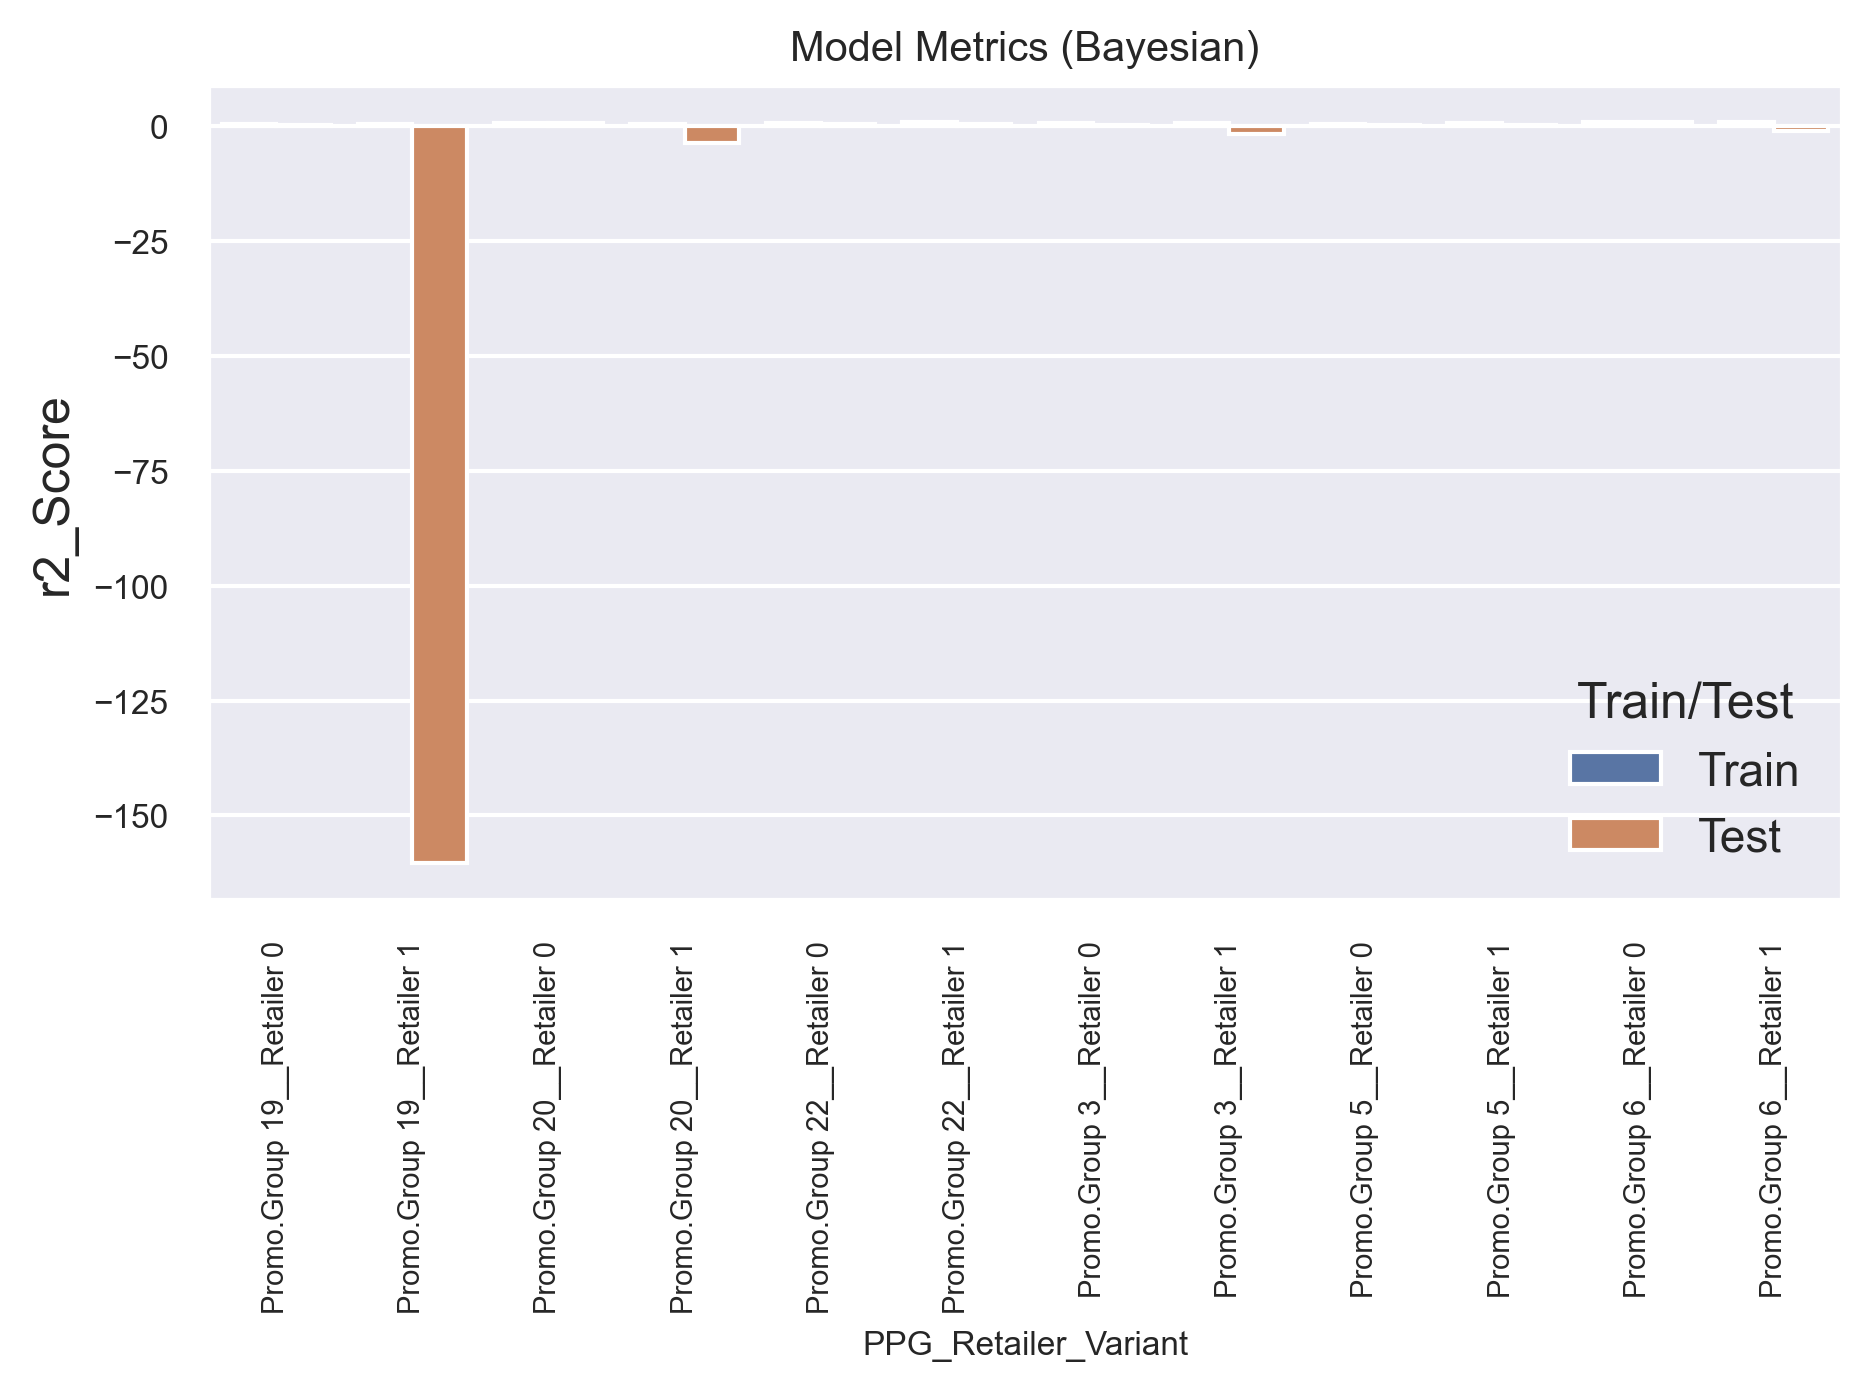

In [93]:
# Metrics barplot for various models
best_performing_models_bayes = best_performing_models[best_performing_models.Model.str.startswith('Bayes')]
df1 = best_performing_models_bayes[['PPG_Retailer_Variant','Train_r2']]
df1['Train/Test'] = 'Train'
df2 = best_performing_models_bayes[['PPG_Retailer_Variant','Test_r2']]
df2['Train/Test'] = 'Test'
df2.rename(columns={'Test_r2':'Train_r2'},inplace=True)
temp = df1.append(df2)
temp.rename(columns={'Train_r2':'r2_Score'},inplace=True)
sns.barplot(x='PPG_Retailer_Variant',y='r2_Score',data=temp,hue='Train/Test')
plt.xticks(rotation=90, fontsize=5)
plt.xticks(fontsize=7)
plt.yticks(fontsize=8)
plt.xlabel('PPG_Retailer_Variant', loc='center', fontsize=8)
plt.title('Model Metrics (Bayesian)',fontsize=10)
plt.tight_layout();

if overwrite_permission:
    plt.savefig(f"{final_report_folder}\Model_Metrics_Bayesian.png")

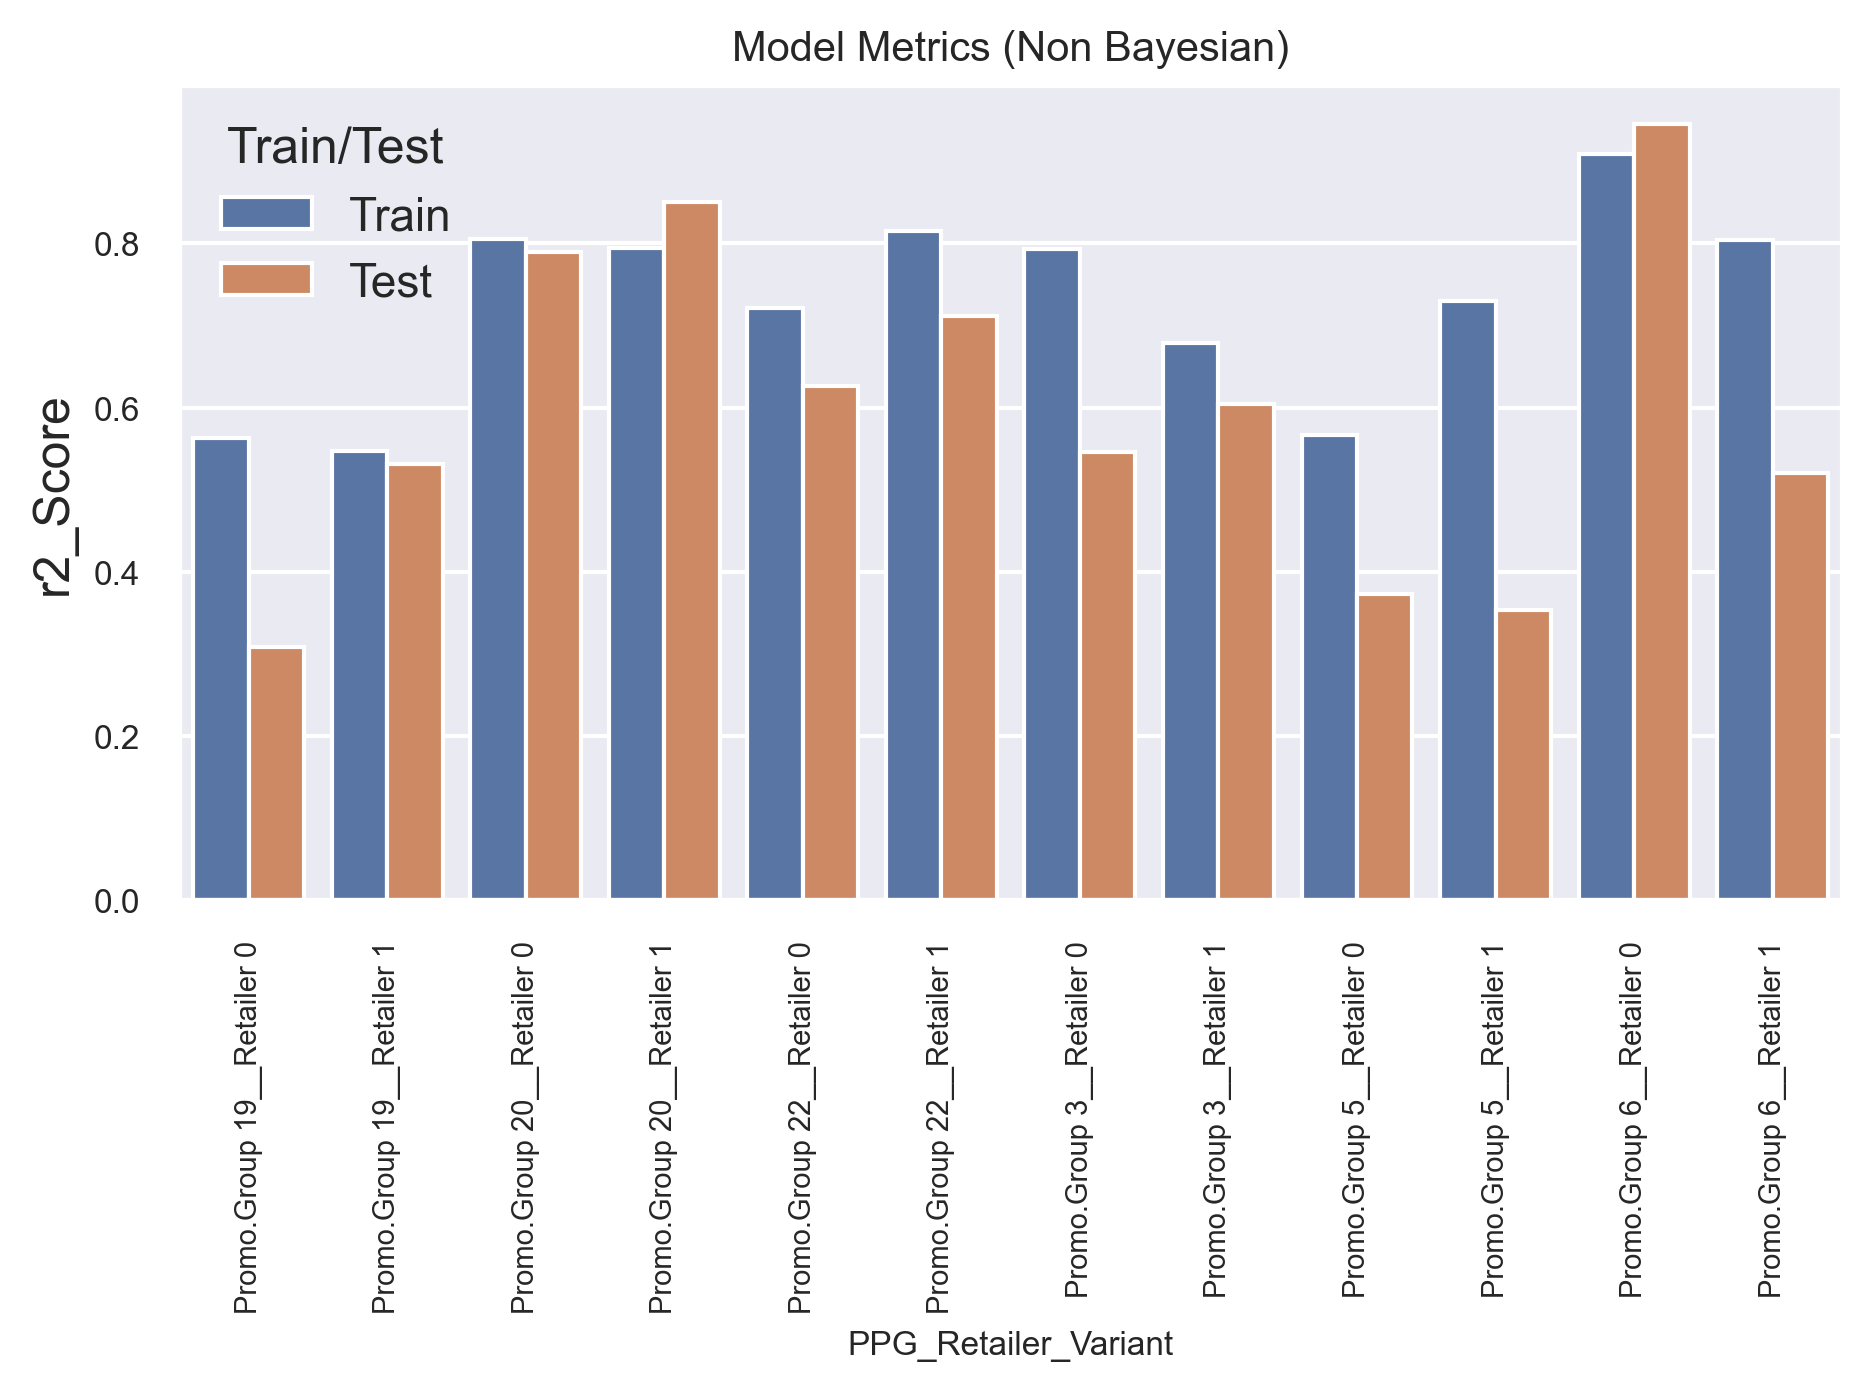

In [94]:
# Metrics barplot for various models
best_performing_models_nonbayes = best_performing_models[~best_performing_models.Model.str.startswith('Bayes')]
df1 = best_performing_models_nonbayes[['PPG_Retailer_Variant','Train_r2']]
df1['Train/Test'] = 'Train'
df2 = best_performing_models_nonbayes[['PPG_Retailer_Variant','Test_r2']]
df2['Train/Test'] = 'Test'
df2.rename(columns={'Test_r2':'Train_r2'},inplace=True)
temp = df1.append(df2)
temp.rename(columns={'Train_r2':'r2_Score'},inplace=True)
sns.barplot(x='PPG_Retailer_Variant',y='r2_Score',data=temp,hue='Train/Test')
plt.xticks(rotation=90, fontsize=5)
plt.xticks(fontsize=7)
plt.yticks(fontsize=8)
plt.xlabel('PPG_Retailer_Variant', loc='center', fontsize=8)
plt.title('Model Metrics (Non Bayesian)',fontsize=10)
plt.tight_layout();

if overwrite_permission:
    plt.savefig(f"{final_report_folder}\Model_Metrics_NonBayesian.png")

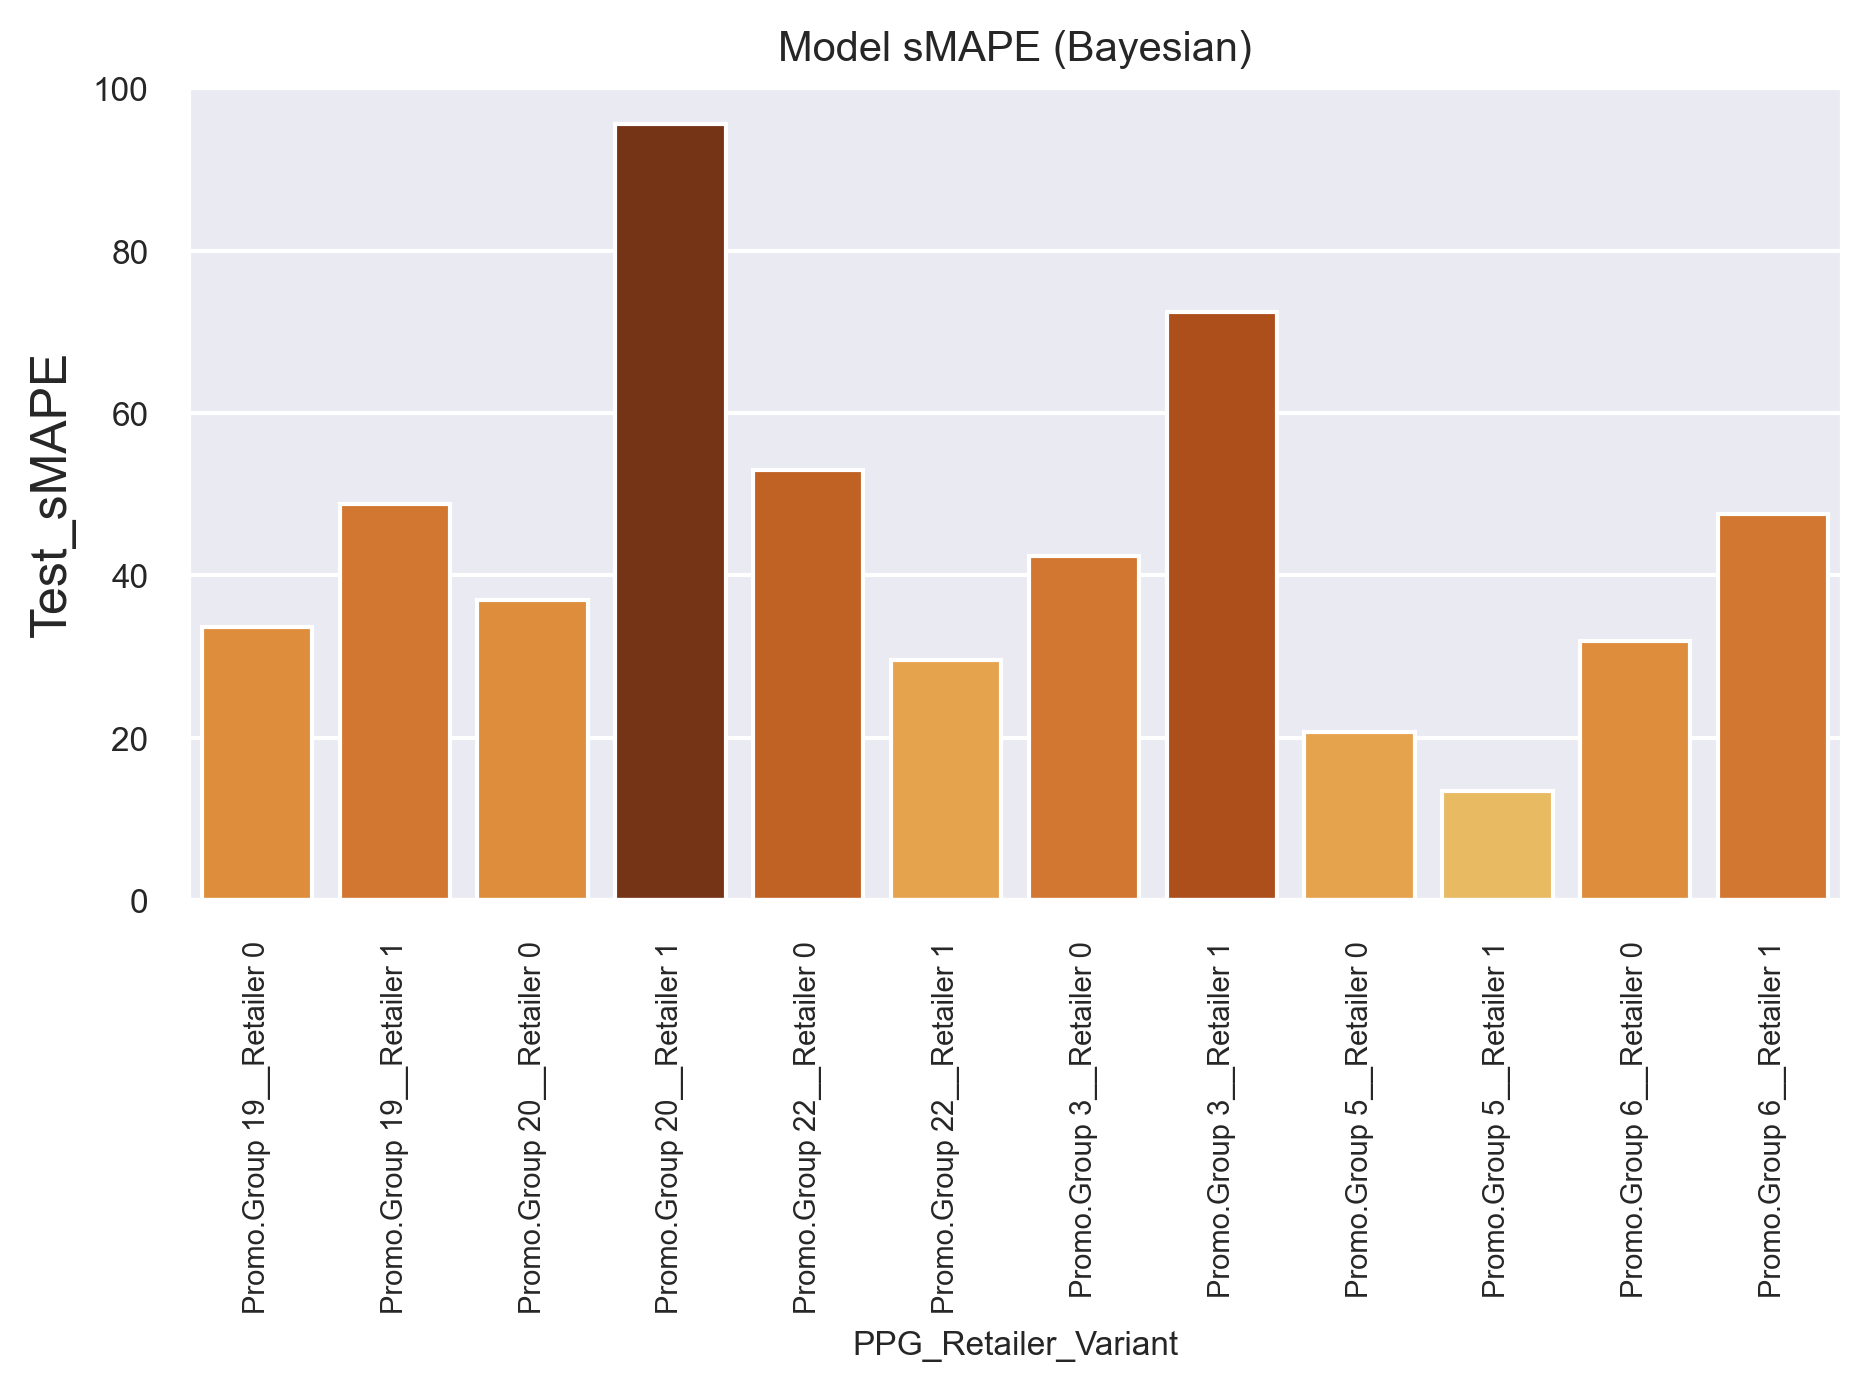

In [95]:
# sMAPE barplot for various models
pal = sns.color_palette("YlOrBr", len(best_performing_models_bayes))
array = best_performing_models_bayes['Test_sMAPE']
rank = [int((max(array)-elem)*len(best_performing_models_bayes)*0.75/(max(array)+1)) for elem in array]
sns.barplot(x='PPG_Retailer_Variant',y='Test_sMAPE',data=best_performing_models_bayes,palette=np.array(pal[::-1])[rank])
plt.xticks(rotation=90, fontsize=5)
plt.xticks(fontsize=7)
plt.yticks(fontsize=8)
plt.xlabel('PPG_Retailer_Variant', loc='center', fontsize=8)
plt.title('Model sMAPE (Bayesian)',fontsize=10)
plt.tight_layout();

if overwrite_permission:
    plt.savefig(f"{final_report_folder}\Model_sMAPE_Bayesian.png")

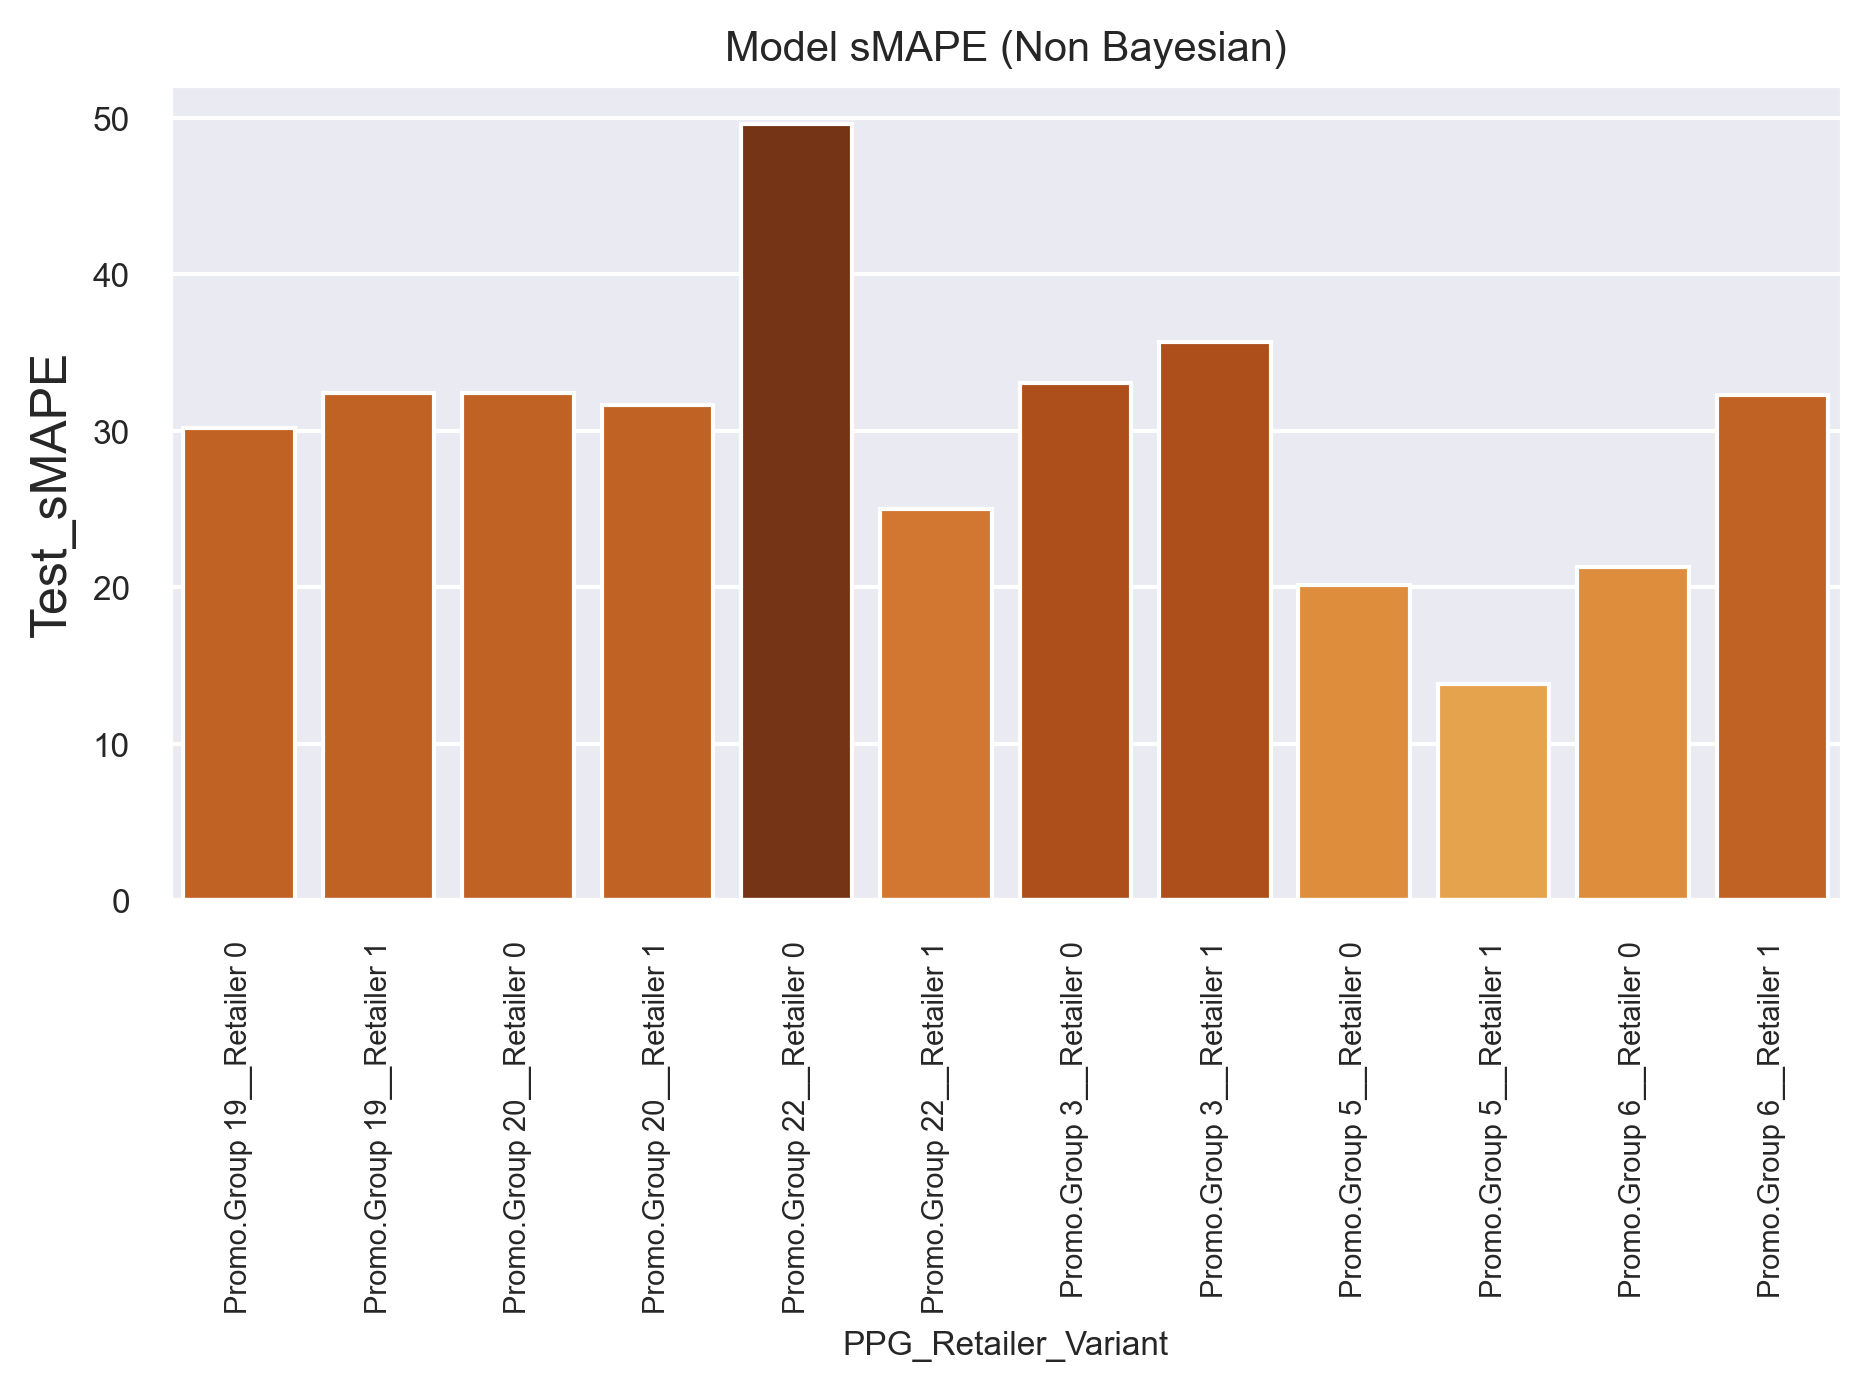

In [96]:
# sMAPE barplot for various models
pal = sns.color_palette("YlOrBr", len(best_performing_models_nonbayes))
array = best_performing_models_nonbayes['Test_sMAPE']
rank = [int((max(array)-elem)*len(best_performing_models_nonbayes)*0.75/(max(array)+1)) for elem in array]
sns.barplot(x='PPG_Retailer_Variant',y='Test_sMAPE',data=best_performing_models_nonbayes,palette=np.array(pal[::-1])[rank])
plt.xticks(rotation=90, fontsize=5)
plt.xticks(fontsize=7)
plt.yticks(fontsize=8)
plt.xlabel('PPG_Retailer_Variant', loc='center', fontsize=8)
plt.title('Model sMAPE (Non Bayesian)',fontsize=10)
plt.tight_layout();

if overwrite_permission:
    plt.savefig(f"{final_report_folder}\Model_sMAPE_NonBayesian.png")

In [97]:
model_dict_bayes = best_performing_models_bayes.set_index('PPG_Retailer_Variant')['Model'].to_dict()
model_dict_bayes

{'Promo.Group 19__Retailer 0': 'BayesianRegression',
 'Promo.Group 19__Retailer 1': 'BayesianRegression',
 'Promo.Group 20__Retailer 0': 'BayesianRegression',
 'Promo.Group 20__Retailer 1': 'BayesianRegression',
 'Promo.Group 22__Retailer 0': 'BayesianRegression',
 'Promo.Group 22__Retailer 1': 'BayesianRegression',
 'Promo.Group 3__Retailer 0': 'BayesianRegression',
 'Promo.Group 3__Retailer 1': 'BayesianRegression',
 'Promo.Group 5__Retailer 0': 'BayesianRegression',
 'Promo.Group 5__Retailer 1': 'BayesianRegression',
 'Promo.Group 6__Retailer 0': 'BayesianRegression',
 'Promo.Group 6__Retailer 1': 'BayesianRegression'}

In [98]:
model_dict_nonbayes = best_performing_models_nonbayes.set_index('PPG_Retailer_Variant')['Model'].to_dict()
model_dict_nonbayes

{'Promo.Group 19__Retailer 0': 'LassoRegression',
 'Promo.Group 19__Retailer 1': 'LinearRegression',
 'Promo.Group 20__Retailer 0': 'RidgeRegression',
 'Promo.Group 20__Retailer 1': 'LassoRegression',
 'Promo.Group 22__Retailer 0': 'LassoRegression',
 'Promo.Group 22__Retailer 1': 'LassoRegression_Positive',
 'Promo.Group 3__Retailer 0': 'RidgeRegression',
 'Promo.Group 3__Retailer 1': 'RidgeRegression',
 'Promo.Group 5__Retailer 0': 'LinearRegression',
 'Promo.Group 5__Retailer 1': 'LassoRegression',
 'Promo.Group 6__Retailer 0': 'LassoRegression',
 'Promo.Group 6__Retailer 1': 'SGDRegression'}

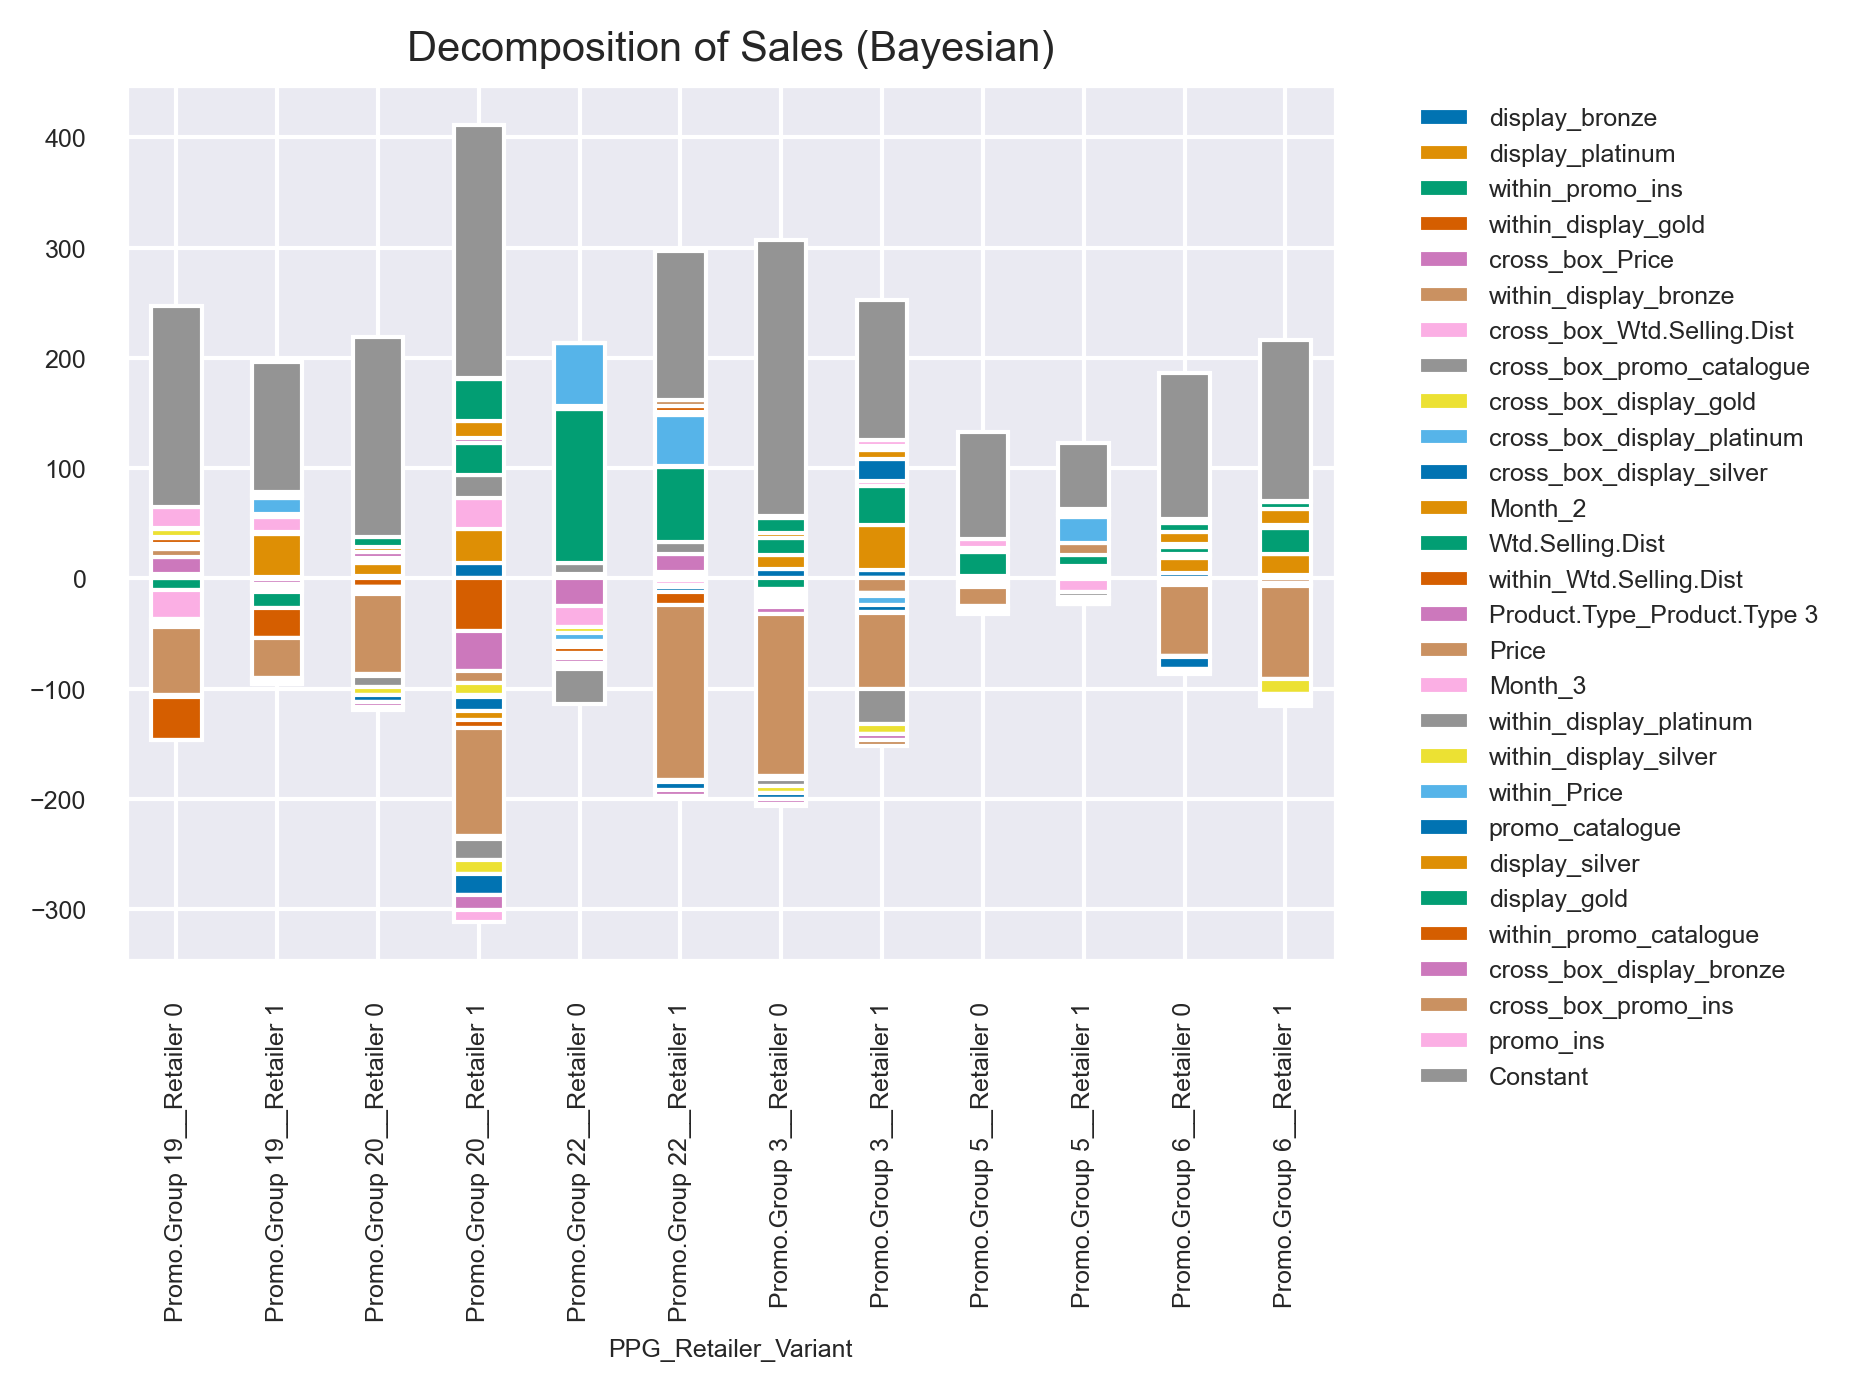

In [99]:
# Calculating sales decomposition for various PPG x Retailer
decompose_sales = pd.DataFrame()
for dataset in os.listdir(ppg_retailer_contributions_percent):
    df = pd.read_csv(f"{ppg_retailer_contributions_percent}\{dataset}")
    for k, v in model_dict_bayes.items():
        if dataset.startswith(k):
            model = v
            df_contribute = df[df.Model==model]
            # relative_contribution = np.round(100 * df_contribute.iloc[:,1:]/df_contribute.iloc[:,1:].sum(axis=1).iloc[0], 2)
            columns = list(df_contribute.columns)
            df_contribute['PPG_Retailer_Variant'] = k
            df_contribute = df_contribute[['PPG_Retailer_Variant']+columns]
            decompose_sales = decompose_sales.append(df_contribute)


temp = decompose_sales.set_index('PPG_Retailer_Variant')
ax = temp.plot(kind='bar', stacked=True,  color=sns.color_palette('colorblind'))
sns.move_legend(ax, "upper left",bbox_to_anchor=(1.05, 1),fontsize=6)
plt.xticks(fontsize=6)
plt.yticks(fontsize=6)
plt.xlabel('PPG_Retailer_Variant', loc='center', fontsize=6)
plt.title('Decomposition of Sales (Bayesian)',fontsize=10)
plt.tight_layout();

if overwrite_permission:
    decompose_sales.to_csv(f"{final_report_folder}\Decomposition_of_Sales_Bayesian.csv", index=False)
    plt.savefig(f"{final_report_folder}\Decomposition_of_Sales_Bayesian.png")

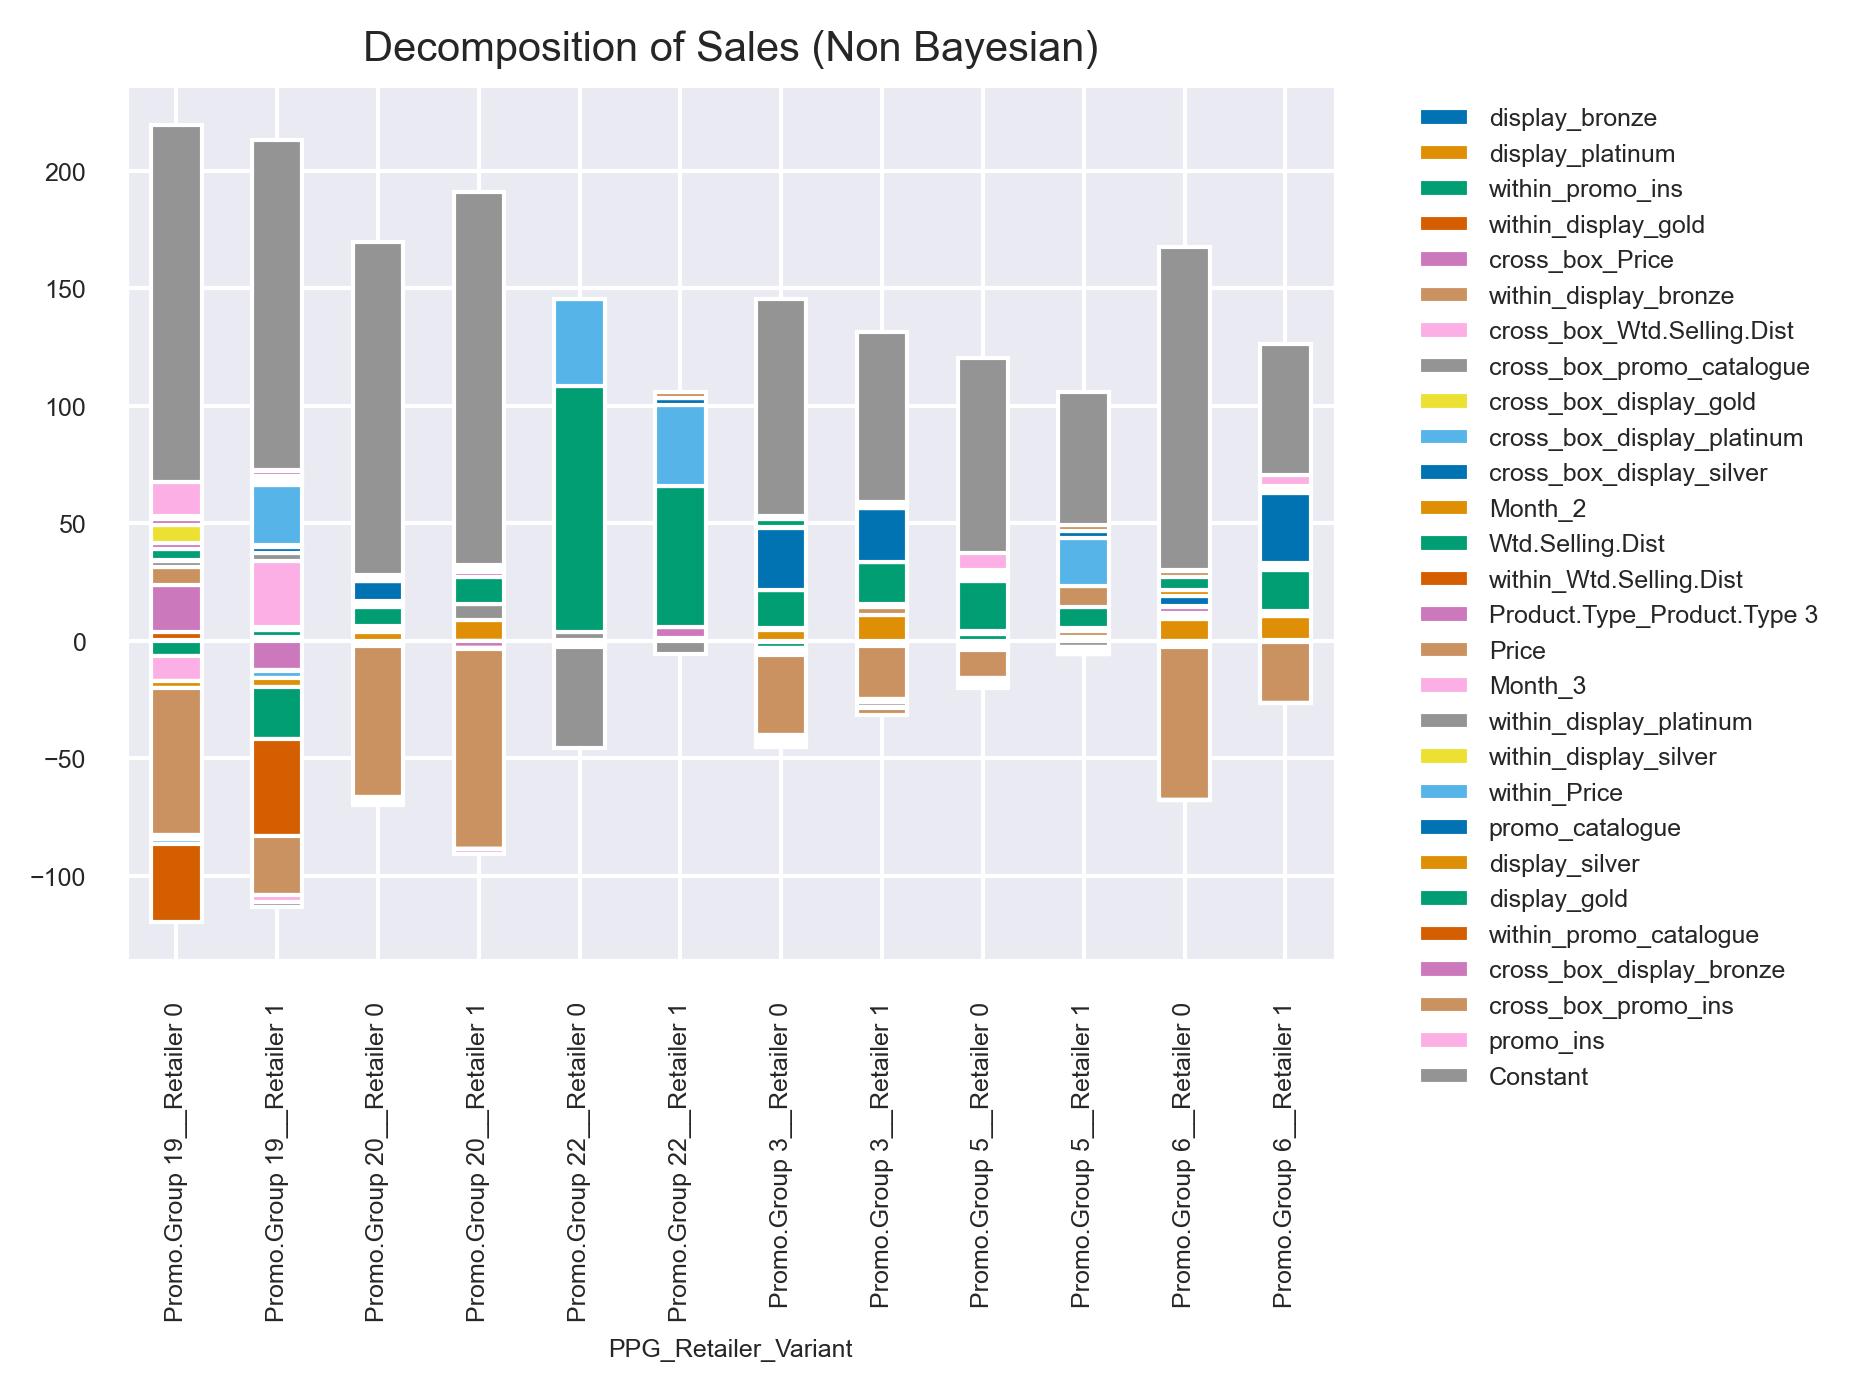

In [100]:
# Calculating sales decomposition for various PPG x Retailer
decompose_sales = pd.DataFrame()
for dataset in os.listdir(ppg_retailer_contributions_percent):
    df = pd.read_csv(f"{ppg_retailer_contributions_percent}\{dataset}")
    for k, v in model_dict_nonbayes.items():
        if dataset.startswith(k):
            model = v
            df_contribute = df[df.Model==model]
            # relative_contribution = np.round(100 * df_contribute.iloc[:,1:]/df_contribute.iloc[:,1:].sum(axis=1).iloc[0], 2)
            columns = list(df_contribute.columns)
            df_contribute['PPG_Retailer_Variant'] = k
            df_contribute = df_contribute[['PPG_Retailer_Variant']+columns]
            decompose_sales = decompose_sales.append(df_contribute)


temp = decompose_sales.set_index('PPG_Retailer_Variant')
ax = temp.plot(kind='bar', stacked=True,  color=sns.color_palette('colorblind'))
sns.move_legend(ax, "upper left",bbox_to_anchor=(1.05, 1),fontsize=6)
plt.xticks(fontsize=6)
plt.yticks(fontsize=6)
plt.xlabel('PPG_Retailer_Variant', loc='center', fontsize=6)
plt.title('Decomposition of Sales (Non Bayesian)',fontsize=10)
plt.tight_layout();

if overwrite_permission:
    decompose_sales.to_csv(f"{final_report_folder}\Decomposition_of_Sales_NonBayesian.csv", index=False)
    plt.savefig(f"{final_report_folder}\Decomposition_of_Sales_NonBayesian.png")